In [1]:
import pandas as pd
import numpy as np
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions
                                            )
from graphein.protein.features.nodes import (
    amino_acid_one_hot,
    expasy_protein_scale,
    hydrogen_bond_acceptor,
    hydrogen_bond_donor,
    meiler_embedding
)
from graphein.protein.features.nodes.geometry import add_sidechain_vector, add_beta_carbon_vector, add_sequence_neighbour_vector
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import torch_geometric
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
import pickle
import random
import warnings
import os
import h5py
import g2papi

[09/16/24 09:16:42] WARNING  To use the Graphein submodule                                         ]8;id=49730;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=42066;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/features/sequence/embeddings.py#45\45]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             To do so, use the following command: pip install biovec                               
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[09/16/24 09:16:43] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=820087;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=704180;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/visualisation.py#36\36]8;;\
                             need to install: pytorch3d                                                            
                             pytorch3d cannot be installed via pip                                                 

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=419851;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=837472;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/meshes.py#30\30]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: pip install pytorch3d                            

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()
warnings.filterwarnings("ignore")

In [3]:
af_db_path = "/work/gr-fe/databases/alpha_fold/human/"
prefix = "AF-"
suffix = "-F1-model_v4.pdb"

In [4]:
# define edge and annotation functions

edge_funcs = {"edge_construction_functions": [add_peptide_bonds,
                                              add_aromatic_interactions,
                                              add_hydrogen_bond_interactions,
                                              add_disulfide_interactions,
                                              add_ionic_interactions,
                                              add_aromatic_sulphur_interactions,
                                              add_cation_pi_interactions]}


all_node_metadata = {"node_metadata_functions" : [amino_acid_one_hot,
                                                 expasy_protein_scale,
                                                 hydrogen_bond_acceptor,
                                                 hydrogen_bond_donor,
                                                 meiler_embedding]}

#all_graph_metadata = {"graph_metadata_functions": [esm_residue_embedding]}  

#config = ProteinGraphConfig(**{**edge_funcs, **all_node_metadata, **all_graph_metadata}) 
config = ProteinGraphConfig(**{**edge_funcs, **all_node_metadata}) 

In [5]:
# read ground_truth dataframe

df = pd.read_csv("../data/DN_LOF_GOF_truth.tsv", sep="\t")
df

HGNC  DN  LOF  GOF UniprotEntry
0       AARS1   1    0    0       P49588
1       ABCA1   1    0    0       O95477
2         ACD   1    0    0       Q96AP0
3       ACTA1   1    0    0       P68133
4        ACTB   1    1    1       P60709
...       ...  ..  ...  ...          ...
1271    ZFPM2   0    1    0       Q8WW38
1272     ZIC2   0    1    0       O95409
1273    ZMYM2   0    1    0       Q9UBW7
1274  ZMYND11   0    1    0       Q15326
1275   ZNF462   0    1    0       Q96JM2

[1276 rows x 5 columns]

In [6]:
# extract labels and uniprot ids

all_uniprot_ids = [] 
all_hgnc = []
all_labels = [] 

for index, row in df.iterrows():
    all_uniprot_ids.append(row["UniprotEntry"])
    all_hgnc.append(row["HGNC"])
    all_labels.append([row["DN"], row["LOF"], row["GOF"]])

In [7]:
# read extra features from describeProt

describe_prot = pd.read_csv("../data/describePROT_clean.tsv", sep="\t")
describe_prot_featnames = describe_prot.columns[(describe_prot.columns != "seqlength") & (describe_prot.columns != "UniprotEntry") & (describe_prot.columns != "SignalP_score")] #SignalP_score doesnt match the protein length
describe_prot

UniprotEntry                                 ASAquick_normscore  \
0       A0A024R1R8  0.747,0.578,0.611,0.572,0.581,0.494,0.366,0.52...   
1       A0A024RBG1  0.695,0.392,0.521,0.209,0.444,0.421,0.455,0.40...   
2       A0A075B6H5  0.694,0.501,0.365,0.286,0.237,0.290,0.280,0.20...   
3       A0A075B6H7  0.721,0.579,0.358,0.389,0.238,0.276,0.085,0.08...   
4       A0A075B6H8  0.649,0.510,0.364,0.481,0.218,0.241,0.259,0.37...   
...            ...                                                ...   
20449       V9GZ13  0.752,0.627,0.587,0.419,0.434,0.395,0.326,0.47...   
20450       W5XKT8  0.590,0.263,0.221,0.247,0.248,0.137,0.144,0.32...   
20451       W6CW81  0.703,0.524,0.455,0.454,0.260,0.369,0.272,0.16...   
20452       X5D2U9  0.570,0.295,0.150,0.142,0.357,0.109,0.425,0.51...   
20453       X6R8D5  0.669,0.453,0.485,0.515,0.492,0.433,0.503,0.31...   

                                            DFLpredScore  \
0      0.026,0.021,0.022,0.020,0.018,0.019,0.023,0.02...   
1      0.024,0.032,0.040,0.038,0.043,0.055,0.059,0.07...   
2      0.068,0.082,0.084,0.107,0.138,0.158,0.191,0.22...   
3      0.047,0.046,0.043,0.040,0.038,0.043,0.040,0.04...   
4      0.060,0.054,0.067,0.061,0.056,0.052,0.048,0.05...   
...                                                  ...   
20449  0.070,0.089,0.095,0.084,0.076,0.080,0.081,0.09...   
20450  0.045,0.050,0.062,0.074,0.075,0.068,0.062,0.06...   
20451  0.025,0.027,0.027,0.034,0.043,0.041,0.044,0.05...   
20452  0.077,0.092,0.100,0.075,0.077,0.086,0.081,0.09...   
20453  0.053,0.062,0.062,0.070,0.058,0.045,0.048,0.05...   

                                        DRNApredDNAscore  \
0      0.036,0.092,0.094,0.123,0.070,0.081,0.080,0.09...   
1      0.099,0.090,0.134,0.082,0.236,0.132,0.199,0.36...   
2      0.181,0.109,0.309,0.136,0.190,0.342,0.386,0.13...   
3      0.152,0.203,0.157,0.115,0.130,0.130,0.099,0.09...   
4      0.431,0.393,0.548,0.570,0.354,0.274,0.292,0.26...   
...                                                  ...   
20449  0.818,0.894,0.837,0.867,0.869,0.882,0.437,0.88...   
20450  0.119,0.088,0.078,0.082,0.103,0.097,0.119,0.32...   
20451  0.257,0.144,0.442,0.246,0.349,0.418,0.124,0.11...   
20452  0.077,0.072,0.071,0.066,0.143,0.080,0.097,0.12...   
20453  0.119,0.110,0.172,0.193,0.092,0.196,0.094,0.18...   

                                        DRNApredRNAscore  \
0      0.441,0.247,0.219,0.259,0.200,0.280,0.291,0.30...   
1      0.081,0.078,0.067,0.048,0.060,0.059,0.057,0.06...   
2      0.052,0.044,0.032,0.030,0.031,0.034,0.034,0.03...   
3      0.066,0.065,0.062,0.062,0.063,0.063,0.060,0.06...   
4      0.038,0.038,0.040,0.037,0.036,0.036,0.036,0.03...   
...                                                  ...   
20449  0.020,0.020,0.020,0.020,0.020,0.020,0.020,0.02...   
20450  0.066,0.051,0.049,0.049,0.051,0.050,0.050,0.05...   
20451  0.058,0.044,0.050,0.046,0.049,0.050,0.043,0.04...   
20452  0.147,0.116,0.110,0.073,0.093,0.077,0.114,0.09...   
20453  0.068,0.064,0.063,0.065,0.058,0.064,0.058,0.06...   

                                            DisoDNAscore  \
0      0.478,0.444,0.516,0.472,0.430,0.489,0.541,0.50...   
1      0.172,0.142,0.135,0.145,0.110,0.116,0.094,0.12...   
2      0.060,0.069,0.076,0.081,0.088,0.086,0.095,0.10...   
3      0.072,0.077,0.081,0.048,0.052,0.053,0.054,0.05...   
4      0.174,0.172,0.171,0.169,0.168,0.105,0.107,0.10...   
...                                                  ...   
20449  0.054,0.059,0.064,0.069,0.074,0.080,0.081,0.09...   
20450  0.185,0.199,0.198,0.195,0.192,0.191,0.189,0.18...   
20451  0.156,0.144,0.158,0.158,0.150,0.122,0.121,0.11...   
20452  0.301,0.305,0.295,0.286,0.275,0.253,0.247,0.23...   
20453  0.168,0.156,0.174,0.184,0.190,0.193,0.124,0.09...   

                                            DisoPROscore  \
0      0.582,0.621,0.632,0.638,0.652,0.622,0.609,0.61...   
1      0.505,0.495,0.473,0.483,0.483,0.486,0.484,0.49...   
2      0.481,0.501,0.490,0.473,0.473,0.476,0.468,0.42...   
3    

In [8]:
uniprot = pd.read_csv("../data/uniprot_all_human_proteins_annotated.txt", sep="\t")
uniprot_features = ['ACT_SITE', 'BINDING', 'DNA_BIND',
                   'TOPO_DOM', 'TRANSMEM',
                   'DISULFID',  'PROPEP', 'SIGNAL', 'TRANSIT',
                   'STRAND', 'HELIX',
                   'COILED', 'COMPBIAS', 'DOMAIN', 'REGION', 'REPEAT', 'ZN_FING']

# Initialize a new DataFrame to store the output
uniprot_clean = pd.DataFrame()
uniprot_clean['Entry'] = uniprot['Entry']  # Copy 'Entry' column Length
uniprot_clean['Length'] = uniprot['Length'] 

# Iterate over each feature and assign the correct value to the output
for feature in uniprot_features:
    actual_or_pred_col = f'actual_or_pred_{feature}'
    actual_annotation_col = f'annotation_actual_{feature}'
    pred_annotation_col = f'annotation_pred_{feature}'
    
    # Use `np.where` to conditionally select the 'actual' or 'pred' annotation
    uniprot_clean[feature] = uniprot.apply(
        lambda row: row[actual_annotation_col] if row[actual_or_pred_col] == 'actual' else row[pred_annotation_col], 
        axis=1
    )

# Display the resulting DataFrame
uniprot_clean

Entry  Length                                           ACT_SITE  \
0      A0A087X1C5     515  0000000000000000000000000000000000000000000000...   
1      A0A0B4J2F0      54  0000000000000000000000000000000000000000000000...   
2      A0A0B4J2F2     783  0000000000000000000000000000000000000000000000...   
3      A0A0C5B5G6      16                                   0000000000000000   
4      A0A0K2S4Q6     201  0000000000000000000000000000000000000000000000...   
...           ...     ...                                                ...   
20429      Q9UI54      55  0000000000000000000000000000000000000000000000...   
20430      Q9UI72      69  0000000000000000000000000000000000000000000000...   
20431      Q9Y3F1      56  0000000000000000000000000000000000000000000000...   
20432      Q9Y6C7      94  0000000000000000000000000000000000000000000000...   
20433      Q9Y6Z2      57  0000000000000000000000000000000000000000000000...   

                                                 BINDING  \
0      0000000000000000000000000000000000000000000000...   
1      0000000000000000000000000000000000000000000000...   
2      0000000000000000000000000000000011111111100000...   
3                                       0000000000000000   
4      0000000000000000000000000000000000000000000000...   
...                                                  ...   
20429  0000000000000000000000000000000000000000000000...   
20430  0000000000000000000000000000000000000000000000...   
20431  0000000000000000000000000000000000000000000000...   
20432  0000000000000000000000000000000000000000000000...   
20433  0000000000000000000000000000000000000000000000...   

                                                DNA_BIND  \
0      0000000000000000000000000000000000000000000000...   
1      0000000000000000000000000000000000000000000000...   
2      0000000000000000000000000000000000000000000000...   
3                                       0000000000000000   
4      0000000000000000000000000000000000000000000000...   
...                                                  ...   
20429  0000000000000000000000000000000000000000000000...   
20430  0000000000000000000000000000000000000000000000...   
20431  0000000000000000000000000000000000000000000000...   
20432  0000000000000000000000000000000000000000000000...   
20433  0000000000000000000000000000000000000000000000...   

                                                TOPO_DOM  \
0      1100000000000000000000011111111111111111111111...   
1      1111000000000000000000000111111111111111111111...   
2      1111111111111111111111111111111111111111111111...   
3                                       1111111111111111   
4      0000000000000000000000001111111111111111111111...   
...                                                  ...   
20429  0000000000000000000000000000000000001111111111...   
20430  1111111111111111111111111111111111111111111111...   
20431  1111000000000000000000000001111111111111111111...   
20432  0110000000000000000000000000000000000000000000...   
20433  1111111111111111111111111111111111111111111111...   

                                                TRANSMEM  \
0      0011111111111111111111100000000000000000000000...   
1      0000111111111111111111111000000000000000000000...   
2      0000000000000000000000000000000000000000000000...   
3                                       0000000000000000   
4      0000000000000000000000000000000000000000000000...   
...                                                  ...   
20429  0000000000000011111111111111111111100000000000...   
20430  1111111111000000000000000000000000000000000000...   
20431  0011001111111111111111111110000000000000000000...   
20432  0000000000110011110011111111100111111111111111...   
20433  0000000000000000000000000000000000000000000000...   

                                                DISULFID  \
0      0000000000000000000000000000000000000000000000...   
1      0000000000000000000000000000000000000000

In [9]:
# conservation
phylop = pd.read_csv("../data/proteins_phylop_perresidue.tsv.gz", sep="\t")
phylop_features = ['phyloP100way_vertebrate', 'phyloP30way_mammalian']
phylop

Entry                            phyloP100way_vertebrate  \
0      A0A075B759  1.6,0.1,1.2,1.4,-0.1,3.1,1.5,2.3,0.7,-0.4,-1.7...   
1      A0A075B767  1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1....   
2      A0A087WTH1  3.1,2.4,2.8,1.8,4.1,2.7,2.2,1.8,2.3,0.3,1.9,1....   
3      A0A087WUV0  0.6,0.8,-0.4,-0.9,0.5,0.6,2.5,-0.1,0.5,0.9,1.3...   
4      A0A087WV53  3,2.3,3.1,0.9,1.7,0.6,0.1,2.1,2.1,0.2,-0.4,1,0...   
...           ...                                                ...   
18174      Q9Y6Z7  4.4,4.4,4.4,4.4,4.4,4.4,4.4,4.4,4.4,4.4,4.4,4....   
18175      U3KPV4  3.7,2.2,2.9,0.6,2.7,2.7,0.1,-0.4,7.4,2.8,0.4,2...   
18176      W5XKT8  1.1,1.2,-0.2,-0.2,-0.6,-0.9,-1.9,-0.9,-0.2,0.3...   
18177      X6R8D5  -0.9,0.5,0.5,-0.3,1.2,-1.6,0.3,0.2,0.2,0.2,0,0...   
18178      X6R8R1  0,1.6,0.2,0.5,-1.8,1.6,4.9,1.9,3.6,6.9,0.7,2.3...   

                                   phyloP30way_mammalian  
0      0.3,0.3,-0.5,-1.5,-0.8,-0.3,-0.1,0,-0.1,-0.1,-...  
1      0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0....  
2      1.2,0.6,1.2,0.9,1.2,1.3,1.1,0.7,0.9,-0.1,1.1,0...  
3      0.9,0.7,0.8,-0.2,0.5,1,0.6,0,0.4,0.1,0.1,0.9,0...  
4      1,0.9,0.7,0.9,0.9,0.9,0.1,0.8,0.7,0.5,0.3,0.5,...  
...                                                  ...  
18174  1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1....  
18175  0.3,0.8,1,0.7,1.1,1.1,-0.1,0.4,1.2,1.1,-0.1,0....  
18176  1.2,0.6,-0.2,-0.7,-0.3,-0.7,0.2,-0.4,-0.7,-0.8...  
18177  0.3,-0.4,0.3,-0.2,0.8,-0.1,1.1,0.1,0.3,0.1,0.2...  
18178  0.5,1.1,-0.5,-0.9,-0.9,0.4,1,0.3,0.4,1,0.1,0.8...  

[18179 rows x 3 columns]

In [ ]:
# read protein (graph) features
archs_df = pd.read_csv("../data/archs_protein_embeds.tsv.gz", sep="\t")
go_df = pd.read_csv("../data/go_protein_embeds.tsv.gz", sep="\t")
string_df = pd.read_csv("../data/string_protein_embeds.tsv.gz", sep="\t")
gnomad_df = pd.read_csv("../data/gnomadv4_constraints.tsv.gz", sep="\t")

In [ ]:

# creat PyG objects
all_pyg_graphs = []
all_graphein_features = ["amino_acid_one_hot", "expasy", 'hbond_acceptors', 'hbond_donors', 'meiler', 'sidechain_vector', 'c_beta_vector', 'sequence_neighbour_vector_n_to_c']  # AAonehot 20, expasy = 61, hbond_acceptors=1, hbond_donors=1, meiler=7, sidechain_vector=3, c_beta_vector=3, sequence_neighbour_vector_n_to_c=3
#all_g2p_features = ["Accessible surface area (Å²)*", "Phi angle (degrees)*", "Psi angle (degrees)*", "ss_B", "ss_C", "ss_H"]

counter = 1
for uniprot_id, hgnc, label in zip(all_uniprot_ids, all_hgnc, all_labels):

    # remove those that are not in the describe_prot database
    if uniprot_id not in describe_prot["UniprotEntry"].values:
        continue
        
    # construct a networkx graph from AlphaFold predictions
    g = construct_graph(config=config, path=(af_db_path + prefix + uniprot_id + suffix))

    add_sidechain_vector(g)
    add_beta_carbon_vector(g)
    add_sequence_neighbour_vector(g)
    
    # convert to PyG object
    g2 = from_networkx(g)

    '''
    # ignore proteins with problematic length
    if len(g2.residue_name) != describe_prot[describe_prot["UniprotEntry"] == uniprot_id]["seqlength"].values[0]:
        continue

    if len(g2.residue_name) != uniprot_clean[uniprot_clean["Entry"] == uniprot_id]["Length"].values[0]:
        continue
    '''
    
    # add graphein features
    g2.x = g2[all_graphein_features[0]] 
    for feature in all_graphein_features[1:]:
        g2.x = torch.cat((g2.x, g2[feature]), dim=1)

    # add describe_prot features
    for feature in describe_prot_featnames:
        try:
            temp_feature = describe_prot[describe_prot["UniprotEntry"] == uniprot_id][feature].values[0]
            temp_num_list = [float(num) for num in temp_feature.split(',')]
            temp_num_tensor = torch.tensor(temp_num_list).reshape(-1, 1)
            g2.x = torch.cat((g2.x, temp_num_tensor), dim=1)
        except:
            g2.x = torch.cat((g2.x, torch.full((len(g2.residue_name), 1), float('nan'))), dim=1)

    # add uniprot features
    for feature in uniprot_features:
        try:
            temp_feature = uniprot_clean[uniprot_clean["Entry"] == uniprot_id][feature].values[0]
            temp_num_list = [int(char) for char in temp_feature]
            temp_num_tensor = torch.tensor(temp_num_list).reshape(-1, 1)
            g2.x = torch.cat((g2.x, temp_num_tensor), dim=1)
        except:
            g2.x = torch.cat((g2.x, torch.full((len(g2.residue_name), 1), float('nan'))), dim=1)

    # add phylop features
    for feature in phylop_features:
        try:
            temp_feature = phylop[phylop["Entry"] == uniprot_id][feature].values[0]
            temp_num_list = [float(num) for num in temp_feature.split(',')]
            temp_num_tensor = torch.tensor(temp_num_list).reshape(-1, 1)
            g2.x = torch.cat((g2.x, temp_num_tensor), dim=1)
        except:
            g2.x = torch.cat((g2.x, torch.full((len(g2.residue_name), 1), float('nan'))), dim=1)
    
    # add protT5 embeddings
    with h5py.File('../data/protT5_per_residue.h5', 'r') as f:
        embeds = f[uniprot_id][:]  

    '''
    if embeds.shape[0] != g2.x.shape[0]:
        continue
    '''
    
    try:
        g2.x = torch.cat((g2.x, torch.from_numpy(embeds)), dim=1)
    except:
        g2.x = torch.cat((g2.x, torch.full((len(g2.residue_name), 1024), float('nan'))), dim=1)
    
    
    '''
    # add G2P features
    g2p_features = g2papi.get_protein_features(geneName=hgnc, uniprotId=uniprot_id)
    g2p_features['ss_B'] = g2p_features['Secondary structure (DSSP 3-state)*'].apply(lambda x: 1 if x == 'B (strand)' else 0)
    g2p_features['ss_C'] = g2p_features['Secondary structure (DSSP 3-state)*'].apply(lambda x: 1 if x == 'C (loop/coil)' else 0)
    g2p_features['ss_H'] = g2p_features['Secondary structure (DSSP 3-state)*'].apply(lambda x: 1 if x == 'H (helix)' else 0)
    g2p_features2 = g2p_features[all_g2p_features]
    g2.x = torch.cat((g2.x, torch.tensor(g2p_features2.values, dtype=torch.float32)), dim=1) 
    '''

    # add protein (graph) features
    try:
        archs_embed = torch.tensor(archs_df[archs_df["uniprot_ids"] == uniprot_id].values[0][1:].tolist())
    except:
        archs_embed = torch.full((256,), float('nan'))

    try:
        go_embed = torch.tensor(go_df[go_df["uniprot_ids"] == uniprot_id].values[0][1:].tolist())
    except:
        go_embed = torch.full((256,), float('nan'))

    try:
        string_embed = torch.tensor(string_df[string_df["uniprot_ids"] == uniprot_id].values[0][1:].tolist())
    except:
        string_embed = torch.full((256,), float('nan'))

    try:
        gnomad_constraints = torch.tensor(gnomad_df[gnomad_df["uniprot_ids"] == uniprot_id].values[0][1:].tolist())
    except:
        gnomad_constraints = torch.full((6,), float('nan'))

    g2.u = torch.tensor([])
    g2.u = torch.cat((g2.u, archs_embed, go_embed, string_embed, gnomad_constraints))

    # add label
    g2.y = label

    all_pyg_graphs.append(g2)
    print(f"finished {counter} proteins")
    counter += 1


In [ ]:
# create a simple version of all pyg graphs

all_pyg_graphs_simple = []

for pyg in all_pyg_graphs:
    
    simple_pyg = Data(
        x=pyg.x,               # Node features
        y=pyg.y,               # Labels
        batch=pyg.batch,       # Batch information
        edge_index=pyg.edge_index,  # Edge connections
        name = pyg.name,
        u=pyg.u,
        coords=pyg.coords
    )

    all_pyg_graphs_simple.append(simple_pyg)


In [ ]:
# save all_pyg_graphs and all_pyg_graphs_simple
'''
with open('../res/pyg_graphs/all_pyg_graphs_simple.pkl', 'wb') as f:
    pickle.dump(all_pyg_graphs_simple, f)

with open('../res/pyg_graphs/all_pyg_graphs.pkl', 'wb') as f:
    pickle.dump(all_pyg_graphs, f)
'''

In [101]:
# load all_pyg_graphs_simple

with open('../res/pyg_graphs/all_pyg_graphs_simple.pkl', 'rb') as file:
    all_pyg_graphs_simple = pickle.load(file)

In [102]:
# remove protLM features

for graph in all_pyg_graphs_simple:
    # Ensure that the number of columns is greater than 1024
    if graph.x.size(1) > 1024:
        graph.x = graph.x[:, :-1024] 

### replace graph features

In [103]:
def clean_uniprot_ids_features(df):
    df_split = df.assign(uniprot_ids=df['uniprot_ids'].str.split('|'))

    # Explode the lists into multiple rows
    df_exploded = df_split.explode('uniprot_ids')

    return df_exploded

In [104]:
# read features
describe_prot_perprot = clean_uniprot_ids_features(pd.read_csv("../data/describe_prot.tsv.gz", sep="\t"))
describe_prot_perprot

uniprot_ids  flDPnn_disorder  PSIPRED_helix  PSIPRED_strand  \
0      A0A024R1R8            1.000          0.594           0.000   
1      A0A024RBG1            0.271          0.271           0.188   
2      A0A075B6H5            0.131          0.238           0.308   
3      A0A075B6H7            0.000          0.164           0.328   
4      A0A075B6H8            0.000          0.265           0.222   
...           ...              ...            ...             ...   
20531      V9GZ13            0.540          0.800           0.000   
20532      W5XKT8            0.000          0.556           0.133   
20533      W6CW81            0.212          0.513           0.062   
20534      X5D2U9            0.041          0.316           0.312   
20535      X6R8D5            0.402          0.118           0.173   

       PSIPRED_coil  MMseq2_low_conservation  MMseq2_high_conservation  \
0             0.406                     0.02                      0.08   
1             0.541                     0.01                      0.13   
2             0.454                     0.02                      0.12   
3             0.508                     0.02                      0.15   
4             0.513                     0.00                      0.17   
...             ...                      ...                       ...   
20531         0.200                     0.02                      0.22   
20532         0.311                     0.06                      0.11   
20533         0.425                     0.00                      0.09   
20534         0.372                     0.00                      0.14   
20535         0.709                     0.03                      0.11   

       MMseq2_median  SignalP  DFLpred_linker  ASAquick_buried  \
0              2.705      0.0           0.000            0.000   
1              2.810      0.0           0.116            0.265   
2              2.610      1.0           0.062            0.131   
3              2.580      1.0           0.259            0.207   
4              2.750      1.0           0.068            0.282   
...              ...      ...             ...              ...   
20531          2.695      0.0           0.000            0.000   
20532          2.370      0.0           0.006            0.312   
20533          2.680      0.0           0.133            0.133   
20534          2.785      1.0           0.011            0.233   
20535          2.600      0.0           0.000            0.157   

       DisoRDPbind_RNA  DisoRDPbind_DNA  DisoRDPbind_PRO  MoRFchibi_morf  \
0                 0.00            0.406            0.000           0.656   
1                 0.00            0.000            0.000           0.000   
2                 0.00            0.000            0.000           0.000   
3                 0.00            0.000            0.000           0.000   
4                 0.00            0.000            0.000           0.000   
...                ...              ...              ...             ...   
20531             0.12            0.000            0.000           1.000   
20532             0.00            0.000            0.000           0.000   
20533             0.00            0.000            0.000           0.000   
20534             0.00            0.000            0.000           0.000   
20535             0.00            0.000            0.016           0.047   

       DRNApred_RNA  DRNApred_DNA  SCRIBER_PRO  PTM_content  
0             0.266          0.00        0.078        0.109  
1             0.000          0.00        0.000        0.072  
2             0.000          0.00        0.000        0.054  
3             0.000          0.05        0.000        0.147  
4             0.000          0.20        0.000        0.068  
...             ...           ...          ...          ...  
20531         0.000          0.54        0.440        0.080  
20532         0.000          0.01        0.000        0.034  
20533         0.000     

In [105]:
shet_features = clean_uniprot_ids_features(pd.read_csv("../data/shet_selected_features.tsv.gz", sep="\t"))
shet_features

uniprot_ids    CDS_GC  UTR3_length   UTR3_GC  transcript_length  \
0          O43657       NaN          NaN       NaN                NaN   
1          Q9H2S6       NaN          NaN       NaN                NaN   
2          O60762  0.412516        262.0  0.255725            23663.0   
3          Q8IZE3  0.450411       4082.0  0.376286            44266.0   
4          Q9NSG2  0.420765       1093.0  0.354986            59041.0   
...           ...       ...          ...       ...                ...   
17902      Q14184  0.620662       4652.0  0.568573            38862.0   
17903      Q8WU43  0.384058        835.0  0.398802             9963.0   
17904      Q13224  0.540965      25446.0  0.418180           444266.0   
17905      Q9Y675  0.532407        371.0  0.342318            13423.0   
17906      Q8NAP8  0.553763      11268.0  0.416578            31615.0   

       num_exons  transcript_GC  UTR5_length   UTR5_GC  CDS_length  ...  \
0            NaN            NaN          NaN       NaN         NaN  ...   
1            NaN            NaN          NaN       NaN         NaN  ...   
2            9.0       0.398301          9.0  0.666667       0.888  ...   
3           13.0       0.400330        159.0  0.622642       2.229  ...   
4           25.0       0.370725        356.0  0.426966       2.562  ...   
...          ...            ...          ...       ...         ...  ...   
17902        9.0       0.564459        171.0  0.877193       1.239  ...   
17903        4.0       0.423065        516.0  0.507752       0.276  ...   
17904       14.0       0.405633        708.0  0.477401       4.455  ...   
17905        3.0       0.415108         63.0  0.682540       0.216  ...   
17906        4.0       0.451241         75.0  0.640000       1.488  ...   

       Extracellular  GolgiApparatus  LysosomeOrVacuole  Mitochondrion  \
0                0.0             0.0                0.0            0.0   
1                0.0             0.0                0.0            0.0   
2                0.0             0.0                0.0            0.0   
3                0.0             0.0                0.0            0.0   
4                0.0             0.0                0.0            0.0   
...              ...             ...                ...            ...   
17902            0.0             0.0                0.0            0.0   
17903            0.0             0.0                0.0            0.0   
17904            0.0             0.0                0.0            0.0   
17905            0.0             0.0                0.0            0.0   
17906            0.0             0.0                0.0            0.0   

       Nucleus  Peroxisome  Plastid  MembraneBound  Soluble  UNEECON_G  
0          0.0         0.0      0.0            1.0      0.0   0.098656  
1          0.0         0.0      0.0            1.0      0.0   0.182126  
2          0.0         0.0      0.0            1.0      0.0   0.255389  
3          0.0         0.0      0.0            0.0      1.0   0.149153  
4          1.0         0.0      0.0            0.0      1.0   0.099038  
...        ...         ...      ...            ...      ...        ...  
17902      0.0         0.0      0.0            0.0      1.0        NaN  
17903      1.0         0.0      0.0            0.0      1.0   0.134916  
17904      0.0         0.0      0.0            1.0      0.0   0.676874  
17905      1.0         0.0      0.0            0.0      1.0   0.191191  
17906      1.0         0.0      0.0            0.0      1.0   0.060722  

[17945 rows x 53 columns]

In [106]:
features_DnGofLofPaper = clean_uniprot_ids_features(pd.read_csv("../data/features_DnGofLofPaper.tsv.gz", sep="\t"))
features_DnGofLofPaper

uniprot_ids     dn_ds  abundance       exp_var  betweenness  \
0          P04217  0.281393   1703.000  27771.571936     0.000053   
1          Q9NQ94  0.262739      3.880    403.367145     0.000186   
2          P01023       NaN   1764.000  76530.887282     0.000131   
3          A8K2U0  0.336245      4.560   6760.359221     0.000035   
4          U3KPV4  0.406874      0.000      0.008581     0.000018   
...           ...       ...        ...           ...          ...   
20360      Q6WRX3  0.598997      0.322      0.497987     0.000015   
20361      Q9C0D3  0.066092      0.816    152.357502     0.000068   
20362      Q15942  0.083230    239.000  12614.114609     0.000123   
20363      O43149  0.181384      3.640     19.334703     0.000114   
20364      Q8IYH5       NaN      1.410     11.397586     0.000148   

       median_scriber  n_paralogs    max_id      shet   nc_gerp  \
0              0.0990        25.0  0.243542  0.000502 -1.041153   
1              0.0830        36.0  0.487805  0.016500  2.137678   
2              0.0630         8.0  0.717096  0.010068  0.702367   
3              0.0590         8.0  0.351444  0.000361 -0.090234   
4              0.1300         3.0  0.338235  0.001066 -0.382439   
...               ...         ...       ...       ...       ...   
20360          0.0925         2.0  0.000000  0.000405 -0.437928   
20361          0.1180         2.0  0.596774  0.154437  0.774037   
20362          0.1260         1.0  0.000000  0.008041  0.406220   
20363          0.0180         0.0  0.000000  0.057000  0.009405   
20364          0.0790         0.0  0.000000  0.187608  3.225782   

       membrane_propensity   efx_raw    efx_abs        aco         pi  \
0                 0.059434 -2.200350  -4.119574  22.958808   5.473445   
1                 0.517310 -4.807986 -10.895981  12.649005   9.083333   
2                 0.401971 -2.007261  -4.003098  52.662712   6.253608   
3                 0.056678 -1.956738  -3.768817  52.418667   5.491150   
4                 0.124294 -2.870083  -4.546424  27.784167  10.955319   
...                    ...       ...        ...        ...        ...   
20360             0.063729 -2.799698  -4.661322  13.115206   9.033270   
20361             0.049745 -3.132392  -5.204659  12.288397   6.596195   
20362            -0.027150 -4.641151 -11.855881  17.309842   6.371462   
20363             0.026494 -1.638749  -4.060054  25.580570   5.582886   
20364            -2.016385 -3.772134 -11.540155   4.782125   5.553829   

       strand_pct  helix_pct  pct_buried      plddt  ct  
0        0.462626   0.000000    0.440404  86.520343   0  
1        0.188552   0.208754    0.276094  69.012778   0  
2        0.391452   0.140434    0.518318  82.030149   0  
3        0.392022   0.145805    0.521320  80.948177   0  
4        0.147059   0.352941    0.517647  90.760618   0  
...           ...        ...         ...        ...  ..  
20360    0.044796   0.525692    0.519104  90.445138   0  
20361    0.048387   0.534946    0.537634  92.442863   1  
20362    0.080420   0.103147    0.131119  62.941014   0  
20363    0.104357   0.441067    0.410672  75.916846   0  
20364    0.016611   0.153931    0.075305  53.774574   0  

[20365 rows x 20 columns]

In [107]:
domino_features = clean_uniprot_ids_features(pd.read_csv("../data/domino_features.tsv.gz", sep="\t"))
domino_features

uniprot_ids  phylop_5utr  ExAC_don_to_syn  mRNA_halflife_10
0          P04217    -0.065900         0.010870                 0
1          Q9NQ94     0.354861         0.000000                 0
2          P01023     0.115622         0.009524                 1
3          A8K2U0     0.133771         0.069959                 0
4          U3KPV4     0.136512         0.038461                 0
...           ...          ...              ...               ...
17373      Q6WRX3     0.024796         0.057143                 0
17374      Q9C0D3     0.842005         0.000000                 0
17375      Q15942     0.436891         0.009091                 0
17376      O43149     0.665234         0.009960                 0
17377      Q8IYH5     1.348856         0.010101                 0

[17415 rows x 4 columns]

In [108]:
gnomadv4_constraints = clean_uniprot_ids_features(pd.read_csv("../data/gnomadv4_constraints.tsv.gz", sep="\t"))
gnomadv4_constraints

uniprot_ids       lof.pLI  lof.pNull  lof.pRec  lof.oe_ci.upper  \
0          P04217  1.770600e-16   0.842950   0.15705            1.340   
1          Q9NQ94  7.656000e-10   0.001961   0.99804            0.825   
2          P01023  9.756800e-20   0.000010   0.99999            0.765   
3          A8K2U0  1.712700e-40   0.101100   0.89890            0.953   
4          U3KPV4  1.016900e-06   0.424980   0.57502            1.529   
...           ...           ...        ...       ...              ...   
17886  A0A1B0GTJ6  1.332200e-03   0.332020   0.66665            1.843   
17887      X6R8R1  8.079800e-01   0.012984   0.17903            0.679   
17888  A0A1W2PQ72  7.549600e-07   0.107530   0.89247            1.089   
17889  A0A494BZU4           NaN        NaN       NaN              NaN   
17890  A0A494C103  4.373700e-01   0.087820   0.47481            1.655   

       mis.z_score  syn.z_score  
0         -0.86092    -0.635490  
1          1.23730     0.017838  
2          2.75870     1.836200  
3          1.65710     0.951210  
4         -4.07990    -3.997000  
...            ...          ...  
17886     -0.12558    -0.270880  
17887      2.33740     2.093100  
17888      1.58890     0.390280  
17889     -0.03599     1.104800  
17890      0.45557     0.861890  

[17928 rows x 7 columns]

In [109]:
# Merge all feature dataframes on 'uniprot_ids'
merged_features = describe_prot_perprot.set_index('uniprot_ids')
merged_features = merged_features.join(shet_features.set_index('uniprot_ids'), how='outer')
merged_features = merged_features.join(features_DnGofLofPaper.set_index('uniprot_ids'), how='outer')
merged_features = merged_features.join(domino_features.set_index('uniprot_ids'), how='outer')
merged_features = merged_features.join(gnomadv4_constraints.set_index('uniprot_ids'), how='outer')
merged_features = merged_features.drop('betweenness', axis=1) #this comes from PPI so no need
merged_features

flDPnn_disorder  PSIPRED_helix  PSIPRED_strand  PSIPRED_coil  \
uniprot_ids                                                                 
A0A024R1R8             1.000          0.594           0.000         0.406   
A0A024RBG1             0.271          0.271           0.188         0.541   
A0A024RCN7               NaN            NaN             NaN           NaN   
A0A075B6H5             0.131          0.238           0.308         0.454   
A0A075B6H7             0.000          0.164           0.328         0.508   
...                      ...            ...             ...           ...   
W5XKT8                 0.000          0.556           0.133         0.311   
W6CW81                 0.212          0.513           0.062         0.425   
X5D2U9                 0.041          0.316           0.312         0.372   
X6R8D5                 0.402          0.118           0.173         0.709   
X6R8R1                   NaN            NaN             NaN           NaN   

             MMseq2_low_conservation  MMseq2_high_conservation  MMseq2_median  \
uniprot_ids                                                                     
A0A024R1R8                      0.02                      0.08          2.705   
A0A024RBG1                      0.01                      0.13          2.810   
A0A024RCN7                       NaN                       NaN            NaN   
A0A075B6H5                      0.02                      0.12          2.610   
A0A075B6H7                      0.02                      0.15          2.580   
...                              ...                       ...            ...   
W5XKT8                          0.06                      0.11          2.370   
W6CW81                          0.00                      0.09          2.680   
X5D2U9                          0.00                      0.14          2.785   
X6R8D5                          0.03                      0.11          2.600   
X6R8R1                           NaN                       NaN            NaN   

             SignalP  DFLpred_linker  ASAquick_buried  ...   ct  phylop_5utr  \
uniprot_ids                                            ...                     
A0A024R1R8       0.0           0.000            0.000  ...  0.0          NaN   
A0A024RBG1       0.0           0.116            0.265  ...  0.0          NaN   
A0A024RCN7       NaN             NaN              NaN  ...  0.0          NaN   
A0A075B6H5       1.0           0.062            0.131  ...  0.0          NaN   
A0A075B6H7       1.0           0.259            0.207  ...  0.0          NaN   
...              ...             ...              ...  ...  ...          ...   
W5XKT8           0.0           0.006            0.312  ...  0.0          NaN   
W6CW81           0.0           0.133            0.133  ...  0.0          NaN   
X5D2U9           1.0           0.011            0.233  ...  NaN          NaN   
X6R8D5           0.0           0.000            0.157  ...  0.0          NaN   
X6R8R1           NaN             NaN              NaN  ...  0.0          NaN   

             ExAC_don_to_syn  mRNA_halflife_10  lof.pLI  lof.pNull  lof.pRec  \
uniprot_ids                                                                    
A0A024R1R8               NaN               NaN      NaN        NaN       NaN   
A0A024RBG1               NaN               NaN      NaN        NaN       NaN   
A0A024RCN7               NaN               NaN      NaN        NaN       NaN   
A0A075B6H5               NaN               NaN      NaN        NaN       NaN   
A0A075B6H7               NaN               NaN      NaN        NaN       NaN   
...                      ...               ...      ...        ...       ...   
W5XKT8                   NaN               NaN      NaN        NaN       NaN   
W6CW81                   NaN               NaN      NaN        NaN       NaN   
X5D2U9                   NaN               NaN      NaN        NaN       NaN   
X6R8D5                   NaN        

In [110]:
protein_structure_and_function = {
    'PSIPRED_helix': 'Prediction of helical secondary structures.',
    'PSIPRED_strand': 'Prediction of beta-strand secondary structures.',
    'ASAquick_buried': 'Prediction of buried surface area (solvent accessibility).',
    'flDPnn_disorder': 'Prediction of intrinsically disordered regions.',
    'MoRFchibi_morf': 'Prediction of molecular recognition features (MoRFs).',
    'DFLpred_linker': 'Prediction of disordered flexible linker residues.',
    'DisoRDPbind_RNA': 'Prediction of RNA-binding disordered regions.',
    'DisoRDPbind_DNA': 'Prediction of DNA-binding disordered regions.',
    'DisoRDPbind_PRO': 'Prediction of protein-binding disordered regions.',
    'DRNApred_RNA': 'Prediction of RNA-binding residues.',
    'DRNApred_DNA': 'Prediction of DNA-binding residues.',
    'SignalP': 'Prediction of signal peptides.',
    'SCRIBER_PRO': 'Prediction of protein-binding residues.',
    'PTM_content': 'Prediction of post-translational modification sites.',
    'membrane_propensity': 'Propensity for membrane association.',
    'Plastid': 'Localization to plastid.',
    'CellMembrane': 'Localization to cell membrane.',
    'Cytoplasm': 'Localization to cytoplasm.',
    'EndoplasmicReticulum': 'Localization to endoplasmic reticulum.',
    'Extracellular': 'Localization to extracellular space.',
    'GolgiApparatus': 'Localization to Golgi apparatus.',
    'LysosomeOrVacuole': 'Localization to lysosome or vacuole.',
    'Mitochondrion': 'Localization to mitochondrion.',
    'Nucleus': 'Localization to nucleus.',
    'Peroxisome': 'Localization to peroxisome.',
    'MembraneBound': 'Membrane-bound proteins.',
    'aco': 'Absolute contact order of the protein structure.',
    'pct_buried': 'Fraction of buried residues in protein structure.',
    'plddt': 'Mean pLDDT confidence score of predicted structures.',
    'pi': 'Protein isoelectric point.',
    'ct': 'Cotranslational assembly annotations.',
    'efx_abs': 'Median ratio of ESM-1v and absolute FoldX ΔΔG for missense mutations.',
    'efx_raw': 'Median ratio of ESM-1v and raw FoldX ΔΔG for missense mutations.',
    'median_scriber': 'Median SCRIBER score for residues with more than 5% relative solvent accessible surface area.'
}

evolutionary_conservation_and_variation = {
    'MMseq2_low_conservation': 'Low conservation from MMseqs.',
    'MMseq2_high_conservation': 'High conservation from MMseqs.',
    'phastCons7way_mean': 'Mean conservation score across 7 species.',
    'phastCons7way_max': '95th percentile conservation score across 7 species.',
    'phastCons17way_max': '95th percentile conservation score across 17 species.',
    'phastCons100way_max': '95th percentile conservation score across 100 species.',
    'fracCdsPhylopAm': 'Fraction of coding sequences constrained in 240 mammals.',
    'dn_ds': 'Human-macaque dN/dS ratio of nonsynonymous to synonymous substitutions.',
    'UNEECON_G': 'Evolutionary pressure score (UNEECON).',
    'n_paralogs': 'Number of paralogous proteins.',
    'max_id': 'Maximum sequence identity to paralogs.',
    'nc_gerp': 'GERP++ score for non-coding regions.',
    'phylop_5utr': 'Evolutionary conservation of 5\' UTR.',
    'ExAC_don_to_syn': 'Donor to synonymous mutation ratio from ExAC.',
    'lof.pLI': 'Probability of being loss-of-function intolerant.',
    'lof.pNull': 'Null hypothesis for loss-of-function.',
    'lof.pRec': 'Probability of intolerance to homozygous but not heterozygous loss-of-function variants.',
    'lof.oe_ci.upper': 'Upper confidence interval for loss-of-function over-expected score.',
    'shet': 'Selection coefficient related to heterozygosity.',
    'mis.z_score': 'Z-score for missense variation constraint.',
    'syn.z_score': 'Z-score for synonymous variation constraint.'
}


transcripts_expression_regulation = {
    'abundance': 'Protein abundance (from PaxDB).',
    'exp_var': 'RNA expression variance across tissues.',
    'tau': 'Tissue specificity of gene expression (0, broadly expressed to 1, tissue specific).',
    'TF': 'Indicates if the gene is a transcription factor.',
    'EDS': 'Enhancer domain score.',
    'ABC_count1': 'Number of biosamples with an active ABC enhancer.',
    'ABC_count2': 'Total number of ABC enhancers across all biosamples.',
    'ABC_count3': 'Total number of ABC enhancers after union of enhancer domains.',
    'ABC_length_per_type': 'Average ABC enhancer length per active cell type.',
    'Roadmap_count1': 'Number of biosamples with an active Roadmap enhancer.',
    'Roadmap_count2': 'Total number of Roadmap enhancers across all biosamples.',
    'Roadmap_count3': 'Total number of Roadmap enhancers after union of enhancer domains.',
    'promoter_count': 'Number of promoters.',
    'mRNA_halflife_10': 'mRNA half-life in hours.',
    'CDS_GC': 'GC content of the coding sequence.',
    'UTR3_length': 'Length of 3\' UTR.',
    'UTR3_GC': 'GC content of 3\' UTR.',
    'UTR5_length': 'Length of 5\' UTR.',
    'UTR5_GC': 'GC content of 5\' UTR.',
    'transcript_length': 'Total transcript length.',
    'Transcript_count': 'Number of transcripts.',
    'num_exons': 'Number of exons.',
    'connectedness': 'Overall connectedness in coexpression networks.'
}

selected_columns = list(protein_structure_and_function.keys()) +list(evolutionary_conservation_and_variation.keys()) + list(transcripts_expression_regulation.keys()) 
merged_features = merged_features[selected_columns]
merged_features

PSIPRED_helix  PSIPRED_strand  ASAquick_buried  flDPnn_disorder  \
uniprot_ids                                                                    
A0A024R1R8           0.594           0.000            0.000            1.000   
A0A024RBG1           0.271           0.188            0.265            0.271   
A0A024RCN7             NaN             NaN              NaN              NaN   
A0A075B6H5           0.238           0.308            0.131            0.131   
A0A075B6H7           0.164           0.328            0.207            0.000   
...                    ...             ...              ...              ...   
W5XKT8               0.556           0.133            0.312            0.000   
W6CW81               0.513           0.062            0.133            0.212   
X5D2U9               0.316           0.312            0.233            0.041   
X6R8D5               0.118           0.173            0.157            0.402   
X6R8R1                 NaN             NaN              NaN              NaN   

             MoRFchibi_morf  DFLpred_linker  DisoRDPbind_RNA  DisoRDPbind_DNA  \
uniprot_ids                                                                     
A0A024R1R8            0.656           0.000              0.0            0.406   
A0A024RBG1            0.000           0.116              0.0            0.000   
A0A024RCN7              NaN             NaN              NaN              NaN   
A0A075B6H5            0.000           0.062              0.0            0.000   
A0A075B6H7            0.000           0.259              0.0            0.000   
...                     ...             ...              ...              ...   
W5XKT8                0.000           0.006              0.0            0.000   
W6CW81                0.000           0.133              0.0            0.000   
X5D2U9                0.000           0.011              0.0            0.000   
X6R8D5                0.047           0.000              0.0            0.000   
X6R8R1                  NaN             NaN              NaN              NaN   

             DisoRDPbind_PRO  DRNApred_RNA  ...  mRNA_halflife_10  CDS_GC  \
uniprot_ids                                 ...                             
A0A024R1R8             0.000         0.266  ...               NaN     NaN   
A0A024RBG1             0.000         0.000  ...               NaN     NaN   
A0A024RCN7               NaN           NaN  ...               NaN     NaN   
A0A075B6H5             0.000         0.000  ...               NaN     NaN   
A0A075B6H7             0.000         0.000  ...               NaN     NaN   
...                      ...           ...  ...               ...     ...   
W5XKT8                 0.000         0.000  ...               NaN     NaN   
W6CW81                 0.000         0.000  ...               NaN     NaN   
X5D2U9                 0.000         0.000  ...               NaN     NaN   
X6R8D5                 0.016         0.000  ...               NaN     NaN   
X6R8R1                   NaN           NaN  ...               NaN     NaN   

             UTR3_length  UTR3_GC  UTR5_length  UTR5_GC  transcript_length  \
uniprot_ids                                                                  
A0A024R1R8           NaN      NaN          NaN      NaN                NaN   
A0A024RBG1           NaN      NaN          NaN      NaN                NaN   
A0A024RCN7           NaN      NaN          NaN      NaN                NaN   
A0A075B6H5           NaN      NaN          NaN      NaN                NaN   
A0A075B6H7           NaN      NaN          NaN      NaN                NaN   
...                  ...      ...          ...      ...                ...   
W5XKT8               NaN      NaN          NaN      NaN                NaN   
W6CW81               NaN      NaN          NaN      NaN                NaN   
X5D2U9               NaN      NaN          NaN      NaN                NaN   
X6R8D5               NaN      NaN          NaN      NaN   

In [111]:
import re
import torch_geometric

# Assuming `graphs` is your list of torch geometric graphs
# And `df` is your dataframe with protein features

# Function to extract the uniprot_id from the graph's name
def extract_uniprot_id(graph_name):
    # Use regex to extract the uniprot_id, which is between the first dash and the second dash
    match = re.search(r'AF-(\w+)-F1', graph_name)
    if match:
        return match.group(1)
    else:
        return None

# Iterate through all graphs
for graph in all_pyg_graphs_simple:
    # Extract the uniprot_id from the graph's name
    uniprot_id = extract_uniprot_id(graph.name)
    
    if uniprot_id in merged_features.index:
        # Get the corresponding row of protein features from the DataFrame
        protein_features = merged_features.loc[uniprot_id].values
        
        # Convert the features to a tensor (if needed, depending on your pipeline)
        protein_features_tensor = torch.tensor(protein_features, dtype=torch.float)
        
        # Assign the features to graph.u
        graph.u = protein_features_tensor
    else:
        print(f"Protein {uniprot_id} not found in the DataFrame")



### Train test split + Normalization + Imputation

In [112]:
# squeeze graph freatures from 1*1*L to L
for graph in all_pyg_graphs_simple:
    graph.u = torch.squeeze(graph.u)

In [113]:
from sklearn.model_selection import train_test_split

def stratified_split(graphs, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    # Extract the labels (y) as tuples for stratification
    labels = [tuple(graph.y) for graph in graphs]

    # Split the data into training and temp (to split further into val and test)
    train_graphs, temp_graphs, train_labels, temp_labels = train_test_split(
        graphs, labels, test_size=(1 - train_size), stratify=labels, random_state=random_state
    )

    # Determine the proportion of the temp set to split into validation and test
    val_test_ratio = val_size / (val_size + test_size)

    # Split the remaining data (temp) into validation and test sets
    val_graphs, test_graphs, val_labels, test_labels = train_test_split(
        temp_graphs, temp_labels, test_size=(1 - val_test_ratio), stratify=temp_labels, random_state=random_state
    )

    return train_graphs, val_graphs, test_graphs

# Example usage:
train_list, val_list, test_list = stratified_split(all_pyg_graphs_simple)


In [114]:
from collections import defaultdict

def count_label_occurrences(graphs):
    # Create a dictionary to store the count of each unique label tuple
    label_count = defaultdict(int)
    
    # Iterate over the list of graphs
    for graph in graphs:
        # Convert the label list to a tuple (as tuples are hashable and can be used as dict keys)
        label_tuple = tuple(graph.y)
        # Increment the count of this label
        label_count[label_tuple] += 1
    
    return dict(label_count)

print(f"train:\n {count_label_occurrences(train_list)}\n")
print(f"test:\n {count_label_occurrences(test_list)}\n")
print(f"val:\n {count_label_occurrences(val_list)}\n")

train:
 {(0, 0, 1): 200, (0, 1, 0): 297, (1, 0, 1): 92, (1, 0, 0): 198, (1, 1, 1): 63, (1, 1, 0): 90, (0, 1, 1): 71}

test:
 {(1, 1, 1): 7, (0, 1, 0): 37, (0, 0, 1): 25, (1, 0, 0): 25, (1, 1, 0): 12, (1, 0, 1): 12, (0, 1, 1): 9}

val:
 {(1, 1, 0): 11, (1, 1, 1): 8, (1, 0, 0): 25, (0, 0, 1): 25, (0, 1, 0): 37, (1, 0, 1): 11, (0, 1, 1): 9}



In [115]:
def impute_and_normalize(graph_list):
    for graph in graph_list:
        # Get node features (x)
        x = graph.x

        # Step 1: Imputation (replace NaNs in non-one-hot columns using median)
        col_median = torch.nanmedian(x, dim=0).values  # Calculate column median, ignoring NaNs

        # Identify one-hot encoded columns (assuming values are exactly 0 or 1)
        onehot_mask = torch.all((x == 0) | (x == 1), dim=0)

        # Impute only non-one-hot columns
        non_onehot_mask = ~onehot_mask
        x[:, non_onehot_mask] = torch.where(torch.isnan(x[:, non_onehot_mask]), col_median[non_onehot_mask], x[:, non_onehot_mask])

        # Step 2: Normalization (only normalize non-one-hot columns)
        max_values = torch.max(x[:, non_onehot_mask], dim=0).values  # Find max of each non-one-hot column
        max_values[max_values == 0] = 1  # Avoid division by zero
        x[:, non_onehot_mask] = x[:, non_onehot_mask] / max_values  # Normalize non-one-hot columns

        # Assign the updated node features back to the graph
        graph.x = x
    
    return graph_list


train_list2= impute_and_normalize(train_list.copy())
val_list2 = impute_and_normalize(val_list.copy())
test_list2 = impute_and_normalize(test_list.copy())

In [116]:
def compute_global_min_max_median(graphs):
    ### Node features
    # Concatenate features of all graphs along the node dimension
    all_features = torch.cat([data.x for data in graphs], dim=0)
    
    # Mask NaN values by creating a boolean mask
    nan_mask = torch.isnan(all_features)
    
    # Replace NaN values with a very large number for min and very small for max
    all_features_min = all_features.clone()
    all_features_max = all_features.clone()
    
    all_features_min[nan_mask] = float('inf')  # Use infinity for min
    all_features_max[nan_mask] = -float('inf')  # Use negative infinity for max
    
    # Compute global min, max and median ignoring NaNs
    global_min_node = torch.min(all_features_min, dim=0, keepdim=True)[0]
    global_max_node = torch.max(all_features_max, dim=0, keepdim=True)[0]
    
    # For median, use nan-to-num to replace NaNs with a large number temporarily, then calculate the median
    all_features_median = torch.nan_to_num(all_features, nan=0)
    global_median_node = torch.median(all_features_median, dim=0, keepdim=True)[0]

    ### graph features
    # Concatenate features of all graphs along the node dimension
    all_features = torch.stack([torch.squeeze(data.u) for data in graphs])
    
    # Mask NaN values by creating a boolean mask
    nan_mask = torch.isnan(all_features)
    
    # Replace NaN values with a very large number for min and very small for max
    all_features_min = all_features.clone()
    all_features_max = all_features.clone()
    
    all_features_min[nan_mask] = float('inf')  # Use infinity for min
    all_features_max[nan_mask] = -float('inf')  # Use negative infinity for max
    
    # Compute global min, max and median ignoring NaNs
    global_min_graph = torch.min(all_features_min, dim=0, keepdim=True)[0]
    global_max_graph = torch.max(all_features_max, dim=0, keepdim=True)[0]
    
    # For median, use nan-to-num to replace NaNs with a large number temporarily, then calculate the median
    all_features_median = torch.nan_to_num(all_features, nan=0)
    global_median_graph = torch.median(all_features_median, dim=0, keepdim=True)[0]
    return global_min_node, global_max_node, global_median_node, global_min_graph, global_max_graph, global_median_graph 


def replace_nan_with_median(graphs, global_median_node, global_mdeian_graph):
    # Replace NaN values with the median for each graph
    for data in graphs:
        # Replace NaN values in node feature matrix with the global median
        data.x = torch.where(torch.isnan(data.x), global_median_node, data.x)

        data.u = torch.where(torch.isnan(data.u), global_median_graph, data.u)
        
    return graphs


def min_max_normalize_features_global(graphs, global_min_node, global_max_node, global_min_graph, global_max_graph):

    global_range_node = global_max_node - global_min_node + 1e-9  # To avoid division by zero
    global_range_graph = global_max_graph - global_min_graph + 1e-9  # To avoid division by zero
    
    # Normalize each graph's features using the global min and max
    for data in graphs:
        data.x = (data.x - global_min_node) / global_range_node
        data.u = (data.u - global_min_graph) / global_range_graph
        
    return graphs

# Compute global min and max based on train list
global_min_node, global_max_node, global_median_node, global_min_graph, global_max_graph, global_median_graph = compute_global_min_max_median(train_list2.copy())

# replace NaN
train_list_norm = replace_nan_with_median(train_list2.copy(), global_median_node, global_median_graph)
test_list_norm = replace_nan_with_median(test_list2.copy(), global_median_node, global_median_graph)
val_list_norm = replace_nan_with_median(val_list2.copy(), global_median_node, global_median_graph)


### feature selection

In [117]:
# keep names for features 

temp_g = construct_graph(config=config, path=(af_db_path + prefix + "P49588" + suffix))

# AA onehot 20
all_feature_names = ["aa"+str(i) for i in range(20)]

# expasy 61
for n, d in temp_g.nodes(data=True):
    all_feature_names += d["expasy"].index.values.tolist()
    break

# hbond acceptor and donor
all_feature_names += ["hbond_acc", "hbond_donor"]

# meiler
all_feature_names += ["meiler"+str(i) for i in range(7)]

# sidechain_vector
all_feature_names += ["sidechain_vector"+str(i) for i in range(3)]

# c_beta_vector
all_feature_names += ["c_beta_vector"+str(i) for i in range(3)]

# sequence_neighbour_vector_n_to_c
all_feature_names += ["sequence_neighbour_vector_n_to_c"+str(i) for i in range(3)]

# describeProt
all_feature_names += describe_prot_featnames.tolist()

# UniProt
all_feature_names += uniprot_features

# Phylop
all_feature_names += phylop_features

# protLM embeddings 
#all_feature_names += ["protLM"+str(i) for i in range(1024)]

all_feature_names

Output()

[09/16/24 09:37:43] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=314858;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=888762;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 968 total nodes                                                 ]8;id=43057;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=590459;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 84 aromatic-aromatic interactions                               ]8;id=358306;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=611173;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 404 hbond interactions.                                         ]8;id=820919;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=978278;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 41 hbond interactions.                                          ]8;id=924390;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=178227;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=854318;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=459142;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 7862 ionic interactions.                                        ]8;id=194638;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=436548;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

['aa0',
 'aa1',
 'aa2',
 'aa3',
 'aa4',
 'aa5',
 'aa6',
 'aa7',
 'aa8',
 'aa9',
 'aa10',
 'aa11',
 'aa12',
 'aa13',
 'aa14',
 'aa15',
 'aa16',
 'aa17',
 'aa18',
 'aa19',
 'pka_cooh_alpha',
 'pka_nh3',
 'pka_rgroup',
 'isoelectric_points',
 'molecularweight',
 'numbercodons',
 'bulkiness',
 'polarityzimmerman',
 'polaritygrantham',
 'refractivity',
 'recognitionfactors',
 'hphob_eisenberg',
 'hphob_sweet',
 'hphob_woods',
 'hphob_doolittle',
 'hphob_manavalan',
 'hphob_leo',
 'hphob_black',
 'hphob_breese',
 'hphob_fauchere',
 'hphob_guy',
 'hphob_janin',
 'hphob_miyazawa',
 'hphob_argos',
 'hphob_roseman',
 'hphob_tanford',
 'hphob_wolfenden',
 'hphob_welling',
 'hphob_wilson',
 'hphob_parker',
 'hphob_ph3_4',
 'hphob_ph7_5',
 'hphob_mobility',
 'hplchfba',
 'hplctfa',
 'transmembranetendency',
 'hplc2_1',
 'hplc7_4',
 'buriedresidues',
 'accessibleresidues',
 'hphob_chothia',
 'hphob_rose',
 'ratioside',
 'averageburied',
 'averageflexibility',
 'alpha_helixfasman',
 'beta_sheetfasman

In [118]:
import torch
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Step 1: Concatenate all graph features
# Assuming `all_feature_names` corresponds to columns in the node feature matrix `x`
def concatenate_graph_features(graphs):
    feature_list = []
    for graph in graphs:
        feature_list.append(graph.x)
    return torch.cat(feature_list, dim=0)

# Assuming `graphs` is the list of Data objects
concatenated_features = concatenate_graph_features(train_list_norm)

# sample 10k amino acids
concatenated_features = concatenated_features[torch.randperm(concatenated_features.size(0))[:5000]]

# Convert to pandas DataFrame for easier manipulation
df_features = pd.DataFrame(concatenated_features.numpy(), columns=all_feature_names)

# Step 2: Remove features with low variance (except for binary features)
# Identify binary features (one-hot encoded)
#binary_columns = df_features.columns[df_features.nunique() == 2]
binary_columns = ["aa"+str(i) for i in range(20)] + uniprot_features
non_binary_columns = df_features.columns.difference(binary_columns)

# Apply variance thresholding on non-binary features
selector = VarianceThreshold(threshold=0.01)
filtered_features = selector.fit_transform(df_features[non_binary_columns])

# Keep the selected features
selected_features = non_binary_columns[selector.get_support()]

# Combine back with binary columns that were not filtered
df_filtered = pd.concat([df_features[binary_columns], df_features[selected_features]], axis=1)

# Step 3: Remove highly correlated features
# Compute correlation matrix
corr_matrix = df_filtered.corr().abs()

# Identify highly correlated features (correlation > 0.8)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Select columns to drop based on the correlation threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8) and (column not in binary_columns)]

# Drop the highly correlated features
df_final = df_filtered.drop(columns=to_drop)

# Step 4: Update all_feature_names
all_feature_names_filtered = df_final.columns.tolist()

all_feature_names_filtered  # Updated feature names


['aa0',
 'aa1',
 'aa2',
 'aa3',
 'aa4',
 'aa5',
 'aa6',
 'aa7',
 'aa8',
 'aa9',
 'aa10',
 'aa11',
 'aa12',
 'aa13',
 'aa14',
 'aa15',
 'aa16',
 'aa17',
 'aa18',
 'aa19',
 'ACT_SITE',
 'BINDING',
 'DNA_BIND',
 'TOPO_DOM',
 'TRANSMEM',
 'DISULFID',
 'PROPEP',
 'SIGNAL',
 'TRANSIT',
 'STRAND',
 'HELIX',
 'COILED',
 'COMPBIAS',
 'DOMAIN',
 'REGION',
 'REPEAT',
 'ZN_FING',
 'ASAquick_normscore',
 'DFLpredScore',
 'DRNApredDNAscore',
 'DRNApredRNAscore',
 'DisoDNAscore',
 'DisoPROscore',
 'DisoRNAscore',
 'MMseq2_conservation_score',
 'MoRFchibiScore',
 'PSIPRED_helix',
 'PSIPRED_strand',
 'SCRIBERscore',
 'a_a_composition',
 'accessibleresidues',
 'alpha_helixfasman',
 'antiparallelbeta_strand',
 'averageburied',
 'averageflexibility',
 'beta_turnfasman',
 'bulkiness',
 'buriedresidues',
 'c_beta_vector0',
 'c_beta_vector1',
 'c_beta_vector2',
 'flDPnn_score',
 'hbond_acc',
 'hbond_donor',
 'hphob_argos',
 'hphob_welling',
 'isoelectric_points',
 'numbercodons',
 'ratioside',
 'relativemuta

In [119]:
selected_feat_indexes = [all_feature_names.index(item) for item in all_feature_names_filtered]

selected_feat_indexes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 78,
 59,
 65,
 76,
 63,
 64,
 67,
 26,
 58,
 93,
 94,
 95,
 111,
 81,
 82,
 43,
 47,
 23,
 25,
 62,
 80,
 96,
 97,
 98]

In [120]:
for i in range(len(train_list_norm)):
    train_list_norm[i].x = train_list_norm[i].x[:, selected_feat_indexes]

for i in range(len(test_list_norm)):
    test_list_norm[i].x = test_list_norm[i].x[:, selected_feat_indexes]

for i in range(len(val_list_norm)):
    val_list_norm[i].x = val_list_norm[i].x[:, selected_feat_indexes]


### PCA

In [123]:
import torch
from sklearn.decomposition import PCA

# Concatenate node features from all graphs in train_list
all_train_features = torch.cat([graph.x for graph in train_list_norm], dim=0)

# Fit PCA on the concatenated features
#pca = PCA(n_components=64)  # Specify the number of components
pca = PCA(n_components=0.8) 
pca.fit(all_train_features.numpy())  # Convert to numpy for PCA


PCA(n_components=0.8)

In [124]:
import copy

# Function to apply PCA to the node features of a list of graphs
def apply_pca(graph_list, pca_model):
    for graph in graph_list:
        graph.x = torch.tensor(pca_model.transform(graph.x.numpy()), dtype=torch.float)

#make_copy 
train_list_norm_pca = copy.deepcopy(train_list_norm)
val_list_norm_pca = copy.deepcopy(val_list_norm)
test_list_norm_pca = copy.deepcopy(test_list_norm)

# Apply PCA to train, val, and test lists
apply_pca(train_list_norm_pca, pca)
apply_pca(val_list_norm_pca, pca)
apply_pca(test_list_norm_pca, pca)

### Define a GNN

In [125]:
batch_size=32
train_loader_nopca = DataLoader(train_list_norm, batch_size=batch_size, shuffle=True)
test_loader_nopca = DataLoader(test_list_norm, batch_size=batch_size, shuffle=False)
val_loader_nopca = DataLoader(val_list_norm, batch_size=batch_size, shuffle=False)


train_loader_pca = DataLoader(train_list_norm_pca, batch_size=batch_size, shuffle=True)
test_loader_pca = DataLoader(test_list_norm_pca, batch_size=batch_size, shuffle=False)
val_loader_pca = DataLoader(val_list_norm_pca, batch_size=batch_size, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [126]:
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GINConv, GATv2Conv, GCNConv, global_add_pool, global_max_pool
import torch
import torch.nn.functional as F


class GNN(torch.nn.Module):
    """GNN model for multi-label classification"""
    def __init__(self, arch, dim_in, dim_h, dim_out, dim_graph_feature, n_layer=2, heads=2, use_graph_feat=False, dropout_p=0.5):
        super(GNN, self).__init__()
        # Store the initialization arguments
        self.args = (arch, dim_in, dim_h, dim_out, dim_graph_feature, n_layer, heads, use_graph_feat, dropout_p)
        self.use_graph_feat = use_graph_feat
        self.dropout_p = dropout_p
        self.n_layer = n_layer
        self.heads = heads

        # Initialize hidden_dims: divide hidden dimensions by 2 after each layer
        hidden_dims = [dim_h]  # Start with the input hidden dimension
        for i in range(1, n_layer):
            hidden_dims.append(hidden_dims[-1] // 2)  # Divide by 2 progressively

        if arch == "GCN":
            self.convs = torch.nn.ModuleList([GCNConv(dim_in if i == 0 else hidden_dims[i-1], hidden_dims[i]) for i in range(n_layer)])

        elif arch == "GAT":
            self.convs = torch.nn.ModuleList([
                GATv2Conv(dim_in if i == 0 else hidden_dims[i-1] * heads, hidden_dims[i], heads=heads, concat=True)
                for i in range(n_layer)
            ])

        elif arch == "GIN":
            self.convs = torch.nn.ModuleList([
                GINConv(
                    Sequential(Linear(dim_in if i == 0 else hidden_dims[i-1], hidden_dims[i]),
                               BatchNorm1d(hidden_dims[i]), ReLU(),
                               Linear(hidden_dims[i], hidden_dims[i]), ReLU())
                )
                for i in range(n_layer)
            ])

        # Calculate total input dimension for lin1 based on the number of layers and heads (if applicable)
        if arch == "GAT":
            total_dim = sum([dim * heads for dim in hidden_dims])
        else:
            total_dim = sum(hidden_dims)

        if self.use_graph_feat:
            total_dim += dim_graph_feature  # Include graph features if applicable

        self.lin1 = Linear(total_dim, dim_h * n_layer)  # Adjusted lin1 to match the total dimension
        self.lin2 = Linear(dim_h * n_layer, dim_out)    # Output layer for multi-label prediction

    def forward(self, x, edge_index, batch, graph_features):
        # x, edge_index, batch, graph_features = data.x, data.edge_index, data.batch, data.u

        h_list = []
        h = x
        for conv in self.convs:
            h = conv(h, edge_index)
            h = F.dropout(h, p=self.dropout_p, training=self.training)
            h_list.append(global_max_pool(h, batch))

        # Concatenate graph embeddings from each layer
        h = torch.cat(h_list, dim=1)

        if self.use_graph_feat:
            # Concatenate graph-level features to the pooled graph embeddings
            graph_features = graph_features.reshape(h.shape[0], -1)
            h = torch.cat((h, graph_features), dim=1)

        # Fully connected layers for classification
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=self.dropout_p, training=self.training)  # Dropout for regularization
        h = self.lin2(h)

        return h  # Returning raw logits for BCEWithLogitsLoss


In [127]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score
)

def calculate_metrics(logits, target, threshold=0.5):
    # Convert logits to probabilities using sigmoid
    probs = torch.sigmoid(logits)
    
    # Convert probabilities to binary predictions (threshold 0.5)
    pred = (probs > threshold).float()  # Binary predictions
    pred_np = pred.cpu().numpy()
    target_np = target.cpu().numpy()

    # F1 Score
    f1_per_class = f1_score(target_np, pred_np, average=None, zero_division=0) # (Per class)
    f1_micro = f1_score(target_np, pred_np, average='micro', zero_division=0)
    f1_macro = f1_score(target_np, pred_np, average='macro', zero_division=0) 
    
    # Precision and Recall
    precision_per_class = precision_score(target_np, pred_np, average=None, zero_division=0)
    precision_micro = precision_score(target_np, pred_np, average='micro', zero_division=0)
    precision_macro = precision_score(target_np, pred_np, average='macro', zero_division=0) 
    
    recall_per_class = recall_score(target_np, pred_np, average=None, zero_division=0)
    recall_micro = recall_score(target_np, pred_np, average='micro', zero_division=0)
    recall_macro = recall_score(target_np, pred_np, average='macro', zero_division=0) 

    # Matthews Correlation Coefficient (MCC) per class
    class_mccs = []
    for i in range(target_np.shape[1]):  # Iterate over each class (column in multi-label)
        class_mcc = matthews_corrcoef(target_np[:, i], pred_np[:, i])
        class_mccs.append(class_mcc)
        
    # MCC for the entire dataset (flattened)
    mcc_overall = matthews_corrcoef(target_np.ravel(), pred_np.ravel())
    
    return {
        'f1_per_class': f1_per_class,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_per_class': precision_per_class,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_per_class': recall_per_class,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
        'mcc_per_class': class_mccs,
        'mcc_overall': mcc_overall
    }

In [128]:
num_classes = 3  # Number of classes in the multi-label setting

# Initialize counters for positive and negative labels
positive_counts = torch.zeros(num_classes)
negative_counts = torch.zeros(num_classes)

# Loop through each graph and count positives and negatives
for graph in train_list_norm:
    label = torch.tensor(graph.y)  # Assume graph.y is a tensor of shape [3] for the label [1, 1, 0]
    
    positive_counts += (label == 1).float()  # Count positives (1s)
    negative_counts += (label == 0).float()  # Count negatives (0s)

# Calculate the pos_weight for each class
pos_weight = negative_counts / positive_counts
pos_weight = pos_weight.to(torch.float32)
pos_weight

tensor([1.2822, 0.9405, 1.3732])

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        :param alpha: balancing factor between classes (for class imbalance)
        :param gamma: focusing parameter to focus on hard examples
        :param reduction: reduction method, either 'mean', 'sum', or 'none'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Convert targets to one-hot encoding if needed
        if inputs.dim() > 2:
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
            inputs = inputs.transpose(1, 2)
            inputs = inputs.contiguous().view(-1, inputs.size(-1))
            targets = targets.view(-1)

        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the predicted probability for the true class

        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss


In [130]:
import torch
import torch.nn.functional as F

class FocalMCCLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, lambda_mcc=0.5, reduction='mean'):
        """
        :param alpha: balancing factor for Focal Loss
        :param gamma: focusing parameter for Focal Loss
        :param lambda_mcc: weight for MCC Loss
        :param reduction: reduction method, 'mean', 'sum', or 'none'
        """
        super(FocalMCCLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.lambda_mcc = lambda_mcc
        self.reduction = reduction

    def focal_loss(self, inputs, targets):
        # Convert targets to one-hot encoding if needed
        if inputs.dim() > 2:
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
            inputs = inputs.transpose(1, 2)
            inputs = inputs.contiguous().view(-1, inputs.size(-1))
            targets = targets.view(-1)

        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the predicted probability for the true class

        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

    def mcc_loss(self, preds, targets):
        """
        MCC Loss, similar to the function defined above.
        Computes the MCC-based loss.
        """
        preds = preds.sigmoid()  # Apply sigmoid if inputs are logits
        preds = preds.view(-1)
        targets = targets.view(-1)

        tp = (preds * targets).sum()  # True positives
        tn = ((1 - preds) * (1 - targets)).sum()  # True negatives
        fp = (preds * (1 - targets)).sum()  # False positives
        fn = ((1 - preds) * targets).sum()  # False negatives

        numerator = (tp * tn - fp * fn)
        denominator = torch.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        # To avoid division by zero
        denominator = torch.clamp(denominator, min=1e-6)

        mcc = numerator / denominator
        return 1 - mcc  # Return negative MCC (because we want to maximize MCC)

    def forward(self, inputs, targets):
        """
        Combined Focal and MCC Loss.
        """
        focal_loss = self.focal_loss(inputs, targets)
        mcc_loss = self.mcc_loss(inputs, targets)
        
        # Weighted combination of the two losses
        combined_loss = focal_loss + self.lambda_mcc * mcc_loss
        
        return combined_loss


In [131]:
# Set up training parameters
input_dim_nopca = train_list_norm[0].x.shape[1]  # Adjust this based on your feature size
input_dim_pca = train_list_norm_pca[0].x.shape[1]  # Adjust this based on your feature size
hidden_dim = 128
output_dim = 3  # Number of labels
n_layer = 2
graph_features_dim = train_list_norm[0].u.shape[1]

# define potential models
gcn_pca   = GNN("GCN", input_dim_pca, hidden_dim, output_dim, graph_features_dim, n_layer=n_layer, use_graph_feat=False).to(device)
gcn_nopca = GNN("GCN", input_dim_nopca, hidden_dim, output_dim, graph_features_dim, n_layer=n_layer, use_graph_feat=False).to(device)

gat_pca   = GNN("GAT", input_dim_pca, hidden_dim, output_dim, graph_features_dim, n_layer=n_layer, heads=1, use_graph_feat=False).to(device)
gat_nopca = GNN("GAT", input_dim_nopca, hidden_dim, output_dim, graph_features_dim, n_layer=n_layer, heads=1, use_graph_feat=False).to(device)

gin_pca   = GNN("GIN", input_dim_pca, hidden_dim, output_dim, graph_features_dim, n_layer=n_layer, use_graph_feat=False).to(device)
gin_nopca = GNN("GIN", input_dim_nopca, hidden_dim, output_dim, graph_features_dim, n_layer=n_layer, use_graph_feat=False).to(device)

LR = 5e-4
WD = 5e-4
# define optimizers
opt_gcn_pca = torch.optim.AdamW(gcn_pca.parameters(), lr=LR, weight_decay=WD)
opt_gcn_nopca = torch.optim.AdamW(gcn_nopca.parameters(), lr=LR, weight_decay=WD)

opt_gat_pca = torch.optim.AdamW(gat_pca.parameters(), lr=LR, weight_decay=WD)
opt_gat_nopca = torch.optim.AdamW(gat_nopca.parameters(), lr=LR, weight_decay=WD)

opt_gin_pca = torch.optim.AdamW(gin_pca.parameters(), lr=LR, weight_decay=WD)
opt_gin_nopca = torch.optim.AdamW(gin_nopca.parameters(), lr=LR, weight_decay=WD)

# define schedulers
scheduler_gcn_pca = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_gcn_pca, mode='min', factor=0.1, patience=3, min_lr=1e-6)
scheduler_gcn_nopca = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_gcn_nopca, mode='min', factor=0.1, patience=3, min_lr=1e-6)

scheduler_gat_pca = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_gat_pca, mode='min', factor=0.1, patience=3, min_lr=1e-6)
scheduler_gat_nopca = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_gat_nopca, mode='min', factor=0.1, patience=3, min_lr=1e-6)

scheduler_gin_pca = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_gin_pca, mode='min', factor=0.1, patience=3, min_lr=1e-6)
scheduler_gin_nopca = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_gin_nopca, mode='min', factor=0.1, patience=3, min_lr=1e-6)

# define loss
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = FocalLoss(alpha=1, gamma=2)
#criterion = FocalMCCLoss(lambda_mcc=1)

In [132]:
def train(model, optimizer, train_loader, val_loader, model_arch, scheduler=None, epochs=100, patience=5):
    best_val_loss = float('inf')  # Initialize best validation loss as infinity
    best_model_wts = None  # Variable to store the best model weights
    patience_counter = 0  # Counter for early stopping
    
    for epoch in range(epochs):
        # Train phase
        model.train()
        total_train_loss = 0
        all_train_preds = []
        all_train_targets = []
        
        for data in train_loader:
            data = data.to(device)
            
            # Ensure input features are in float32
            data.x = data.x.float()
            
            # If data.y is a list, convert it to a tensor, then cast to float32
            if isinstance(data.y, list):
                data.y = torch.tensor(data.y, dtype=torch.float32).to(device)
            else:
                data.y = data.y.float()  # Otherwise, cast directly
            
            optimizer.zero_grad()
            if model_arch == "EGNN":
                out = model(data.x, data.edge_index, data.coords.float(), data.batch)
            else:
                out = model(data.x, data.edge_index, data.batch, data.u)
            loss = criterion(out, data.y)  # Multi-label target
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            
            all_train_preds.append(out.detach())
            all_train_targets.append(data.y)
        
        all_train_preds = torch.cat(all_train_preds, dim=0)
        all_train_targets = torch.cat(all_train_targets, dim=0)
        
        # Calculate metrics for train
        train_metrics = calculate_metrics(all_train_preds, all_train_targets)
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Evaluate on validation set
        val_loss, val_metrics = evaluate(model, val_loader, model_arch)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.3f}, Train metrics: {train_metrics}')
        print(f'            Val Loss:   {val_loss:.3f}, Val F1:   {val_metrics}')
        print('*****')
        
        # Check if validation loss has improved
        if val_loss < best_val_loss:
            print(f'Validation loss decreased ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...')
            best_val_loss = val_loss
            # Save both model state and arguments used to create it
            best_model_wts = {
                'state_dict': model.state_dict(),
                'args': model.args  # Save initialization arguments
            }
            patience_counter = 0  # Reset patience counter when improvement occurs
        else:
            patience_counter += 1
            print(f'No improvement for {patience_counter} epochs.')

        # Early stopping: stop if no improvement for 'patience' number of epochs
        if patience_counter >= patience:
            print(f'Early stopping triggered after {patience_counter} epochs without improvement.')
            break

        # Step the learning rate scheduler (if provided)
        if scheduler:
            scheduler.step(val_loss)
            print(f"Learning rate adjusted: {scheduler.get_last_lr()}")
    
    # Load the best model weights at the end of training
    if best_model_wts is not None:
        # Step 1: Create a new instance of the same model class with saved args
        copied_model = model.__class__(*best_model_wts['args'])  # Use saved args
        
        # Step 2: Load the state_dict of the original model into the copied model
        copied_model.load_state_dict(best_model_wts['state_dict'])

        # Step 3: Move the copied model to the same device as the original model (if you're using GPU)
        copied_model = copied_model.to(next(model.parameters()).device)
    
    return copied_model


# Evaluation loop remains the same
def evaluate(model, loader, model_arch, threshold=0.5):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            
            # Ensure input features are in float32
            data.x = data.x.float()
            
            # If data.y is a list, convert it to a tensor, then cast to float32
            if isinstance(data.y, list):
                data.y = torch.tensor(data.y, dtype=torch.float32).to(device)
            else:
                data.y = data.y.float()  # Otherwise, cast directly

            if model_arch == "EGNN":
                out = model(data.x, data.edge_index, data.coords.float(), data.batch)
            else:
                out = model(data.x, data.edge_index, data.batch, data.u)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            
            all_preds.append(out)
            all_targets.append(data.y)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # Calculate metrics for validation
    metrics = calculate_metrics(all_preds, all_targets, threshold)
    
    return total_loss / len(loader), metrics


In [ ]:
'''
# GCN PCA
trained_gcn_pca = train(gcn_pca, opt_gcn_pca, train_loader_pca, val_loader_pca, model_arch="GCN", scheduler=scheduler_gcn_pca, epochs=100)
print("\nBest model:")
trained_gcn_pca.eval()
val_loss, val_metrics = evaluate(trained_gcn_pca, test_loader_pca, model_arch="GCN")
val_loss, val_metrics
'''

In [196]:
# GCN no PCA
trained_gcn_nopca = train(gcn_nopca, opt_gcn_nopca, train_loader_nopca, val_loader_nopca, model_arch="GCN", epochs=100)
print("\nBest model:")
val_loss, val_metrics = evaluate(trained_gcn_nopca, test_loader_nopca, model_arch="GCN")
val_loss, val_metrics

Epoch 1, Train Loss: 1.008, Train metrics: {'f1_per_class': array([0.47791165, 0.58553191, 0.45632066]), 'f1_micro': 0.5114503816793893, 'f1_macro': 0.506588073079823, 'precision_per_class': array([0.43037975, 0.52599388, 0.40585009]), 'precision_micro': 0.4583808437856328, 'precision_macro': 0.45407457401172335, 'recall_per_class': array([0.53724605, 0.66026871, 0.52112676]), 'recall_micro': 0.5784172661870504, 'recall_macro': 0.5728805080787654, 'mcc_per_class': [-0.017274868537227935, 0.028876811180510872, -0.03411551265411977], 'mcc_overall': 0.0002085286588296124}
            Val Loss:   0.955, Val F1:   {'f1_per_class': array([0.60240964, 0.03030303, 0.07017544]), 'f1_micro': 0.36678200692041524, 'f1_macro': 0.2342960358179128, 'precision_per_class': array([0.45045045, 1.        , 0.5       ]), 'precision_micro': 0.45689655172413796, 'precision_macro': 0.6501501501501502, 'recall_per_class': array([0.90909091, 0.01538462, 0.03773585]), 'recall_micro': 0.3063583815028902, 'recall_

(0.9208672046661377,
 {'f1_per_class': array([0.61627907, 0.57142857, 0.35616438]),
  'f1_micro': 0.5490196078431373,
  'f1_macro': 0.5146240082525524,
  'precision_per_class': array([0.45689655, 0.68085106, 0.65      ]),
  'precision_micro': 0.5355191256830601,
  'precision_macro': 0.5959158718513083,
  'recall_per_class': array([0.94642857, 0.49230769, 0.24528302]),
  'recall_micro': 0.5632183908045977,
  'recall_macro': 0.5613397608680627,
  'mcc_per_class': [0.10433243350537141,
   0.25920580334438553,
   0.2039984180183506],
  'mcc_overall': 0.1521348768185048})

In [ ]:
'''
# GAT PCA
trained_gat_pca = train(gat_pca, opt_gat_pca, train_loader_pca, val_loader_pca, model_arch="GAT", scheduler=scheduler_gat_pca, epochs=100)
print("\nBest model:")
trained_gat_pca.eval()
val_loss, val_metrics = evaluate(trained_gat_pca, test_loader_pca, model_arch="GAT")
val_loss, val_metrics
'''

In [197]:
# GAT no PCA
trained_gat_nopca = train(gat_nopca, opt_gat_nopca, train_loader_nopca, val_loader_nopca, model_arch="GAT", epochs=100)
print("\nBest model:")
val_loss, val_metrics = evaluate(trained_gat_nopca, test_loader_nopca, model_arch="GAT")
val_loss, val_metrics

Epoch 1, Train Loss: 1.002, Train metrics: {'f1_per_class': array([0.53711426, 0.65732306, 0.52768166]), 'f1_micro': 0.5795875198307774, 'f1_macro': 0.5740396593818183, 'precision_per_class': array([0.42592593, 0.51766004, 0.41780822]), 'precision_micro': 0.45819397993311034, 'precision_macro': 0.4537980630847061, 'recall_per_class': array([0.7268623 , 0.90019194, 0.71596244]), 'recall_micro': 0.7884892086330936, 'recall_macro': 0.7810055607924262, 'mcc_per_class': [-0.0425252753669183, 0.013687218661085286, -0.011609993728388321], 'mcc_overall': -0.0003804908429963916}
            Val Loss:   0.960, Val F1:   {'f1_per_class': array([0.43609023, 0.68508287, 0.59217877]), 'f1_micro': 0.5841784989858012, 'f1_macro': 0.5711172898139357, 'precision_per_class': array([0.37179487, 0.53448276, 0.42063492]), 'precision_micro': 0.45, 'precision_macro': 0.442304183683494, 'recall_per_class': array([0.52727273, 0.95384615, 1.        ]), 'recall_micro': 0.8323699421965318, 'recall_macro': 0.827039

(0.9095444083213806,
 {'f1_per_class': array([0.62146893, 0.68965517, 0.40963855]),
  'f1_micro': 0.6082949308755761,
  'f1_macro': 0.5735875510614443,
  'precision_per_class': array([0.45454545, 0.55045872, 0.56666667]),
  'precision_micro': 0.5076923076923077,
  'precision_macro': 0.5238902789361505,
  'recall_per_class': array([0.98214286, 0.92307692, 0.32075472]),
  'recall_micro': 0.7586206896551724,
  'recall_macro': 0.7419914990669708,
  'mcc_per_class': [0.12301407007037178,
   0.19026186847021676,
   0.16842710242885178],
  'mcc_overall': 0.1500804716494311})

In [ ]:
'''
# GIN PCA
trained_gin_pca = train(gin_pca, opt_gin_pca, train_loader_pca, val_loader_pca, model_arch="GIN", scheduler=scheduler_gin_pca, epochs=100)
print("\nBest model:")
trained_gin_pca.eval()
val_loss, val_metrics = evaluate(trained_gin_pca, test_loader_pca, model_arch="GIN")
val_loss, val_metrics
'''

In [198]:
# GIN no PCA
trained_gin_nopca = train(gin_nopca, opt_gin_nopca, train_loader_nopca, val_loader_nopca, model_arch="GIN", epochs=100)
print("\nBest model:")
val_loss, val_metrics = evaluate(trained_gin_nopca, test_loader_nopca, model_arch="GIN")
val_loss, val_metrics

Epoch 1, Train Loss: 1.068, Train metrics: {'f1_per_class': array([0.4679089 , 0.55716878, 0.46290144]), 'f1_micro': 0.49949511948838776, 'f1_macro': 0.4959930421220584, 'precision_per_class': array([0.43212237, 0.52839931, 0.43815514]), 'precision_micro': 0.4693232131562302, 'precision_macro': 0.466225606245696, 'recall_per_class': array([0.51015801, 0.58925144, 0.49061033]), 'recall_micro': 0.5338129496402878, 'recall_macro': 0.5300065939072877, 'mcc_per_class': [-0.012639216477389649, 0.030394553674290423, 0.032137462926245156], 'mcc_overall': 0.023101884429260287}
            Val Loss:   0.947, Val F1:   {'f1_per_class': array([0.        , 0.65921788, 0.46153846]), 'f1_micro': 0.49230769230769234, 'f1_macro': 0.37358544621114453, 'precision_per_class': array([0.        , 0.51754386, 0.55263158]), 'precision_micro': 0.5263157894736842, 'precision_macro': 0.3567251461988305, 'recall_per_class': array([0.        , 0.90769231, 0.39622642]), 'recall_micro': 0.4624277456647399, 'recall_m

(0.958911195397377,
 {'f1_per_class': array([0.4137931 , 0.1369863 , 0.56737589]),
  'f1_micro': 0.4186046511627907,
  'f1_macro': 0.37271843044765385,
  'precision_per_class': array([0.58064516, 0.625     , 0.45454545]),
  'precision_micro': 0.49606299212598426,
  'precision_macro': 0.553396871945259,
  'recall_per_class': array([0.32142857, 0.07692308, 0.75471698]),
  'recall_micro': 0.3620689655172414,
  'recall_macro': 0.384356209827908,
  'mcc_per_class': [0.15989063900911296,
   0.05871199572791415,
   0.11338768704647213],
  'mcc_overall': 0.055887729251236994})

In [108]:
'''
# save models
torch.save(trained_gcn_nopca.state_dict(), '../res/trained_models/trained_gcn_nopca_noprotLM.pth')
torch.save(trained_gat_nopca.state_dict(), '../res/trained_models/trained_gat_nopca_noprotLM.pth')
torch.save(trained_gin_nopca.state_dict(), '../res/trained_models/trained_gin_nopca_noprotLM.pth')
'''

### EGNN

In [190]:
from torch import nn
import torch


class E_GCL(nn.Module):
    """
    E(n) Equivariant Convolutional Layer
    re
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, act_fn=nn.SiLU(), residual=True, attention=False, normalize=False, coords_agg='mean', tanh=False):
        super(E_GCL, self).__init__()
        input_edge = input_nf * 2
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.coords_agg = coords_agg
        self.tanh = tanh
        self.epsilon = 1e-8
        edge_coords_nf = 1

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh:
            coord_mlp.append(nn.Tanh())
        self.coord_mlp = nn.Sequential(*coord_mlp)

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.residual:
            out = x + out
        return out, agg

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        if self.coords_agg == 'sum':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        elif self.coords_agg == 'mean':
            agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        else:
            raise Exception('Wrong coords_agg parameter' % self.coords_agg)
        coord += agg
        return coord

    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff**2, 1).unsqueeze(1)

        if self.normalize:
            norm = torch.sqrt(radial).detach() + self.epsilon
            coord_diff = coord_diff / norm

        return radial, coord_diff

    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)

        return h, coord, edge_attr


class EGNN(nn.Module):
    def __init__(self, in_node_nf, hidden_nf, out_node_nf, in_edge_nf=0, device='cpu', act_fn=nn.SiLU(), n_layers=4, residual=True, attention=False, normalize=False, tanh=False):
        '''

        :param in_node_nf: Number of features for 'h' at the input
        :param hidden_nf: Number of hidden features
        :param out_node_nf: Number of features for 'h' at the output
        :param in_edge_nf: Number of features for the edge features
        :param device: Device (e.g. 'cpu', 'cuda:0',...)
        :param act_fn: Non-linearity
        :param n_layers: Number of layer for the EGNN
        :param residual: Use residual connections, we recommend not changing this one
        :param attention: Whether using attention or not
        :param normalize: Normalizes the coordinates messages such that:
                    instead of: x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)
                    we get:     x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)/||x_i - x_j||
                    We noticed it may help in the stability or generalization in some future works.
                    We didn't use it in our paper.
        :param tanh: Sets a tanh activation function at the output of phi_x(m_ij). I.e. it bounds the output of
                        phi_x(m_ij) which definitely improves in stability but it may decrease in accuracy.
                        We didn't use it in our paper.
        '''

        super(EGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.embedding_in = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, E_GCL(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf,
                                                act_fn=act_fn, residual=residual, attention=attention,
                                                normalize=normalize, tanh=tanh))
        self.to(self.device)

    def forward(self, h, x, edges, edge_attr):
        h = self.embedding_in(h)
        for i in range(0, self.n_layers):
            h, x, _ = self._modules["gcl_%d" % i](h, edges, x, edge_attr=edge_attr)
        h = self.embedding_out(h)
        return h, x


def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)


def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)

    edges = [rows, cols]
    return edges


def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1)
    edges = [torch.LongTensor(edges[0]), torch.LongTensor(edges[1])]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr

In [191]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool, global_max_pool

class EGNN_Graph_Classifier(torch.nn.Module):
    """EGNN model for graph classification"""
    def __init__(self, dim_in, dim_h, dim_out, dim_edge_attr, n_layers=4, n_layers_egnn=1, use_graph_feat=False, dim_graph_feature=0, dropout_p=0.5):
        super(EGNN_Graph_Classifier, self).__init__()
        self.args = (dim_in, dim_h, dim_out, dim_edge_attr, n_layers, n_layers_egnn, use_graph_feat, dim_graph_feature, dropout_p)
        self.use_graph_feat = use_graph_feat
        self.dropout_p = dropout_p
        self.n_layers = n_layers
        
        # EGNN layers
        self.egnn_layers = torch.nn.ModuleList([EGNN(in_node_nf=dim_in if i == 0 else dim_h // (2**i),
                                                     hidden_nf=dim_h // (2**i),
                                                     out_node_nf=dim_h // (2**(i+1)),
                                                     in_edge_nf=dim_edge_attr, 
                                                     n_layers=n_layers_egnn)
                                                for i in range(n_layers)])
        
        # Calculate the total dimension after pooling all EGNN layers
        total_dim = sum([dim_h // (2**i) for i in range(n_layers)])  # Sum of pooled dimensions

        if use_graph_feat:
            total_dim += dim_graph_feature  # Adjust for graph-level features

        # Linear layers for classification
        self.lin1 = torch.nn.Linear(total_dim//2, dim_h // 4)
        self.lin2 = torch.nn.Linear(dim_h // 4, dim_out)

    def forward(self, h, edge_index, x, batch, graph_features=None):
        # h: node features
        # x: coordinates
        h_list = []
        
        # Apply EGNN layers
        for layer in self.egnn_layers:
            h, x = layer(h, x, edge_index, edge_attr=None)
            h_add = global_max_pool(h, batch)
            h_list.append(h_add)
        
        # Concatenate pooled representations from all layers
        h = torch.cat(h_list, dim=1)

        # Concatenate graph-level features if applicable
        if self.use_graph_feat and graph_features is not None:
            graph_features = graph_features.view(h.shape[0], -1)
            h = torch.cat([h, graph_features], dim=1)

        # Fully connected layers for classification
        h = self.lin1(h)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_p, training=self.training)
        h = self.lin2(h)

        return h  # Return logits


In [199]:
# Set up training parameters
input_dim_nopca = train_list_norm[0].x.shape[1]  # Adjust this based on your feature size
input_dim_pca = train_list_norm_pca[0].x.shape[1]  # Adjust this based on your feature size
hidden_dim = 128
n_layers = 1
n_layers_egnn = 2
output_dim = 3  # Number of labels
graph_features_dim = train_list_norm[0].u.shape[0]

# define potential models
egnn_pca   = EGNN_Graph_Classifier(input_dim_pca, hidden_dim, output_dim, dim_edge_attr=0, n_layers=n_layers, n_layers_egnn=n_layers_egnn, use_graph_feat=False, dropout_p=0.5).to(device) 
egnn_nopca   = EGNN_Graph_Classifier(input_dim_nopca, hidden_dim, output_dim, dim_edge_attr=0, n_layers=n_layers, n_layers_egnn=n_layers_egnn, use_graph_feat=False, dropout_p=0.5).to(device)


LR = 5e-4
WD = 5e-4
# define optimizers
opt_egnn_pca = torch.optim.AdamW(egnn_pca.parameters(), lr=LR, weight_decay=WD)
opt_egnn_nopca = torch.optim.AdamW(egnn_nopca.parameters(), lr=LR, weight_decay=WD)

# define schedulers
scheduler_egnn_pca = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_egnn_pca, mode='min', factor=0.1, patience=3, min_lr=1e-6)
scheduler_egnn_nopca = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_egnn_nopca, mode='min', factor=0.1, patience=3, min_lr=1e-6)

# define loss
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = FocalLoss()
#criterion = FocalMCCLoss(lambda_mcc=1)

In [ ]:
'''# EGNN PCA
trained_egnn_pca = train(egnn_pca, opt_egnn_pca, train_loader_pca, val_loader_pca, model_arch="EGNN", scheduler=scheduler_egnn_pca, epochs=100)
print("\nBest model:")
trained_egnn_pca.eval()
val_loss, val_metrics = evaluate(trained_egnn_pca, test_loader_pca, model_arch="EGNN")
val_loss, val_metrics
'''

In [200]:
# EGNN no PCA
trained_egnn_nopca = train(egnn_nopca, opt_egnn_nopca, train_loader_nopca, val_loader_nopca, model_arch="EGNN", scheduler=scheduler_egnn_nopca, patience=3)
print("\nBest model:")
trained_egnn_nopca.eval()
val_loss, val_metrics = evaluate(trained_egnn_nopca, test_loader_nopca, model_arch="EGNN")
val_loss, val_metrics

Epoch 1, Train Loss: 0.967, Train metrics: {'f1_per_class': array([0.10789981, 0.64985163, 0.22758621]), 'f1_micro': 0.43481814466693913, 'f1_macro': 0.3284458820886007, 'precision_per_class': array([0.36842105, 0.52962515, 0.42857143]), 'precision_micro': 0.5033112582781457, 'precision_macro': 0.44220587745057927, 'recall_per_class': array([0.06320542, 0.84069098, 0.15492958]), 'recall_micro': 0.38273381294964026, 'recall_macro': 0.3529419913195895, 'mcc_per_class': [-0.04008447105711898, 0.06063532063841882, 0.006186704214393826], 'mcc_overall': 0.0660826468418812}
            Val Loss:   0.953, Val F1:   {'f1_per_class': array([0.        , 0.47368421, 0.06896552]), 'f1_micro': 0.2555066079295154, 'f1_macro': 0.1808832425892317, 'precision_per_class': array([0.        , 0.55102041, 0.4       ]), 'precision_micro': 0.5370370370370371, 'precision_macro': 0.31700680272108844, 'recall_per_class': array([0.        , 0.41538462, 0.03773585]), 'recall_micro': 0.1676300578034682, 'recall_mac

(0.9255147576332092,
 {'f1_per_class': array([0.03448276, 0.67096774, 0.39473684]),
  'f1_micro': 0.47058823529411764,
  'f1_macro': 0.3667291142204789,
  'precision_per_class': array([0.5       , 0.57777778, 0.65217391]),
  'precision_micro': 0.591304347826087,
  'precision_macro': 0.5766505636070853,
  'recall_per_class': array([0.01785714, 0.8       , 0.28301887]),
  'recall_micro': 0.39080459770114945,
  'recall_macro': 0.3669586702605571,
  'mcc_per_class': [0.01504520351784449,
   0.2058243279511856,
   0.2239699398596365],
  'mcc_overall': 0.17768682730015814})

In [115]:
#torch.save(trained_egnn_nopca.state_dict(), '../res/trained_models/trained_egnn_nopca_noprotLM.pth')

### Test

In [203]:
# read models

trained_gcn_nopca = GNN("GCN", dim_in=train_list_norm[0].x.shape[1], dim_out=3 , dim_graph_feature=train_list_norm[0].u.shape[1], dim_h=128, n_layer=2, use_graph_feat=False, heads=1).to(device)
trained_gcn_nopca.load_state_dict(torch.load('../res/trained_models/trained_gcn_nopca_noprotLM.pth'))
trained_gcn_nopca.eval()

trained_gat_nopca = GNN("GAT", dim_in=train_list_norm[0].x.shape[1], dim_out=3 , dim_graph_feature=train_list_norm[0].u.shape[1], dim_h=128, n_layer=2, use_graph_feat=False, heads=1).to(device)
trained_gat_nopca.load_state_dict(torch.load('../res/trained_models/trained_gat_nopca_noprotLM.pth'))
trained_gat_nopca.eval()

trained_gin_nopca = GNN("GIN", dim_in=train_list_norm[0].x.shape[1], dim_out=3 , dim_graph_feature=train_list_norm[0].u.shape[1], dim_h=128, n_layer=2, use_graph_feat=False, heads=1).to(device)
trained_gin_nopca.load_state_dict(torch.load('../res/trained_models/trained_gin_nopca_noprotLM.pth'))
trained_gin_nopca.eval()

trained_egnn_nopca = EGNN_Graph_Classifier(dim_in=train_list_norm[0].x.shape[1], dim_h=128, dim_out=3, dim_edge_attr=0, n_layers=1, n_layers_egnn=2, use_graph_feat=False).to(device) 
trained_egnn_nopca.load_state_dict(torch.load('../res/trained_models/trained_egnn_nopca_noprotLM.pth'))
trained_egnn_nopca.eval()

EGNN_Graph_Classifier(
  (egnn_layers): ModuleList(
    (0): EGNN(
      (embedding_in): Linear(in_features=73, out_features=128, bias=True)
      (embedding_out): Linear(in_features=128, out_features=64, bias=True)
      (gcl_0): E_GCL(
        (edge_mlp): Sequential(
          (0): Linear(in_features=257, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): SiLU()
        )
        (node_mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
        (coord_mlp): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=1, bias=False)
        )
      )
      (gcl_1): E_GCL(
        (edge_mlp): Sequential(
          (0): Linear(in_features=257, out_features=128, bias=True)
          

In [204]:
# GCN
evaluate(trained_gcn_nopca, test_loader_nopca, model_arch="GCN")

(0.905854657292366,
 {'f1_per_class': array([0.60869565, 0.69230769, 0.51685393]),
  'f1_micro': 0.6214099216710183,
  'f1_macro': 0.6059524256886251,
  'precision_per_class': array([0.51219512, 0.59340659, 0.63888889]),
  'precision_micro': 0.569377990430622,
  'precision_macro': 0.581496868082234,
  'recall_per_class': array([0.75      , 0.83076923, 0.43396226]),
  'recall_micro': 0.6839080459770115,
  'recall_macro': 0.6715771649733915,
  'mcc_per_class': [0.1937169106185562,
   0.259529794659519,
   0.28260751361879816],
  'mcc_overall': 0.24936787496103083})

In [205]:
# GAT
evaluate(trained_gat_nopca, test_loader_nopca, model_arch="GAT")

(0.9307108521461487,
 {'f1_per_class': array([0.44680851, 0.59090909, 0.425     ]),
  'f1_micro': 0.5032679738562091,
  'f1_macro': 0.48757253384912963,
  'precision_per_class': array([0.55263158, 0.58208955, 0.62962963]),
  'precision_micro': 0.5833333333333334,
  'precision_macro': 0.5881169202719346,
  'recall_per_class': array([0.375     , 0.6       , 0.32075472]),
  'recall_micro': 0.4425287356321839,
  'recall_macro': 0.4319182389937107,
  'mcc_per_class': [0.1469869491101242,
   0.1485715432055866,
   0.2237153081600427],
  'mcc_overall': 0.18510783989300925})

In [206]:
# GIN
evaluate(trained_gin_nopca, test_loader_nopca, model_arch="GIN")

(0.9469439685344696,
 {'f1_per_class': array([0.57142857, 0.65408805, 0.48192771]),
  'f1_micro': 0.5863874345549738,
  'f1_macro': 0.5691481108621368,
  'precision_per_class': array([0.47619048, 0.55319149, 0.66666667]),
  'precision_micro': 0.5384615384615384,
  'precision_macro': 0.5653495440729484,
  'recall_per_class': array([0.71428571, 0.8       , 0.37735849]),
  'recall_micro': 0.6436781609195402,
  'recall_macro': 0.6305480682839173,
  'mcc_per_class': [0.09921807260497924,
   0.1397183760289029,
   0.2812051798021251],
  'mcc_overall': 0.17999502020666044})

In [207]:
# EGNN
evaluate(trained_egnn_nopca, test_loader_nopca, model_arch="EGNN")

(0.9192203879356384,
 {'f1_per_class': array([0.61202186, 0.72289157, 0.58992806]),
  'f1_micro': 0.6434426229508197,
  'f1_macro': 0.6416138272475047,
  'precision_per_class': array([0.44094488, 0.59405941, 0.47674419]),
  'precision_micro': 0.5,
  'precision_macro': 0.5039161579589565,
  'recall_per_class': array([1.        , 0.92307692, 0.77358491]),
  'recall_micro': 0.9022988505747126,
  'recall_macro': 0.8988872762457669,
  'mcc_per_class': [0.0, 0.3243042018776684, 0.1745218259379254],
  'mcc_overall': 0.18821384633742522})

### extract predictions

In [133]:
# selected model
selected_model = GNN("GCN", dim_in=train_list_norm[0].x.shape[1], dim_out=3 , dim_graph_feature=train_list_norm[0].u.shape[1], dim_h=128, n_layer=2, use_graph_feat=False, heads=1).to(device)
selected_model.load_state_dict(torch.load('../res/trained_models/trained_gcn_nopca_noprotLM.pth'))
selected_model.eval()

GNN(
  (convs): ModuleList(
    (0): GCNConv(73, 128)
    (1): GCNConv(128, 64)
  )
  (lin1): Linear(in_features=192, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=3, bias=True)
)

In [134]:
DN_graph_list = []
LOF_graph_list = []
GOF_graph_list = []

for graph in (test_list_norm + val_list_norm + train_list_norm):
    
    with torch.no_grad():
        logits = selected_model(x=graph.x.float(), edge_index=graph.edge_index, batch=graph.batch, graph_features=graph.u)
        
        #logits = selected_model(graph.x.float(), graph.edge_index, graph.coords.float(), graph.batch)

    logits[logits>=0]=1
    logits[logits<0]=0
    
    if torch.all(torch.tensor(graph.y) == logits):
        
        if graph.y == [1, 0, 0]:
            DN_graph_list.append(graph)

        if graph.y == [0, 1, 0]:
            LOF_graph_list.append(graph)

        if graph.y == [0, 0, 1]:
            GOF_graph_list.append(graph)

len(DN_graph_list), len(LOF_graph_list), len(GOF_graph_list)

(51, 160, 63)

### Explain

In [228]:
from torch_geometric.explain import Explainer, GNNExplainer, CaptumExplainer

'''
explainer = Explainer(
            model=trained_gin_nopca,
            algorithm=GNNExplainer(epochs=250),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type=None,
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
        )
'''
explainer = Explainer(
    model=selected_model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
    node_mask_type='attributes',
    edge_mask_type=None,
    #threshold_config=dict(
    #    threshold_type='topk',
    #    value=20,
    #),
)

In [229]:
DN_feat_explain_score = torch.zeros(DN_graph_list[0].x.shape[1])
LOF_feat_explain_score = torch.zeros(DN_graph_list[0].x.shape[1])
GOF_feat_explain_score = torch.zeros(DN_graph_list[0].x.shape[1])

for graph in DN_graph_list:
    explanation = explainer(x=graph.x.float(), edge_index=graph.edge_index, batch=graph.batch, graph_features=graph.u)
    DN_feat_explain_score += explanation.node_mask.sum(dim=0) 

for graph in LOF_graph_list:
    explanation = explainer(x=graph.x.float(), edge_index=graph.edge_index, batch=graph.batch, graph_features=graph.u)
    LOF_feat_explain_score += explanation.node_mask.sum(dim=0) 

for graph in GOF_graph_list:
    explanation = explainer(x=graph.x.float(), edge_index=graph.edge_index, batch=graph.batch, graph_features=graph.u)
    GOF_feat_explain_score += explanation.node_mask.sum(dim=0) 

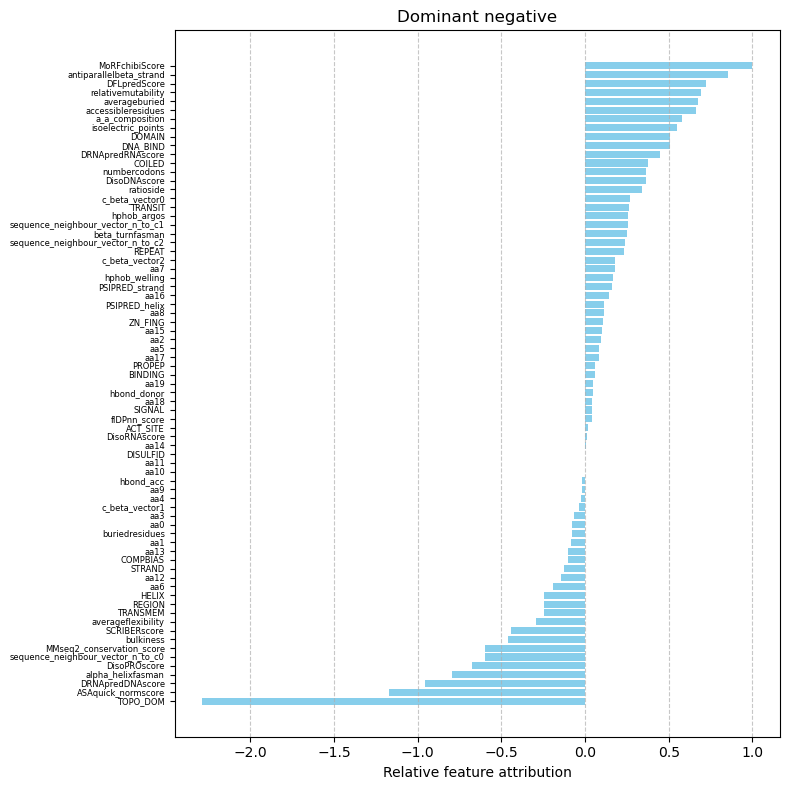

In [230]:
import matplotlib.pyplot as plt
import numpy as np

# Example lists (replace with your actual data)
names = all_feature_names_filtered
values = DN_feat_explain_score

# Normalize the values by dividing by the maximum value
max_value = max(values)
normalized_values = [v / max_value for v in values]
#normalized_values = values

# Sort the data by the normalized values
sorted_indices = np.argsort(normalized_values)
sorted_names = [names[i] for i in sorted_indices]
sorted_values = [normalized_values[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(8, 8))
plt.barh(sorted_names, sorted_values, color='skyblue')
plt.xlabel('Relative feature attribution')
plt.title('Dominant negative')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tick_params(axis='y', labelsize=6) 

# Ensure high quality plot for publication
plt.tight_layout()
plt.savefig('../res/plots/DN_featire_importance.png', dpi=300)
plt.show()


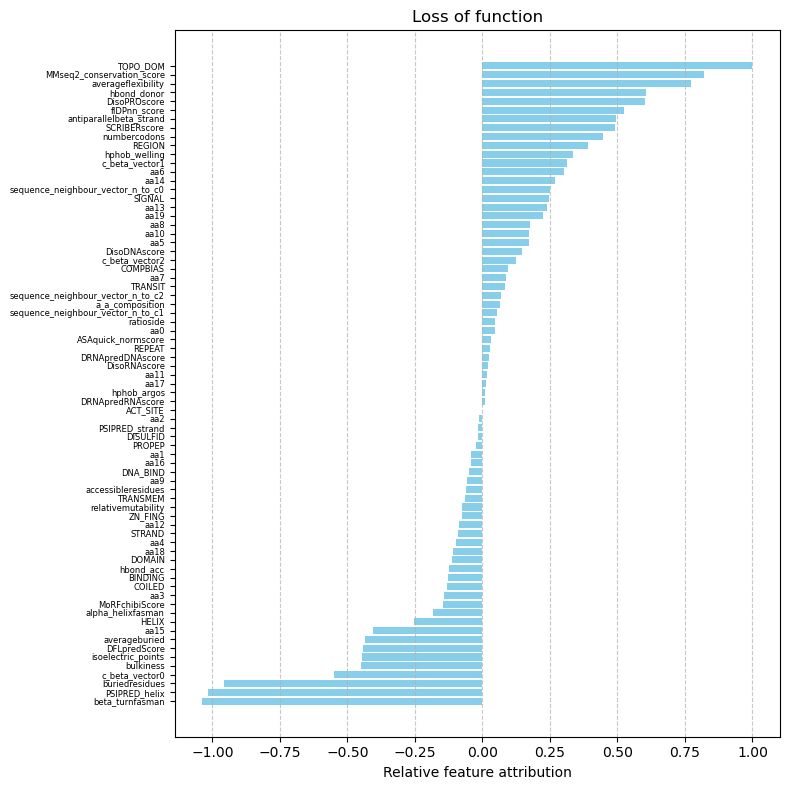

In [231]:
import matplotlib.pyplot as plt
import numpy as np

# Example lists (replace with your actual data)
names = all_feature_names_filtered
values = LOF_feat_explain_score

# Normalize the values by dividing by the maximum value
max_value = max(values)
normalized_values = [v / max_value for v in values]
#normalized_values = values

# Sort the data by the normalized values
sorted_indices = np.argsort(normalized_values)
sorted_names = [names[i] for i in sorted_indices]
sorted_values = [normalized_values[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(8, 8))
plt.barh(sorted_names, sorted_values, color='skyblue')
plt.xlabel('Relative feature attribution')
plt.title('Loss of function')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tick_params(axis='y', labelsize=6) 

# Ensure high quality plot for publication
plt.tight_layout()
plt.savefig('../res/plots/LOF_featire_importance.png', dpi=300)
plt.show()


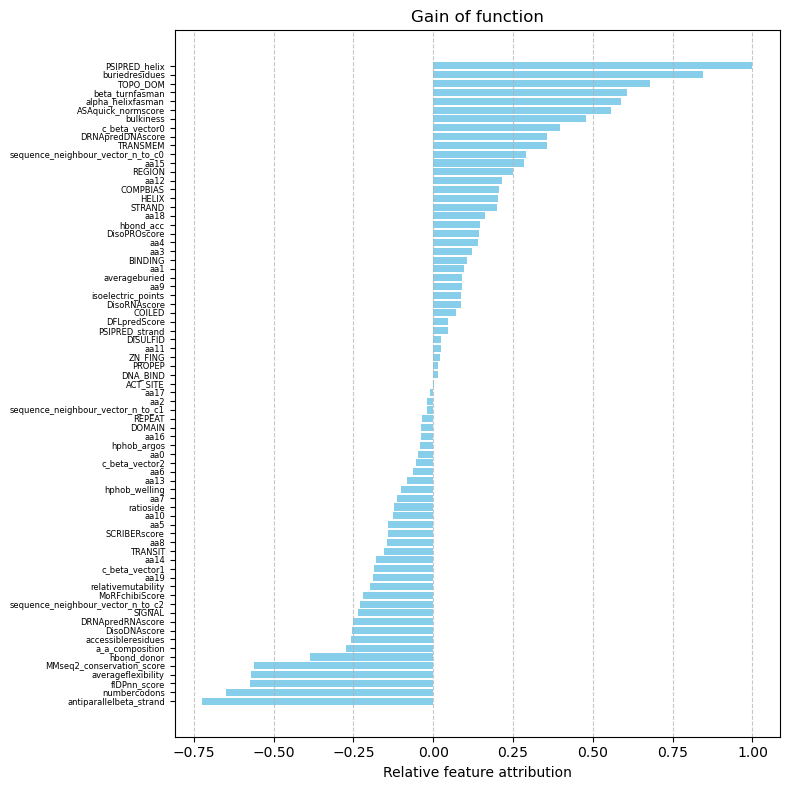

In [232]:
import matplotlib.pyplot as plt
import numpy as np

# Example lists (replace with your actual data)
names = all_feature_names_filtered
values = GOF_feat_explain_score

# Normalize the values by dividing by the maximum value
max_value = max(values)
normalized_values = [v / max_value for v in values]
#normalized_values = values

# Sort the data by the normalized values
sorted_indices = np.argsort(normalized_values)
sorted_names = [names[i] for i in sorted_indices]
sorted_values = [normalized_values[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(8, 8))
plt.barh(sorted_names, sorted_values, color='skyblue')
plt.xlabel('Relative feature attribution')
plt.title('Gain of function')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tick_params(axis='y', labelsize=6) 

# Ensure high quality plot for publication
plt.tight_layout()
plt.savefig('../res/plots/GOF_featire_importance.png', dpi=300)
plt.show()


### all AD prediction

In [135]:
MOI_preds = pd.read_csv("../res/data/all_probs_df.tsv", sep="\t")
MOI_preds

Unnamed: 0       pAD       pAR UniprotEntry
0               0  0.643632  0.445027       Q14315
1               1  0.789829  0.227079       P45985
2               2  0.448042  0.696418       Q92629
3               3  0.314086  0.789687       Q13326
4               4  0.573700  0.504479       Q9NP98
...           ...       ...       ...          ...
16472       17241  0.141597  0.471952   A0A286YF01
16473       17244  0.050174  0.909432   A0A1B0GVY4
16474       17245  0.050174  0.909432   A0A2R8YCJ5
16475       17246  0.510996  0.674568       Q96RD0
16476       17247  0.914258  0.059769       Q8NH53

[16477 rows x 4 columns]

In [136]:
MOI_preds_AD = MOI_preds[MOI_preds['pAD'] >= 0.5]
MOI_preds_AD

Unnamed: 0       pAD       pAR UniprotEntry
0               0  0.643632  0.445027       Q14315
1               1  0.789829  0.227079       P45985
4               4  0.573700  0.504479       Q9NP98
5               5  0.880119  0.172321       Q9NZV8
6               6  0.734354  0.256437       Q86SQ0
...           ...       ...       ...          ...
16453       17218  0.705317  0.151033       H3BPF8
16457       17222  0.698006  0.090743       C9JLW8
16460       17228  0.502624  0.544345       Q8WZ84
16475       17246  0.510996  0.674568       Q96RD0
16476       17247  0.914258  0.059769       Q8NH53

[8313 rows x 4 columns]

In [168]:
MOI_preds_AD['pDN'] = np.nan
MOI_preds_AD['pLOF'] = np.nan
MOI_preds_AD['pGOF'] = np.nan
MOI_preds_AD

Unnamed: 0       pAD       pAR UniprotEntry  pDN  pLOF  pGOF
0               0  0.643632  0.445027       Q14315  NaN   NaN   NaN
1               1  0.789829  0.227079       P45985  NaN   NaN   NaN
4               4  0.573700  0.504479       Q9NP98  NaN   NaN   NaN
5               5  0.880119  0.172321       Q9NZV8  NaN   NaN   NaN
6               6  0.734354  0.256437       Q86SQ0  NaN   NaN   NaN
...           ...       ...       ...          ...  ...   ...   ...
16453       17218  0.705317  0.151033       H3BPF8  NaN   NaN   NaN
16457       17222  0.698006  0.090743       C9JLW8  NaN   NaN   NaN
16460       17228  0.502624  0.544345       Q8WZ84  NaN   NaN   NaN
16475       17246  0.510996  0.674568       Q96RD0  NaN   NaN   NaN
16476       17247  0.914258  0.059769       Q8NH53  NaN   NaN   NaN

[8313 rows x 7 columns]

In [13]:
'''# creat PyG objects
all_pyg_graphs_simple_AD = []
all_graphein_features = ["amino_acid_one_hot", "expasy", 'hbond_acceptors', 'hbond_donors', 'meiler', 'sidechain_vector', 'c_beta_vector', 'sequence_neighbour_vector_n_to_c']  # AAonehot 20, expasy = 61, hbond_acceptors=1, hbond_donors=1, meiler=7, sidechain_vector=3, c_beta_vector=3, sequence_neighbour_vector_n_to_c=3

counter = 1
for uniprot_id in MOI_preds_AD['UniprotEntry'].values.tolist():

    # remove those that are not in the describe_prot database
    if uniprot_id not in describe_prot["UniprotEntry"].values:
        continue
        
    # construct a networkx graph from AlphaFold predictions
    try:
        g = construct_graph(config=config, path=(af_db_path + prefix + uniprot_id + suffix))
    except:
        continue

    add_sidechain_vector(g)
    add_beta_carbon_vector(g)
    add_sequence_neighbour_vector(g)
    
    # convert to PyG object
    g2 = from_networkx(g)

    
    # add graphein features
    g2.x = g2[all_graphein_features[0]] 
    for feature in all_graphein_features[1:]:
        g2.x = torch.cat((g2.x, g2[feature]), dim=1)

    # add describe_prot features
    for feature in describe_prot_featnames:
        try:
            temp_feature = describe_prot[describe_prot["UniprotEntry"] == uniprot_id][feature].values[0]
            temp_num_list = [float(num) for num in temp_feature.split(',')]
            temp_num_tensor = torch.tensor(temp_num_list).reshape(-1, 1)
            g2.x = torch.cat((g2.x, temp_num_tensor), dim=1)
        except:
            g2.x = torch.cat((g2.x, torch.full((len(g2.residue_name), 1), float('nan'))), dim=1)

    # add uniprot features
    for feature in uniprot_features:
        try:
            temp_feature = uniprot_clean[uniprot_clean["Entry"] == uniprot_id][feature].values[0]
            temp_num_list = [int(char) for char in temp_feature]
            temp_num_tensor = torch.tensor(temp_num_list).reshape(-1, 1)
            g2.x = torch.cat((g2.x, temp_num_tensor), dim=1)
        except:
            g2.x = torch.cat((g2.x, torch.full((len(g2.residue_name), 1), float('nan'))), dim=1)

    # add phylop features
    for feature in phylop_features:
        try:
            temp_feature = phylop[phylop["Entry"] == uniprot_id][feature].values[0]
            temp_num_list = [float(num) for num in temp_feature.split(',')]
            temp_num_tensor = torch.tensor(temp_num_list).reshape(-1, 1)
            g2.x = torch.cat((g2.x, temp_num_tensor), dim=1)
        except:
            g2.x = torch.cat((g2.x, torch.full((len(g2.residue_name), 1), float('nan'))), dim=1)


    simple_g2 = Data(
        x=g2.x,               # Node features          
        batch=g2.batch,       # Batch information
        edge_index=g2.edge_index,  # Edge connections
        name = g2.name,
        coords=g2.coords
    )
    
    all_pyg_graphs_simple_AD.append(simple_g2)
    print(f"finished {counter} proteins")
    counter += 1

    if counter % 1000 == 0:
        with open('../res/pyg_graphs/all_pyg_graphs_simple_AD.pkl', 'wb') as f:
            pickle.dump(all_pyg_graphs_simple_AD, f)
'''

Reading PDB file...         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Processing PDB dataframe... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Initializing graph...       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Constructing edges...       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

Output()

[09/15/24 22:59:50] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=434984;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=169439;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 159 total nodes                                                 ]8;id=64451;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=475705;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 4 aromatic-aromatic interactions                                ]8;id=191329;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=787939;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 58 hbond interactions.                                          ]8;id=967684;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=719606;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3 hbond interactions.                                           ]8;id=665997;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=668992;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    DEBUG    0 CYS residues found. Cannot add disulfide                             ]8;id=880337;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=460639;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#310\310]8;;\
                             interactions with fewer than two CYS residues.                                        

                    INFO     Found 649 ionic interactions.                                         ]8;id=727394;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=75518;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7923 proteins


Output()

[09/15/24 22:59:51] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=574387;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=572462;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 494 total nodes                                                 ]8;id=357708;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=659135;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 28 aromatic-aromatic interactions                               ]8;id=583073;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=554281;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 180 hbond interactions.                                         ]8;id=479731;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=719525;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 hbond interactions.                                          ]8;id=511201;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=809933;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7924 proteins


                    INFO     Found 6 disulfide interactions.                                       ]8;id=851208;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=586455;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2046 ionic interactions.                                        ]8;id=787952;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=256478;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 22:59:52] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=283357;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=127445;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 194 total nodes                                                 ]8;id=786603;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=431836;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 12 aromatic-aromatic interactions                               ]8;id=907954;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=80690;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 74 hbond interactions.                                          ]8;id=106840;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=226307;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 hbond interactions.                                          ]8;id=287823;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=417049;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 disulfide interactions.                                       ]8;id=232972;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=722894;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1119 ionic interactions.                                        ]8;id=351464;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=844730;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7925 proteins


Output()

[09/15/24 22:59:53] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=384247;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=17138;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 57 total nodes                                                  ]8;id=845141;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=220578;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 0 aromatic-aromatic interactions                                ]8;id=981179;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=381931;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=210385;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=131138;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3 hbond interactions.                                           ]8;id=953406;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=756601;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2 disulfide interactions.                                       ]8;id=209757;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=471552;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 170 ionic interactions.                                         ]8;id=340453;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=698654;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7926 proteins


finished 7927 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=780802;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=55861;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 90 total nodes                                                  ]8;id=134409;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=207594;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 2 aromatic-aromatic interactions                                ]8;id=879215;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=927979;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=632006;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=227970;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5 hbond interactions.                                           ]8;id=72444;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=857451;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    DEBUG    1 CYS residues found. Cannot add disulfide                             ]8;id=509809;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=851661;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#310\310]8;;\
                             interactions with fewer than two CYS residues.                                        

                    INFO     Found 326 ionic interactions.                                         ]8;id=640323;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=215172;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=194172;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=938727;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 233 total nodes                                                 ]8;id=676496;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=436362;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 14 aromatic-aromatic interactions                               ]8;id=187009;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=279658;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 71 hbond interactions.                                          ]8;id=746109;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=829779;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5 hbond interactions.                                           ]8;id=873094;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=968662;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    DEBUG    1 CYS residues found. Cannot add disulfide                             ]8;id=307740;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=339094;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#310\310]8;;\
                             interactions with fewer than two CYS residues.                                        

                    INFO     Found 974 ionic interactions.                                         ]8;id=505289;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=434055;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7928 proteins


Output()

[09/15/24 22:59:54] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=365093;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=882487;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 239 total nodes                                                 ]8;id=946145;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=198219;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 16 aromatic-aromatic interactions                               ]8;id=174373;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=606035;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 99 hbond interactions.                                          ]8;id=175136;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=218749;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 hbond interactions.                                          ]8;id=757702;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=888643;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 disulfide interactions.                                      ]8;id=988177;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=718671;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1657 ionic interactions.                                        ]8;id=105293;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=786718;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7929 proteins


Output()

[09/15/24 22:59:55] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=659099;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=21264;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 354 total nodes                                                 ]8;id=583798;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=230859;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 28 aromatic-aromatic interactions                               ]8;id=257410;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=211082;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 196 hbond interactions.                                         ]8;id=259462;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=835117;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 78 hbond interactions.                                          ]8;id=816010;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=710174;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 66 disulfide interactions.                                      ]8;id=471550;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=838166;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2075 ionic interactions.                                        ]8;id=221722;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=696559;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7930 proteins


Output()

[09/15/24 22:59:56] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=919751;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=178220;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 348 total nodes                                                 ]8;id=664453;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=668420;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 12 aromatic-aromatic interactions                               ]8;id=217500;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=578584;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 105 hbond interactions.                                         ]8;id=897337;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=523488;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 10 hbond interactions.                                          ]8;id=518284;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=114551;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2 disulfide interactions.                                       ]8;id=811926;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=351269;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7931 proteins


                    INFO     Found 1317 ionic interactions.                                        ]8;id=637319;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=639645;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 22:59:57] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=816987;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=415593;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 280 total nodes                                                 ]8;id=96108;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=481264;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 14 aromatic-aromatic interactions                               ]8;id=642105;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=301284;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 100 hbond interactions.                                         ]8;id=798730;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=365869;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 hbond interactions.                                          ]8;id=579509;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=851190;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 21 disulfide interactions.                                      ]8;id=333263;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=858704;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1829 ionic interactions.                                        ]8;id=672334;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=821348;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7932 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=33469;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=521170;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 580 total nodes                                                 ]8;id=961932;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=38191;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 7933 proteins


[09/15/24 22:59:58] INFO     Found: 30 aromatic-aromatic interactions                               ]8;id=590232;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=284286;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 280 hbond interactions.                                         ]8;id=671190;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=6273;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 87 hbond interactions.                                          ]8;id=891828;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=873486;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 77 disulfide interactions.                                      ]8;id=947225;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=54020;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3789 ionic interactions.                                        ]8;id=767841;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=451049;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 22:59:59] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=790884;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=491755;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 363 total nodes                                                 ]8;id=299021;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=617664;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 10 aromatic-aromatic interactions                               ]8;id=80630;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=400867;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 98 hbond interactions.                                          ]8;id=543807;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=797807;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 7 hbond interactions.                                           ]8;id=711033;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=784141;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2 disulfide interactions.                                       ]8;id=326580;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=850269;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1267 ionic interactions.                                        ]8;id=534373;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=773516;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7934 proteins


Output()

[09/15/24 23:00:00] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=781999;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=942300;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 410 total nodes                                                 ]8;id=880409;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=701571;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 20 aromatic-aromatic interactions                               ]8;id=223167;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=746443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 138 hbond interactions.                                         ]8;id=616974;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=429437;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 hbond interactions.                                          ]8;id=296320;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=495719;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 7 disulfide interactions.                                       ]8;id=755904;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=51993;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7935 proteins


                    INFO     Found 2862 ionic interactions.                                        ]8;id=892001;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=768412;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:02] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=954352;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=4217;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 490 total nodes                                                 ]8;id=267931;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=375484;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 52 aromatic-aromatic interactions                               ]8;id=741484;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=211316;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 192 hbond interactions.                                         ]8;id=156218;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=791001;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7936 proteins


                    INFO     Found 16 hbond interactions.                                          ]8;id=19558;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=480409;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5 disulfide interactions.                                       ]8;id=890558;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=36573;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3575 ionic interactions.                                        ]8;id=654723;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=989547;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:03] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=877398;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=621894;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 653 total nodes                                                 ]8;id=450897;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=939205;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 10 aromatic-aromatic interactions                               ]8;id=394139;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=773406;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 243 hbond interactions.                                         ]8;id=627582;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=162998;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 hbond interactions.                                          ]8;id=547443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=850531;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 7 disulfide interactions.                                       ]8;id=554183;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=581602;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3113 ionic interactions.                                        ]8;id=440996;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=556700;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:05] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=8372;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=507533;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 687 total nodes                                                 ]8;id=393295;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=645775;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 100 aromatic-aromatic interactions                              ]8;id=65334;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=624000;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 226 hbond interactions.                                         ]8;id=373508;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=745720;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 32 hbond interactions.                                          ]8;id=744965;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=957747;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 disulfide interactions.                                      ]8;id=554856;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=906485;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5342 ionic interactions.                                        ]8;id=109316;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=491348;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:08] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=480333;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=634966;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 462 total nodes                                                 ]8;id=774078;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=441838;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 32 aromatic-aromatic interactions                               ]8;id=506220;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=958459;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 145 hbond interactions.                                         ]8;id=951168;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=301860;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 hbond interactions.                                          ]8;id=40644;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=478974;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 disulfide interactions.                                       ]8;id=987369;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=976426;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7939 proteins


                    INFO     Found 2860 ionic interactions.                                        ]8;id=397494;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=755475;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:09] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=842475;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=414696;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 305 total nodes                                                 ]8;id=540244;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=201693;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 70 aromatic-aromatic interactions                               ]8;id=890803;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=774849;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 112 hbond interactions.                                         ]8;id=702090;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=390663;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 hbond interactions.                                          ]8;id=120038;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=111845;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=500899;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=434887;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2464 ionic interactions.                                        ]8;id=436534;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=745529;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7940 proteins


Output()

[09/15/24 23:00:10] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=822561;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=82653;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 361 total nodes                                                 ]8;id=87104;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=37857;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 72 aromatic-aromatic interactions                               ]8;id=796767;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=239547;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 151 hbond interactions.                                         ]8;id=393337;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=827955;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 34 hbond interactions.                                          ]8;id=101083;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=603950;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 disulfide interactions.                                      ]8;id=886223;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=669728;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7941 proteins


                    INFO     Found 2803 ionic interactions.                                        ]8;id=607286;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=836862;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:11] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=100004;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=787731;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 156 total nodes                                                 ]8;id=674506;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=725176;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 8 aromatic-aromatic interactions                                ]8;id=160825;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=488053;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 75 hbond interactions.                                          ]8;id=61949;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=310511;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 hbond interactions.                                          ]8;id=75947;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=559433;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=356838;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=992624;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1142 ionic interactions.                                        ]8;id=117882;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=678158;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7942 proteins


Output()

[09/15/24 23:00:12] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=554902;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=684405;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 572 total nodes                                                 ]8;id=896327;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=823502;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 7943 proteins


                    INFO     Found: 52 aromatic-aromatic interactions                               ]8;id=677803;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=734910;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 246 hbond interactions.                                         ]8;id=30627;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=552036;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 56 hbond interactions.                                          ]8;id=93353;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=72043;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 34 disulfide interactions.                                      ]8;id=886271;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=885626;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3922 ionic interactions.                                        ]8;id=128548;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=752772;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:13] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=784783;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=571797;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 327 total nodes                                                 ]8;id=426513;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=711718;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 60 aromatic-aromatic interactions                               ]8;id=26914;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=272521;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 122 hbond interactions.                                         ]8;id=442018;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=181704;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=488627;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=800316;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=527174;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=8242;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2562 ionic interactions.                                        ]8;id=824432;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=420067;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7944 proteins


Output()

[09/15/24 23:00:14] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=778203;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=343990;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 268 total nodes                                                 ]8;id=784361;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=211468;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 4 aromatic-aromatic interactions                                ]8;id=765063;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=713170;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 89 hbond interactions.                                          ]8;id=482173;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=311473;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 hbond interactions.                                          ]8;id=619002;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=622759;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 disulfide interactions.                                       ]8;id=332703;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=370176;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1014 ionic interactions.                                        ]8;id=113901;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=159516;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7945 proteins


Output()

[09/15/24 23:00:15] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=345389;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=215323;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 505 total nodes                                                 ]8;id=257353;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=530060;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 84 aromatic-aromatic interactions                               ]8;id=227211;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=338778;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 215 hbond interactions.                                         ]8;id=353128;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=325416;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 38 hbond interactions.                                          ]8;id=939262;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=857530;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7946 proteins


                    INFO     Found 34 disulfide interactions.                                      ]8;id=739184;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=948302;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3724 ionic interactions.                                        ]8;id=19071;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=899028;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:17] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=910993;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=856867;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 714 total nodes                                                 ]8;id=967468;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=89835;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 166 aromatic-aromatic interactions                              ]8;id=711835;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=386547;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 312 hbond interactions.                                         ]8;id=370660;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=305204;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=204444;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=656128;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 disulfide interactions.                                      ]8;id=784801;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=632185;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5933 ionic interactions.                                        ]8;id=364106;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=40983;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:19] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=913297;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=488892;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 719 total nodes                                                 ]8;id=928628;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=829973;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=897918;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=151697;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 291 hbond interactions.                                         ]8;id=439750;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=826460;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 45 hbond interactions.                                          ]8;id=696493;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=702141;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 32 disulfide interactions.                                      ]8;id=821737;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=954175;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:00:20] INFO     Found 4579 ionic interactions.                                        ]8;id=366633;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=887343;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

finished 7949 proteins


[09/15/24 23:00:22] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=980532;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=474144;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 416 total nodes                                                 ]8;id=443170;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=355419;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 4 aromatic-aromatic interactions                                ]8;id=530417;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=480435;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 180 hbond interactions.                                         ]8;id=257640;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=629238;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 hbond interactions.                                          ]8;id=258243;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=73880;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 6 disulfide interactions.                                       ]8;id=740490;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=330635;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2277 ionic interactions.                                        ]8;id=269047;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=834079;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:23] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=345955;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=638243;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1182 total nodes                                                ]8;id=823301;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=528238;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 46 aromatic-aromatic interactions                               ]8;id=117700;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=360446;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 393 hbond interactions.                                         ]8;id=565489;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=605048;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 48 hbond interactions.                                          ]8;id=89184;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=851181;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 disulfide interactions.                                      ]8;id=307061;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=781972;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:00:24] INFO     Found 5955 ionic interactions.                                        ]8;id=647585;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=439330;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:29] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=159218;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=945150;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 806 total nodes                                                 ]8;id=279748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=700658;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 154 aromatic-aromatic interactions                              ]8;id=665625;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=50878;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 324 hbond interactions.                                         ]8;id=693020;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=11612;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 55 hbond interactions.                                          ]8;id=718684;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=273678;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 disulfide interactions.                                      ]8;id=920167;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=103980;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 6292 ionic interactions.                                        ]8;id=886774;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=949658;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:32] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=179254;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=104835;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 542 total nodes                                                 ]8;id=657015;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=40288;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 7952 proteins


                    INFO     Found: 16 aromatic-aromatic interactions                               ]8;id=975058;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=541026;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 282 hbond interactions.                                         ]8;id=14127;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=428523;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 40 hbond interactions.                                          ]8;id=940906;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=824310;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 21 disulfide interactions.                                      ]8;id=173534;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=229231;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3293 ionic interactions.                                        ]8;id=893750;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=812303;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:33] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=525268;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=988282;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 584 total nodes                                                 ]8;id=164421;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=869736;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 7953 proteins


                    INFO     Found: 22 aromatic-aromatic interactions                               ]8;id=475508;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=621278;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 303 hbond interactions.                                         ]8;id=771782;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=892948;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 42 hbond interactions.                                          ]8;id=47888;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=363182;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 disulfide interactions.                                      ]8;id=911546;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=690970;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3644 ionic interactions.                                        ]8;id=480706;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=739270;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:35] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=146862;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=221942;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 317 total nodes                                                 ]8;id=147249;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=395873;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 76 aromatic-aromatic interactions                               ]8;id=497187;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=874087;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 122 hbond interactions.                                         ]8;id=640032;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=231030;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 hbond interactions.                                          ]8;id=894357;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=868673;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=110522;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=230402;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2639 ionic interactions.                                        ]8;id=115308;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=595092;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7954 proteins


Output()

[09/15/24 23:00:36] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=478511;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=911582;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 315 total nodes                                                 ]8;id=918669;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=885913;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 66 aromatic-aromatic interactions                               ]8;id=969437;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=569447;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 121 hbond interactions.                                         ]8;id=926066;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=917088;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 hbond interactions.                                          ]8;id=137591;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=827900;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=8498;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=466469;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2600 ionic interactions.                                        ]8;id=327259;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=702075;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7955 proteins


Output()

[09/15/24 23:00:37] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=991682;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=326076;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 330 total nodes                                                 ]8;id=25542;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=431603;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 58 aromatic-aromatic interactions                               ]8;id=400171;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=86652;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 132 hbond interactions.                                         ]8;id=746579;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=215924;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=26224;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=480610;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=205908;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=19551;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2623 ionic interactions.                                        ]8;id=62674;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=467730;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7956 proteins


Output()

[09/15/24 23:00:38] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=689241;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=448573;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 308 total nodes                                                 ]8;id=905517;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=679122;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=3693;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=892843;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 107 hbond interactions.                                         ]8;id=251616;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=373380;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 21 hbond interactions.                                          ]8;id=64443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=134598;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 disulfide interactions.                                      ]8;id=348110;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=712161;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2539 ionic interactions.                                        ]8;id=707048;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=348541;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7957 proteins


Output()

[09/15/24 23:00:39] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=778512;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=61031;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 303 total nodes                                                 ]8;id=32577;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=497359;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 68 aromatic-aromatic interactions                               ]8;id=853942;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=972095;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 120 hbond interactions.                                         ]8;id=491435;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=627838;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=342831;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=902411;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=497186;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=308971;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2519 ionic interactions.                                        ]8;id=676890;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=150731;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:40] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=842590;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=188615;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1454 total nodes                                                ]8;id=696109;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=444904;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 170 aromatic-aromatic interactions                              ]8;id=40999;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=496278;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 620 hbond interactions.                                         ]8;id=489125;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=693310;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 78 hbond interactions.                                          ]8;id=190362;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=365595;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 47 disulfide interactions.                                      ]8;id=321741;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=436225;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:00:41] INFO     Found 11427 ionic interactions.                                       ]8;id=635873;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=690507;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:48] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=611245;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=490351;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 404 total nodes                                                 ]8;id=859741;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=695274;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 68 aromatic-aromatic interactions                               ]8;id=109242;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=501316;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 139 hbond interactions.                                         ]8;id=909094;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=841850;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=349716;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=13680;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 19 disulfide interactions.                                      ]8;id=234707;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=733099;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7960 proteins


                    INFO     Found 2818 ionic interactions.                                        ]8;id=504651;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=609160;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:49] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=738205;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=350920;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 250 total nodes                                                 ]8;id=939616;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=381103;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 26 aromatic-aromatic interactions                               ]8;id=598956;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=697519;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 91 hbond interactions.                                          ]8;id=115613;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=891947;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 hbond interactions.                                          ]8;id=58059;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=306946;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 7 disulfide interactions.                                       ]8;id=574777;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=848186;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1393 ionic interactions.                                        ]8;id=858939;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=128190;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7961 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=173970;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=543178;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 727 total nodes                                                 ]8;id=770984;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=588603;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:00:50] INFO     Found: 36 aromatic-aromatic interactions                               ]8;id=610527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=725654;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 239 hbond interactions.                                         ]8;id=817026;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=324761;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 32 hbond interactions.                                          ]8;id=284376;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=496093;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=478543;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=725748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4735 ionic interactions.                                        ]8;id=252089;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=204001;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:52] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=269489;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=479818;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=704470;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=53241;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 74 aromatic-aromatic interactions                               ]8;id=766313;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=767856;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 109 hbond interactions.                                         ]8;id=749903;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=684800;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 21 hbond interactions.                                          ]8;id=431254;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=385223;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=906585;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=458902;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2541 ionic interactions.                                        ]8;id=613121;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=24224;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7963 proteins


Output()

[09/15/24 23:00:53] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=28492;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=52970;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=600137;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=655063;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 46 aromatic-aromatic interactions                               ]8;id=787602;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=450783;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 130 hbond interactions.                                         ]8;id=152162;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=782933;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 34 hbond interactions.                                          ]8;id=357769;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=789227;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=637844;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=303136;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2571 ionic interactions.                                        ]8;id=566740;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=358443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7964 proteins


Output()

[09/15/24 23:00:54] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=674674;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=807745;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 317 total nodes                                                 ]8;id=251631;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=837914;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 26 aromatic-aromatic interactions                               ]8;id=730284;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=154999;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 129 hbond interactions.                                         ]8;id=759143;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=235563;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 hbond interactions.                                          ]8;id=674022;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=281111;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=895180;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=703904;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2554 ionic interactions.                                        ]8;id=534840;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=46611;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7965 proteins


Output()

[09/15/24 23:00:55] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=198568;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=749184;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 326 total nodes                                                 ]8;id=554565;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=633006;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 46 aromatic-aromatic interactions                               ]8;id=828448;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=83699;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 108 hbond interactions.                                         ]8;id=290890;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=242941;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=133565;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=472729;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=587251;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=94445;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2562 ionic interactions.                                        ]8;id=316992;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=791078;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7966 proteins


Output()

[09/15/24 23:00:56] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=958838;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=106200;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=723406;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=32407;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 74 aromatic-aromatic interactions                               ]8;id=790302;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=56363;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 106 hbond interactions.                                         ]8;id=510268;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=590172;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=561317;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=89450;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=405497;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=270723;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2482 ionic interactions.                                        ]8;id=600993;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=69011;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7967 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=120990;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=603891;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 362 total nodes                                                 ]8;id=234474;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=604232;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 26 aromatic-aromatic interactions                               ]8;id=228851;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=144742;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 108 hbond interactions.                                         ]8;id=396910;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=20314;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 hbond interactions.                                          ]8;id=896372;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=299043;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 disulfide interactions.                                      ]8;id=12868;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=227648;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:00:57] INFO     Found 2439 ionic interactions.                                        ]8;id=838236;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=979504;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7968 proteins


Output()

[09/15/24 23:00:58] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=149231;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=430361;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 106 total nodes                                                 ]8;id=297834;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=256727;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 0 aromatic-aromatic interactions                                ]8;id=600787;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=926181;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 44 hbond interactions.                                          ]8;id=510884;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=823617;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1 hbond interactions.                                           ]8;id=314396;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=884753;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    DEBUG    0 CYS residues found. Cannot add disulfide                             ]8;id=238215;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=694200;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#310\310]8;;\
                             interactions with fewer than two CYS residues.                                        

                    INFO     Found 263 ionic interactions.                                         ]8;id=422682;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=321333;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7969 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=278247;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=736025;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 517 total nodes                                                 ]8;id=533149;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=562509;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 60 aromatic-aromatic interactions                               ]8;id=890287;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=491580;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

finished 7970 proteins


                    INFO     Found 53 hbond interactions.                                          ]8;id=679724;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=10127;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 disulfide interactions.                                      ]8;id=856586;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=632930;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2885 ionic interactions.                                        ]8;id=788270;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=716269;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:00:59] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=291105;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=127349;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 187 total nodes                                                 ]8;id=355051;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=452401;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:01:00] INFO     Found: 0 aromatic-aromatic interactions                                ]8;id=638381;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=635180;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 89 hbond interactions.                                          ]8;id=251248;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=484353;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=737720;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=322761;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 disulfide interactions.                                      ]8;id=375585;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=862040;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 964 ionic interactions.                                         ]8;id=680381;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=453082;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7971 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=849480;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=736024;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 309 total nodes                                                 ]8;id=207624;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=614144;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=154199;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=615090;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 116 hbond interactions.                                         ]8;id=331379;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=573749;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=298148;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=147879;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=567043;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=21152;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2560 ionic interactions.                                        ]8;id=112382;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=250773;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7972 proteins


Output()

[09/15/24 23:01:01] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=22639;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=667927;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 187 total nodes                                                 ]8;id=860472;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=284572;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 16 aromatic-aromatic interactions                               ]8;id=77047;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=264384;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 84 hbond interactions.                                          ]8;id=191993;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=914227;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 hbond interactions.                                          ]8;id=540088;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=27219;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 disulfide interactions.                                      ]8;id=561802;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=816557;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1264 ionic interactions.                                        ]8;id=815546;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=204484;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7973 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=422268;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=290366;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 329 total nodes                                                 ]8;id=762243;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=925755;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 14 aromatic-aromatic interactions                               ]8;id=836838;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=251501;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 122 hbond interactions.                                         ]8;id=111321;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=198221;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 hbond interactions.                                          ]8;id=378013;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=905863;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4 disulfide interactions.                                       ]8;id=866475;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=677994;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7974 proteins


[09/15/24 23:01:02] INFO     Found 2439 ionic interactions.                                        ]8;id=323169;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=783489;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=433985;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=774603;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 665 total nodes                                                 ]8;id=816537;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=973616;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:01:03] INFO     Found: 50 aromatic-aromatic interactions                               ]8;id=148958;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=133604;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 290 hbond interactions.                                         ]8;id=846035;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=798733;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 hbond interactions.                                          ]8;id=372527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=494119;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=289725;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=62187;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5135 ionic interactions.                                        ]8;id=977660;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=892413;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:05] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=532238;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=843786;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 369 total nodes                                                 ]8;id=208424;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=437328;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 28 aromatic-aromatic interactions                               ]8;id=59351;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=122145;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 133 hbond interactions.                                         ]8;id=682947;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=361210;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=365949;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=563332;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 disulfide interactions.                                      ]8;id=657908;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=321669;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2633 ionic interactions.                                        ]8;id=833913;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=147495;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7976 proteins


Output()

[09/15/24 23:01:06] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=88366;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=901637;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=963350;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=167196;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=913793;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=87940;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 122 hbond interactions.                                         ]8;id=892143;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=671249;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=677629;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=872081;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=902401;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=947831;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2436 ionic interactions.                                        ]8;id=365097;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=275512;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7977 proteins


Output()

[09/15/24 23:01:07] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=49351;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=109359;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 117 total nodes                                                 ]8;id=84170;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=167434;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 8 aromatic-aromatic interactions                                ]8;id=583757;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=330424;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 48 hbond interactions.                                          ]8;id=289024;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=13640;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3 hbond interactions.                                           ]8;id=674459;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=327368;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    DEBUG    1 CYS residues found. Cannot add disulfide                             ]8;id=449246;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=170712;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#310\310]8;;\
                             interactions with fewer than two CYS residues.                                        

                    INFO     Found 588 ionic interactions.                                         ]8;id=702430;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=813093;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7978 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=822608;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=922122;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 486 total nodes                                                 ]8;id=343348;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=470539;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 44 aromatic-aromatic interactions                               ]8;id=776787;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=452766;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 204 hbond interactions.                                         ]8;id=755983;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=823605;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 56 hbond interactions.                                          ]8;id=32442;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=274557;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7979 proteins


                    INFO     Found 28 disulfide interactions.                                      ]8;id=412304;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=772817;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2732 ionic interactions.                                        ]8;id=172626;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=475049;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:08] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=619616;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=436022;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 426 total nodes                                                 ]8;id=599823;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=59832;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:01:09] INFO     Found: 50 aromatic-aromatic interactions                               ]8;id=327810;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=881410;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 172 hbond interactions.                                         ]8;id=659142;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=213982;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 53 hbond interactions.                                          ]8;id=373384;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=43352;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 disulfide interactions.                                      ]8;id=185486;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=93474;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7980 proteins


                    INFO     Found 2460 ionic interactions.                                        ]8;id=388857;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=750135;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:10] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=715056;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=103303;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 357 total nodes                                                 ]8;id=943706;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=913316;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=830561;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=316688;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 134 hbond interactions.                                         ]8;id=543549;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=181599;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=820503;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=78950;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 disulfide interactions.                                      ]8;id=299216;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=337304;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2785 ionic interactions.                                        ]8;id=844758;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=365749;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7981 proteins


Output()

[09/15/24 23:01:11] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=350718;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=367648;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 219 total nodes                                                 ]8;id=884480;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=658658;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 4 aromatic-aromatic interactions                                ]8;id=718151;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=704623;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 76 hbond interactions.                                          ]8;id=287432;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=185843;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 hbond interactions.                                          ]8;id=400363;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=259663;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 7 disulfide interactions.                                       ]8;id=258831;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=253555;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 998 ionic interactions.                                         ]8;id=8447;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=326054;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7982 proteins


Output()

[09/15/24 23:01:12] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=145004;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=205735;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 426 total nodes                                                 ]8;id=568005;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=387936;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 18 aromatic-aromatic interactions                               ]8;id=464787;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=822145;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 189 hbond interactions.                                         ]8;id=286777;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=597919;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 19 hbond interactions.                                          ]8;id=195798;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=667366;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=644690;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=703377;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2956 ionic interactions.                                        ]8;id=185980;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=127562;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:13] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=308974;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=924780;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 480 total nodes                                                 ]8;id=783068;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=682307;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 6 aromatic-aromatic interactions                                ]8;id=787625;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=516525;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 146 hbond interactions.                                         ]8;id=934982;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=217023;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 7 hbond interactions.                                           ]8;id=386834;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=188100;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    DEBUG    1 CYS residues found. Cannot add disulfide                             ]8;id=820568;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=8267;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#310\310]8;;\
                             interactions with fewer than two CYS residues.                                        

finished 7984 proteins


                    INFO     Found 1658 ionic interactions.                                        ]8;id=327175;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=96088;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:14] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=200971;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=51593;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1349 total nodes                                                ]8;id=861935;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=478651;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=751673;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=454617;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 459 hbond interactions.                                         ]8;id=506392;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=117857;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 48 hbond interactions.                                          ]8;id=583549;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=341726;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 disulfide interactions.                                      ]8;id=340391;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=385221;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:21] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=387337;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=11006;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 955 total nodes                                                 ]8;id=906878;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=135478;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 50 aromatic-aromatic interactions                               ]8;id=142524;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=551225;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 394 hbond interactions.                                         ]8;id=870785;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=171932;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 52 hbond interactions.                                          ]8;id=509836;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=490936;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 40 disulfide interactions.                                      ]8;id=804210;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=657511;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 6810 ionic interactions.                                        ]8;id=143264;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=675140;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:25] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=301174;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=171146;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 956 total nodes                                                 ]8;id=252723;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=83796;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 68 aromatic-aromatic interactions                               ]8;id=171102;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=354378;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 411 hbond interactions.                                         ]8;id=643291;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=536847;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 49 hbond interactions.                                          ]8;id=744996;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=265378;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 35 disulfide interactions.                                      ]8;id=160468;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=946481;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 6879 ionic interactions.                                        ]8;id=280482;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=447161;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:29] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=821597;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=76129;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 325 total nodes                                                 ]8;id=109900;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=111550;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=698407;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=620328;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 133 hbond interactions.                                         ]8;id=357456;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=756234;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 21 hbond interactions.                                          ]8;id=410429;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=57768;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 disulfide interactions.                                      ]8;id=416941;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=912687;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2584 ionic interactions.                                        ]8;id=711756;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=333083;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7988 proteins


Output()

[09/15/24 23:01:30] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=724565;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=861902;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 325 total nodes                                                 ]8;id=476276;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=246352;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 42 aromatic-aromatic interactions                               ]8;id=312014;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=513757;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 128 hbond interactions.                                         ]8;id=826719;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=784073;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 hbond interactions.                                          ]8;id=175117;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=27762;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=736889;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=703117;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2676 ionic interactions.                                        ]8;id=333362;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=96761;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7989 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=920710;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=239193;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 365 total nodes                                                 ]8;id=515824;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=711103;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:01:31] INFO     Found: 10 aromatic-aromatic interactions                               ]8;id=798106;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=520880;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 133 hbond interactions.                                         ]8;id=447499;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=907012;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 hbond interactions.                                          ]8;id=554753;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=807462;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 6 disulfide interactions.                                       ]8;id=852557;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=780507;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1339 ionic interactions.                                        ]8;id=50423;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=454128;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:32] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=85241;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=52224;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 188 total nodes                                                 ]8;id=805776;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=891595;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 2 aromatic-aromatic interactions                                ]8;id=36421;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=608107;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 45 hbond interactions.                                          ]8;id=169195;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=395586;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 hbond interactions.                                           ]8;id=22068;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=51698;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 6 disulfide interactions.                                       ]8;id=751282;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=320205;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 696 ionic interactions.                                         ]8;id=414207;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=808212;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 7991 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=658367;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=998494;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1008 total nodes                                                ]8;id=467025;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=565710;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 2 aromatic-aromatic interactions                                ]8;id=266148;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=367245;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 372 hbond interactions.                                         ]8;id=642306;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=421312;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 34 hbond interactions.                                          ]8;id=362822;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=229384;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=187146;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=533653;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:01:33] INFO     Found 2912 ionic interactions.                                        ]8;id=537715;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=73456;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:36] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=950881;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=760434;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1214 total nodes                                                ]8;id=593477;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=584708;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:01:37] INFO     Found: 2 aromatic-aromatic interactions                                ]8;id=391847;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=495748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 468 hbond interactions.                                         ]8;id=915748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=12157;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 50 hbond interactions.                                          ]8;id=167662;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=534275;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 disulfide interactions.                                      ]8;id=157644;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=67687;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5434 ionic interactions.                                        ]8;id=717323;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=866338;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:01:42] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=399977;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=341018;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 538 total nodes                                                 ]8;id=665319;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=625626;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 7994 proteins


                    INFO     Found: 40 aromatic-aromatic interactions                               ]8;id=70220;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=762670;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 188 hbond interactions.                                         ]8;id=201873;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=365408;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Output()

[09/15/24 23:04:23] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=91881;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=496541;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 308 total nodes                                                 ]8;id=83165;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=233961;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 18 aromatic-aromatic interactions                               ]8;id=241435;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=458260;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 98 hbond interactions.                                          ]8;id=319866;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=705067;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 hbond interactions.                                          ]8;id=800372;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=583903;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=6309;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=232431;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1471 ionic interactions.                                        ]8;id=629391;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=122925;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8086 proteins


Output()

[09/15/24 23:04:24] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=971130;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=560853;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=10953;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=211531;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=88044;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=735018;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 101 hbond interactions.                                         ]8;id=882920;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=547956;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=885535;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=803067;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 disulfide interactions.                                      ]8;id=881428;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=503960;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2484 ionic interactions.                                        ]8;id=445415;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=535277;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8087 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=599687;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=638697;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 311 total nodes                                                 ]8;id=67605;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=336691;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=850505;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=96084;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 130 hbond interactions.                                         ]8;id=947015;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=186004;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=256520;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=655111;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 disulfide interactions.                                      ]8;id=71906;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=622705;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:04:25] INFO     Found 2522 ionic interactions.                                        ]8;id=799335;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=607507;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8088 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=925357;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=190051;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 324 total nodes                                                 ]8;id=152883;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=824880;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 66 aromatic-aromatic interactions                               ]8;id=27691;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=770500;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 106 hbond interactions.                                         ]8;id=344154;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=915784;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=844582;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=744532;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=967408;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=495415;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2651 ionic interactions.                                        ]8;id=676041;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=387715;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8089 proteins


Output()

[09/15/24 23:04:26] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=824378;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=981417;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 332 total nodes                                                 ]8;id=475676;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=684091;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8090 proteins


[09/15/24 23:04:27] INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=287178;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=157320;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 121 hbond interactions.                                         ]8;id=414681;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=446553;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 hbond interactions.                                          ]8;id=435691;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=806104;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 disulfide interactions.                                      ]8;id=626359;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=797975;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2663 ionic interactions.                                        ]8;id=9662;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=41045;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:04:28] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=32869;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=803208;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 309 total nodes                                                 ]8;id=837852;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=31623;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 66 aromatic-aromatic interactions                               ]8;id=719540;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=324818;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 132 hbond interactions.                                         ]8;id=379977;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=959409;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 hbond interactions.                                          ]8;id=447184;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=950599;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=748922;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=729151;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2449 ionic interactions.                                        ]8;id=741399;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=817846;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8091 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=344020;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=719423;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 313 total nodes                                                 ]8;id=388753;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=942881;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 30 aromatic-aromatic interactions                               ]8;id=153218;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=819854;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 127 hbond interactions.                                         ]8;id=758985;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=402642;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=6407;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=135800;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=83140;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=603551;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2553 ionic interactions.                                        ]8;id=59553;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=982944;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8092 proteins


Output()

[09/15/24 23:04:29] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=280251;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=143535;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 309 total nodes                                                 ]8;id=891126;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=994468;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 42 aromatic-aromatic interactions                               ]8;id=47845;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=136294;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 147 hbond interactions.                                         ]8;id=751822;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=839907;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=343784;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=630702;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=148813;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=213097;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2513 ionic interactions.                                        ]8;id=479038;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=999585;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8093 proteins


Output()

[09/15/24 23:04:30] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=776523;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=294004;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=398372;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=887111;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=807030;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=44632;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 135 hbond interactions.                                         ]8;id=564488;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=242985;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 hbond interactions.                                          ]8;id=480254;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=956729;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=617567;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=788705;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2565 ionic interactions.                                        ]8;id=638021;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=510358;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8094 proteins


Output()

[09/15/24 23:04:31] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=701178;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=453526;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 305 total nodes                                                 ]8;id=434448;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=553186;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8095 proteins


                    INFO     Found: 60 aromatic-aromatic interactions                               ]8;id=19239;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=832261;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 149 hbond interactions.                                         ]8;id=450878;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=417671;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=178558;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=491410;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=316097;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=907573;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2516 ionic interactions.                                        ]8;id=816189;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=451033;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:04:32] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=56686;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=375107;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 318 total nodes                                                 ]8;id=522867;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=25755;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=734928;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=248690;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 114 hbond interactions.                                         ]8;id=925968;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=634056;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 hbond interactions.                                          ]8;id=107355;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=575631;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=713644;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=285366;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2450 ionic interactions.                                        ]8;id=614433;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=464006;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8096 proteins


Output()

[09/15/24 23:04:33] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=596901;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=884269;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 320 total nodes                                                 ]8;id=345474;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=830295;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 48 aromatic-aromatic interactions                               ]8;id=752898;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=791812;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 132 hbond interactions.                                         ]8;id=468044;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=293686;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=773419;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=810382;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=884897;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=863481;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2703 ionic interactions.                                        ]8;id=733693;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=860301;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8097 proteins


Output()

[09/15/24 23:04:34] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=216949;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=651033;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=196501;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=377895;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=889619;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=462535;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 135 hbond interactions.                                         ]8;id=377319;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=540458;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=915056;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=992632;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=423066;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=471022;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2574 ionic interactions.                                        ]8;id=668296;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=141476;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8098 proteins


Output()

[09/15/24 23:04:35] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=662023;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=406040;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 310 total nodes                                                 ]8;id=663427;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=813183;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=72437;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=972571;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 104 hbond interactions.                                         ]8;id=211386;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=59845;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=472518;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=958345;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=721397;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=988270;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2456 ionic interactions.                                        ]8;id=316767;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=72918;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8099 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=458525;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=440763;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 310 total nodes                                                 ]8;id=358838;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=697708;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8100 proteins


[09/15/24 23:04:36] INFO     Found: 62 aromatic-aromatic interactions                               ]8;id=561312;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=156640;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 120 hbond interactions.                                         ]8;id=645917;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=955810;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 hbond interactions.                                          ]8;id=797900;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=709418;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 disulfide interactions.                                      ]8;id=780303;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=951262;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2591 ionic interactions.                                        ]8;id=67571;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=223015;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:04:37] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=334946;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=882927;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 328 total nodes                                                 ]8;id=559169;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=617007;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 68 aromatic-aromatic interactions                               ]8;id=817874;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=719141;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 129 hbond interactions.                                         ]8;id=566969;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=45660;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 hbond interactions.                                          ]8;id=231767;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=358032;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=123229;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=443024;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2655 ionic interactions.                                        ]8;id=783204;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=896707;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8101 proteins


Output()

[09/15/24 23:04:38] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=272693;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=260765;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 315 total nodes                                                 ]8;id=891405;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=302714;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 44 aromatic-aromatic interactions                               ]8;id=772768;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=883937;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 120 hbond interactions.                                         ]8;id=559388;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=736651;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=662281;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=378209;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=41466;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=104169;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2644 ionic interactions.                                        ]8;id=274152;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=593814;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8102 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=377986;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=551241;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 313 total nodes                                                 ]8;id=881502;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=523051;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 44 aromatic-aromatic interactions                               ]8;id=670455;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=69035;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 122 hbond interactions.                                         ]8;id=86246;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=191869;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8103 proteins


                    INFO     Found 28 hbond interactions.                                          ]8;id=115067;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=910063;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:04:39] INFO     Found 2603 ionic interactions.                                        ]8;id=554487;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=366396;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=145767;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=383661;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 328 total nodes                                                 ]8;id=643893;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=561236;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=207289;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=75619;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 134 hbond interactions.                                         ]8;id=640853;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=301322;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=570266;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=225246;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=783600;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=969490;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2614 ionic interactions.                                        ]8;id=74476;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=841760;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8104 proteins


Output()

[09/15/24 23:04:40] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=253559;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=719197;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 317 total nodes                                                 ]8;id=573097;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=225843;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8105 proteins


[09/15/24 23:04:41] INFO     Found: 44 aromatic-aromatic interactions                               ]8;id=806832;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=587572;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 101 hbond interactions.                                         ]8;id=212538;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=911443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 hbond interactions.                                          ]8;id=498406;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=194310;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 disulfide interactions.                                      ]8;id=108620;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=468674;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2527 ionic interactions.                                        ]8;id=606345;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=42088;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=492520;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=646557;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 309 total nodes                                                 ]8;id=394337;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=923293;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 60 aromatic-aromatic interactions                               ]8;id=50241;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=929126;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 129 hbond interactions.                                         ]8;id=593315;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=839624;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=238667;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=442244;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=158141;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=359047;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2542 ionic interactions.                                        ]8;id=26347;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=120343;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8106 proteins


Output()

[09/15/24 23:04:42] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=751381;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=54415;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 310 total nodes                                                 ]8;id=458366;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=547438;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 60 aromatic-aromatic interactions                               ]8;id=306454;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=519953;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 112 hbond interactions.                                         ]8;id=407275;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=429744;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=479664;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=675392;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=148156;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=72303;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2494 ionic interactions.                                        ]8;id=874211;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=12651;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8107 proteins


Output()

[09/15/24 23:04:43] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=103509;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=627509;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=950867;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=991443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=64673;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=403919;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 140 hbond interactions.                                         ]8;id=16074;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=551724;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=962498;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=525568;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=209002;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=310836;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2604 ionic interactions.                                        ]8;id=129973;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=154979;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8108 proteins


Output()

[09/15/24 23:04:44] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=164706;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=148672;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=247145;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=386314;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 60 aromatic-aromatic interactions                               ]8;id=123913;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=152586;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 122 hbond interactions.                                         ]8;id=755546;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=597526;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 hbond interactions.                                          ]8;id=21303;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=81648;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=979568;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=521557;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2572 ionic interactions.                                        ]8;id=361515;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=90725;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8109 proteins


Output()

[09/15/24 23:04:45] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=410613;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=997960;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 315 total nodes                                                 ]8;id=162031;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=545517;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 48 aromatic-aromatic interactions                               ]8;id=325119;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=880363;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 122 hbond interactions.                                         ]8;id=811925;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=323610;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 hbond interactions.                                          ]8;id=941224;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=308419;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=867405;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=530530;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2505 ionic interactions.                                        ]8;id=890523;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=425544;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:04:46] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=863256;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=606733;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 322 total nodes                                                 ]8;id=283231;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=98802;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=230877;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=904611;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 132 hbond interactions.                                         ]8;id=306512;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=776351;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=280723;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=936848;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 disulfide interactions.                                      ]8;id=4497;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=14139;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2658 ionic interactions.                                        ]8;id=975155;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=897989;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8111 proteins


Output()

[09/15/24 23:04:47] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=881422;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=922306;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 310 total nodes                                                 ]8;id=347444;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=564400;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 68 aromatic-aromatic interactions                               ]8;id=610501;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=918955;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 107 hbond interactions.                                         ]8;id=964923;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=409561;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 hbond interactions.                                          ]8;id=680635;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=434224;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=966353;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=290115;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2497 ionic interactions.                                        ]8;id=798140;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=86133;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8112 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=570025;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=121440;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 314 total nodes                                                 ]8;id=305855;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=588391;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:04:48] INFO     Found: 42 aromatic-aromatic interactions                               ]8;id=533980;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=986419;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 139 hbond interactions.                                         ]8;id=374232;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=737983;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=157616;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=504171;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=290181;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=169503;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2532 ionic interactions.                                        ]8;id=215080;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=819040;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8113 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=908025;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=729955;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 321 total nodes                                                 ]8;id=955825;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=281739;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 50 aromatic-aromatic interactions                               ]8;id=720169;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=282264;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 118 hbond interactions.                                         ]8;id=309308;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=680221;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=986948;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=918434;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=537086;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=308794;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2574 ionic interactions.                                        ]8;id=179780;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=41290;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8114 proteins


Output()

[09/15/24 23:04:49] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=702998;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=941375;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=255608;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=972498;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8115 proteins


[09/15/24 23:04:50] INFO     Found: 36 aromatic-aromatic interactions                               ]8;id=285418;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=399223;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 128 hbond interactions.                                         ]8;id=505535;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=9145;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 hbond interactions.                                          ]8;id=922135;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=441713;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=587404;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=396329;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2604 ionic interactions.                                        ]8;id=744175;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=55535;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=412808;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=273674;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 309 total nodes                                                 ]8;id=231378;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=666595;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=577162;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=70452;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 139 hbond interactions.                                         ]8;id=130755;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=535968;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 hbond interactions.                                          ]8;id=801114;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=323068;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=63684;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=456064;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2514 ionic interactions.                                        ]8;id=155199;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=106267;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8116 proteins


Output()

[09/15/24 23:04:51] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=178658;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=239091;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 342 total nodes                                                 ]8;id=306388;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=265616;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 36 aromatic-aromatic interactions                               ]8;id=115997;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=172232;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 137 hbond interactions.                                         ]8;id=851803;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=494130;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 hbond interactions.                                          ]8;id=729070;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=880229;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=26671;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=37813;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2724 ionic interactions.                                        ]8;id=848465;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=863386;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8117 proteins


Output()

[09/15/24 23:04:52] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=321118;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=910417;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 313 total nodes                                                 ]8;id=846903;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=538167;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=674692;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=58523;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 126 hbond interactions.                                         ]8;id=40148;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=530103;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 21 hbond interactions.                                          ]8;id=681663;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=613117;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=611980;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=835973;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2627 ionic interactions.                                        ]8;id=374572;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=567829;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8118 proteins


Output()

[09/15/24 23:04:53] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=859385;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=262796;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 335 total nodes                                                 ]8;id=463851;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=715431;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=265151;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=848278;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 127 hbond interactions.                                         ]8;id=555690;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=826627;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=751375;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=858879;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=913704;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=859661;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2660 ionic interactions.                                        ]8;id=585645;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=435228;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8119 proteins


Output()

[09/15/24 23:04:54] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=729631;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=605470;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 310 total nodes                                                 ]8;id=8620;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=927484;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8120 proteins


                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=716738;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=384034;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 109 hbond interactions.                                         ]8;id=236045;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=861970;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=121769;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=609352;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=390210;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=3011;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2469 ionic interactions.                                        ]8;id=630809;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=809687;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:04:55] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=78961;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=420755;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=197114;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=202855;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 44 aromatic-aromatic interactions                               ]8;id=776126;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=330680;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 115 hbond interactions.                                         ]8;id=570732;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=203786;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=235741;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=111268;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 10 disulfide interactions.                                      ]8;id=185459;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=208366;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2558 ionic interactions.                                        ]8;id=462556;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=491621;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8121 proteins


Output()

[09/15/24 23:04:56] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=734885;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=376158;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 315 total nodes                                                 ]8;id=656787;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=923336;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 44 aromatic-aromatic interactions                               ]8;id=646780;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=331496;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 112 hbond interactions.                                         ]8;id=193083;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=30507;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=94380;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=118125;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=445788;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=155499;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2488 ionic interactions.                                        ]8;id=482422;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=760914;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8122 proteins


Output()

[09/15/24 23:04:57] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=342066;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=937843;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=996858;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=61251;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 40 aromatic-aromatic interactions                               ]8;id=71275;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=367786;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 124 hbond interactions.                                         ]8;id=152262;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=275910;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=470318;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=89221;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=292595;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=635905;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2498 ionic interactions.                                        ]8;id=966888;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=384440;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8123 proteins


Output()

[09/15/24 23:04:58] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=452119;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=681619;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 314 total nodes                                                 ]8;id=947982;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=286279;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=521958;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=613464;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 136 hbond interactions.                                         ]8;id=833006;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=236439;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=199248;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=484645;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=980932;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=148210;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2526 ionic interactions.                                        ]8;id=239399;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=331771;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8124 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=621593;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=244423;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=953398;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=903943;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8125 proteins


[09/15/24 23:04:59] INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=900939;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=758451;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 121 hbond interactions.                                         ]8;id=607073;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=834087;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=880829;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=283438;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=655171;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=579265;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2534 ionic interactions.                                        ]8;id=221072;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=11268;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:00] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=325835;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=957006;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 316 total nodes                                                 ]8;id=992393;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=373695;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 28 aromatic-aromatic interactions                               ]8;id=535513;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=116295;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 119 hbond interactions.                                         ]8;id=446498;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=11689;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=456299;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=468591;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 disulfide interactions.                                      ]8;id=500574;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=843317;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2597 ionic interactions.                                        ]8;id=681349;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=170794;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8126 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=167694;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=257893;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 318 total nodes                                                 ]8;id=515377;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=565709;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:05:01] INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=317709;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=866392;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 120 hbond interactions.                                         ]8;id=475789;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=825596;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 36 hbond interactions.                                          ]8;id=987209;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=605381;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 disulfide interactions.                                      ]8;id=143257;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=255532;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2564 ionic interactions.                                        ]8;id=540364;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=701226;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8127 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=254631;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=452799;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 320 total nodes                                                 ]8;id=4820;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=321553;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 36 aromatic-aromatic interactions                               ]8;id=90927;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=320506;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 141 hbond interactions.                                         ]8;id=890056;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=751247;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=134358;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=228784;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=547206;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=824792;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2498 ionic interactions.                                        ]8;id=344038;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=901123;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8128 proteins


Output()

[09/15/24 23:05:02] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=694097;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=376633;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 311 total nodes                                                 ]8;id=76512;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=583746;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=159939;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=433326;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 125 hbond interactions.                                         ]8;id=276602;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=539704;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=35068;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=149323;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=317048;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=496767;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2496 ionic interactions.                                        ]8;id=489378;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=210074;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8129 proteins


Output()

[09/15/24 23:05:03] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=914974;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=711481;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 309 total nodes                                                 ]8;id=196454;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=110362;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 46 aromatic-aromatic interactions                               ]8;id=867829;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=830247;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 119 hbond interactions.                                         ]8;id=175723;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=906790;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=502598;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=984343;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=547289;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=904066;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2549 ionic interactions.                                        ]8;id=377246;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=511251;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:04] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=614722;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=68278;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 313 total nodes                                                 ]8;id=53978;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=858300;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 42 aromatic-aromatic interactions                               ]8;id=432703;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=96901;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 138 hbond interactions.                                         ]8;id=243526;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=61188;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 32 hbond interactions.                                          ]8;id=669447;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=33291;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=266570;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=439251;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2528 ionic interactions.                                        ]8;id=186637;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=399123;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8131 proteins


Output()

[09/15/24 23:05:05] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=180130;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=372780;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 313 total nodes                                                 ]8;id=978712;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=840400;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 30 aromatic-aromatic interactions                               ]8;id=693754;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=992577;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 126 hbond interactions.                                         ]8;id=3674;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=316038;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=210280;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=376300;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=128205;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=73872;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2539 ionic interactions.                                        ]8;id=943557;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=87305;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8132 proteins


Output()

[09/15/24 23:05:06] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=86526;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=770775;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=809519;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=255179;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=144386;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=227987;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 113 hbond interactions.                                         ]8;id=205288;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=69719;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=415787;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=979034;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=907737;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=914091;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2563 ionic interactions.                                        ]8;id=693351;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=356943;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8133 proteins


Output()

[09/15/24 23:05:07] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=191337;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=7614;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 316 total nodes                                                 ]8;id=276037;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=953721;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 36 aromatic-aromatic interactions                               ]8;id=807459;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=763394;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 117 hbond interactions.                                         ]8;id=863665;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=732989;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 hbond interactions.                                          ]8;id=859560;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=843164;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=786032;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=626132;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2552 ionic interactions.                                        ]8;id=665576;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=683869;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8134 proteins


Output()

[09/15/24 23:05:08] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=975212;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=728818;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 303 total nodes                                                 ]8;id=202429;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=227704;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 62 aromatic-aromatic interactions                               ]8;id=675627;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=309622;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 109 hbond interactions.                                         ]8;id=799102;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=842981;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=452240;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=620330;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=366564;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=289234;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2421 ionic interactions.                                        ]8;id=87601;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=147020;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:09] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=398396;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=483119;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 314 total nodes                                                 ]8;id=218667;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=281387;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 46 aromatic-aromatic interactions                               ]8;id=534374;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=709299;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 127 hbond interactions.                                         ]8;id=634208;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=169752;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=712256;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=767169;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=586527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=170399;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2529 ionic interactions.                                        ]8;id=639912;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=918911;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8136 proteins


Output()

[09/15/24 23:05:10] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=160049;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=690275;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 314 total nodes                                                 ]8;id=161709;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=703748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 48 aromatic-aromatic interactions                               ]8;id=522261;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=667785;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 133 hbond interactions.                                         ]8;id=740065;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=812059;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=849088;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=15807;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=233864;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=260660;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2574 ionic interactions.                                        ]8;id=14396;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=251296;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8137 proteins


Output()

[09/15/24 23:05:11] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=586113;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=563736;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 324 total nodes                                                 ]8;id=211083;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=98738;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 34 aromatic-aromatic interactions                               ]8;id=969708;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=266292;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 132 hbond interactions.                                         ]8;id=608980;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=799230;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 35 hbond interactions.                                          ]8;id=596787;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=520340;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=391548;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=888140;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2489 ionic interactions.                                        ]8;id=201019;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=852656;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8138 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=73545;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=55948;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 310 total nodes                                                 ]8;id=716614;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=848525;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=688887;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=447213;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 120 hbond interactions.                                         ]8;id=909755;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=434412;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=732565;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=260630;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=160149;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=280987;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2585 ionic interactions.                                        ]8;id=123155;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=503385;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8139 proteins


Output()

[09/15/24 23:05:12] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=348988;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=667666;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 325 total nodes                                                 ]8;id=285605;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=984755;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 70 aromatic-aromatic interactions                               ]8;id=698943;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=349447;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 134 hbond interactions.                                         ]8;id=5654;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=779210;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 32 hbond interactions.                                          ]8;id=449271;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=797734;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=899200;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=428350;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8140 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=722822;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=963720;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 323 total nodes                                                 ]8;id=875133;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=145422;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=609013;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=282151;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 102 hbond interactions.                                         ]8;id=829143;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=754185;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=279071;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=906123;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=386598;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=540500;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:05:14] INFO     Found 2560 ionic interactions.                                        ]8;id=835612;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=771744;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8141 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=833537;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=808478;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=273103;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=18860;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 30 aromatic-aromatic interactions                               ]8;id=107173;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=975952;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 121 hbond interactions.                                         ]8;id=829785;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=424923;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 hbond interactions.                                          ]8;id=196638;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=360079;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 19 disulfide interactions.                                      ]8;id=580633;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=984966;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2501 ionic interactions.                                        ]8;id=197071;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=134463;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8142 proteins


Output()

[09/15/24 23:05:15] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=943772;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=516778;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=951940;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=313078;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 34 aromatic-aromatic interactions                               ]8;id=810862;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=840943;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 120 hbond interactions.                                         ]8;id=357354;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=689983;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=728643;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=25;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=317495;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=313699;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2534 ionic interactions.                                        ]8;id=55587;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=662943;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8143 proteins


Output()

[09/15/24 23:05:16] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=988040;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=54052;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1185 total nodes                                                ]8;id=804786;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=768164;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 80 aromatic-aromatic interactions                               ]8;id=798429;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=265734;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 440 hbond interactions.                                         ]8;id=152783;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=991376;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 64 hbond interactions.                                          ]8;id=2002;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=321283;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 disulfide interactions.                                      ]8;id=452974;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=543066;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:05:17] INFO     Found 8833 ionic interactions.                                        ]8;id=906678;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=890941;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:21] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=946615;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=614917;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 736 total nodes                                                 ]8;id=267387;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=840725;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:05:22] INFO     Found: 140 aromatic-aromatic interactions                              ]8;id=599978;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=99687;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 257 hbond interactions.                                         ]8;id=129960;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=802718;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 48 hbond interactions.                                          ]8;id=129201;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=458230;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 disulfide interactions.                                      ]8;id=613168;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=222;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5642 ionic interactions.                                        ]8;id=428251;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=4457;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:24] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=981748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=302707;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 79 total nodes                                                  ]8;id=537978;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=986725;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 12 aromatic-aromatic interactions                               ]8;id=196008;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=387545;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 52 hbond interactions.                                          ]8;id=616815;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=992424;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 hbond interactions.                                          ]8;id=153143;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=649457;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=335088;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=269192;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 181 ionic interactions.                                         ]8;id=238478;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=13818;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:25] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=366460;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=32348;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 58 total nodes                                                  ]8;id=287840;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=208416;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 4 aromatic-aromatic interactions                                ]8;id=914000;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=948713;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 47 hbond interactions.                                          ]8;id=431497;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=351248;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=201723;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=109586;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=163038;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=33308;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 275 ionic interactions.                                         ]8;id=870379;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=859054;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8147 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=907698;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=940991;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 353 total nodes                                                 ]8;id=213449;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=101932;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 62 aromatic-aromatic interactions                               ]8;id=467115;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=790061;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 130 hbond interactions.                                         ]8;id=869409;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=417212;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 hbond interactions.                                          ]8;id=286322;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=575813;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 9 disulfide interactions.                                       ]8;id=560081;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=374964;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2789 ionic interactions.                                        ]8;id=418818;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=139258;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8148 proteins


Output()

[09/15/24 23:05:26] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=538575;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=810655;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 910 total nodes                                                 ]8;id=308349;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=985599;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8149 proteins


                    INFO     Found: 108 aromatic-aromatic interactions                              ]8;id=949183;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=703536;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 369 hbond interactions.                                         ]8;id=4472;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=337828;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 57 hbond interactions.                                          ]8;id=369494;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=331724;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 42 disulfide interactions.                                      ]8;id=643365;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=467088;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 6611 ionic interactions.                                        ]8;id=689563;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=330239;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:29] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=944252;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=700787;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 528 total nodes                                                 ]8;id=948364;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=461873;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:05:30] INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=308496;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=499849;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 183 hbond interactions.                                         ]8;id=287345;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=170798;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 37 hbond interactions.                                          ]8;id=807412;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=994020;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 disulfide interactions.                                      ]8;id=728621;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=45741;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3913 ionic interactions.                                        ]8;id=276518;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=702535;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:31] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=267785;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=84249;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 375 total nodes                                                 ]8;id=191089;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=959475;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 36 aromatic-aromatic interactions                               ]8;id=321238;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=130729;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 133 hbond interactions.                                         ]8;id=927350;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=316709;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 hbond interactions.                                          ]8;id=927417;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=308336;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 19 disulfide interactions.                                      ]8;id=230167;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=24218;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8151 proteins


                    INFO     Found 2778 ionic interactions.                                        ]8;id=523546;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=208424;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:32] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=359645;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=302804;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 319 total nodes                                                 ]8;id=102003;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=832156;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 20 aromatic-aromatic interactions                               ]8;id=919816;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=298216;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 88 hbond interactions.                                          ]8;id=855278;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=395509;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 hbond interactions.                                           ]8;id=195630;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=629389;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4 disulfide interactions.                                       ]8;id=737626;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=793475;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1327 ionic interactions.                                        ]8;id=360307;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=357687;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8152 proteins


Output()

[09/15/24 23:05:33] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=853751;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=474759;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 644 total nodes                                                 ]8;id=275862;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=106589;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 80 aromatic-aromatic interactions                               ]8;id=954923;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=72889;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 272 hbond interactions.                                         ]8;id=27917;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=467174;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 97 hbond interactions.                                          ]8;id=602040;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=190291;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 44 disulfide interactions.                                      ]8;id=727562;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=446373;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3986 ionic interactions.                                        ]8;id=84928;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=475227;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:36] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=826192;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=554997;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 536 total nodes                                                 ]8;id=881712;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=868903;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8154 proteins


                    INFO     Found: 58 aromatic-aromatic interactions                               ]8;id=286254;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=645750;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 201 hbond interactions.                                         ]8;id=226703;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=132247;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 58 hbond interactions.                                          ]8;id=105806;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=496795;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 disulfide interactions.                                      ]8;id=455158;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=935964;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3088 ionic interactions.                                        ]8;id=552201;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=544922;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:37] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=393790;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=231847;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 348 total nodes                                                 ]8;id=191501;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=471467;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 0 aromatic-aromatic interactions                                ]8;id=413237;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=230064;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 235 hbond interactions.                                         ]8;id=117093;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=553502;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3 hbond interactions.                                           ]8;id=807348;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=963179;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    DEBUG    0 CYS residues found. Cannot add disulfide                             ]8;id=111879;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=348306;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#310\310]8;;\
                             interactions with fewer than two CYS residues.                                        

                    INFO     Found 1118 ionic interactions.                                        ]8;id=675163;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=289093;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8155 proteins


Output()

[09/15/24 23:05:38] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=729299;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=526616;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 388 total nodes                                                 ]8;id=765589;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=624569;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=516373;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=272777;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 208 hbond interactions.                                         ]8;id=686933;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=901407;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 35 hbond interactions.                                          ]8;id=817394;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=973703;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 disulfide interactions.                                      ]8;id=360617;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=949808;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8156 proteins


                    INFO     Found 2557 ionic interactions.                                        ]8;id=125180;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=664303;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:39] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=289129;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=857319;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 338 total nodes                                                 ]8;id=428018;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=817376;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 40 aromatic-aromatic interactions                               ]8;id=711095;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=52784;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 183 hbond interactions.                                         ]8;id=555490;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=424989;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 41 hbond interactions.                                          ]8;id=161405;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=39771;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 34 disulfide interactions.                                      ]8;id=330304;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=984558;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2424 ionic interactions.                                        ]8;id=759706;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=433081;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8157 proteins


Output()

[09/15/24 23:05:40] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=942357;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=774644;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 275 total nodes                                                 ]8;id=784369;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=26301;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 8 aromatic-aromatic interactions                                ]8;id=748113;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=40168;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 94 hbond interactions.                                          ]8;id=811574;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=892622;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 hbond interactions.                                          ]8;id=861741;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=520929;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=622063;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=615052;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1656 ionic interactions.                                        ]8;id=371332;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=254301;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:41] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=227388;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=414160;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 313 total nodes                                                 ]8;id=875341;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=410724;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=178129;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=111770;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 136 hbond interactions.                                         ]8;id=296078;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=718202;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=252388;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=922395;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=331547;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=621130;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2546 ionic interactions.                                        ]8;id=419683;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=212448;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8159 proteins


Output()

[09/15/24 23:05:42] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=780513;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=248119;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 313 total nodes                                                 ]8;id=676792;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=213559;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 42 aromatic-aromatic interactions                               ]8;id=472721;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=781116;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 128 hbond interactions.                                         ]8;id=624584;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=497189;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 hbond interactions.                                          ]8;id=997931;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=536550;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=953856;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=147668;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2539 ionic interactions.                                        ]8;id=891309;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=180068;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8160 proteins


Output()

[09/15/24 23:05:43] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=736791;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=545429;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 320 total nodes                                                 ]8;id=509384;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=437078;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 42 aromatic-aromatic interactions                               ]8;id=278254;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=817574;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 151 hbond interactions.                                         ]8;id=101546;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=956185;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 9 hbond interactions.                                           ]8;id=684598;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=384670;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3 disulfide interactions.                                       ]8;id=963534;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=406875;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1607 ionic interactions.                                        ]8;id=500474;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=264139;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8161 proteins


Output()

[09/15/24 23:05:44] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=706426;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=291446;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1634 total nodes                                                ]8;id=87625;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=940865;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8162 proteins


                    INFO     Found: 44 aromatic-aromatic interactions                               ]8;id=681453;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=927735;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 521 hbond interactions.                                         ]8;id=54274;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=86163;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 60 hbond interactions.                                          ]8;id=230966;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=702989;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 32 disulfide interactions.                                      ]8;id=961463;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=442312;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:05:45] INFO     Found 7546 ionic interactions.                                        ]8;id=628332;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=540543;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:05:53] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=91820;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=432837;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

finished 8163 proteins


                    DEBUG    Detected 1700 total nodes                                                ]8;id=535106;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=8817;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 58 aromatic-aromatic interactions                               ]8;id=513911;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=75525;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 552 hbond interactions.                                         ]8;id=234941;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=600227;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 59 hbond interactions.                                          ]8;id=787541;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=437194;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 disulfide interactions.                                      ]8;id=711818;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=377891;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:05:54] INFO     Found 7701 ionic interactions.                                        ]8;id=221806;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=709931;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:03] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=97840;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=602783;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 377 total nodes                                                 ]8;id=515249;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=831678;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 92 aromatic-aromatic interactions                               ]8;id=397996;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=136856;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 140 hbond interactions.                                         ]8;id=301146;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=800754;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 hbond interactions.                                          ]8;id=824435;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=932383;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=953473;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=49340;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8164 proteins


                    INFO     Found 2882 ionic interactions.                                        ]8;id=477646;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=383408;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:04] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=384267;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=38866;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 124 total nodes                                                 ]8;id=740109;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=959687;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 0 aromatic-aromatic interactions                                ]8;id=703649;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=107619;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 42 hbond interactions.                                          ]8;id=340353;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=906805;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 9 hbond interactions.                                           ]8;id=145696;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=746924;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 disulfide interactions.                                       ]8;id=809939;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=466390;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 352 ionic interactions.                                         ]8;id=877425;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=602170;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8165 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=524584;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=535247;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 871 total nodes                                                 ]8;id=992987;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=303370;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:06:05] INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=202384;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=863715;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 394 hbond interactions.                                         ]8;id=41412;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=835382;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=997146;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=455436;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 10 disulfide interactions.                                      ]8;id=756728;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=845355;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5251 ionic interactions.                                        ]8;id=920824;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=956479;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:08] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=285090;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=64613;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1400 total nodes                                                ]8;id=558876;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=83179;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8167 proteins


                    INFO     Found: 76 aromatic-aromatic interactions                               ]8;id=864163;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=798129;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 689 hbond interactions.                                         ]8;id=224648;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=267416;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 157 hbond interactions.                                         ]8;id=328815;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=722190;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 123 disulfide interactions.                                     ]8;id=493654;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=847716;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:06:09] INFO     Found 7906 ionic interactions.                                        ]8;id=962266;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=957391;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:15] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=213540;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=399621;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1358 total nodes                                                ]8;id=179670;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=344415;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 148 aromatic-aromatic interactions                              ]8;id=842526;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=373121;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 464 hbond interactions.                                         ]8;id=496899;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=986401;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 51 hbond interactions.                                          ]8;id=295075;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=625623;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=437545;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=49154;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8145 ionic interactions.                                        ]8;id=940148;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=511817;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:22] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=604977;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=78823;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1435 total nodes                                                ]8;id=624536;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=63489;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8169 proteins


                    INFO     Found: 16 aromatic-aromatic interactions                               ]8;id=474685;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=886981;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 559 hbond interactions.                                         ]8;id=555280;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=575569;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 41 hbond interactions.                                          ]8;id=681565;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=426043;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 disulfide interactions.                                      ]8;id=847091;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=821054;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:06:23] INFO     Found 4943 ionic interactions.                                        ]8;id=116874;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=964356;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:29] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=111518;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=828234;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 461 total nodes                                                 ]8;id=964797;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=500546;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 34 aromatic-aromatic interactions                               ]8;id=902041;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=382762;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 161 hbond interactions.                                         ]8;id=591335;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=347367;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 hbond interactions.                                          ]8;id=607021;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=990661;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5 disulfide interactions.                                       ]8;id=771876;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=775590;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8170 proteins


                    INFO     Found 2222 ionic interactions.                                        ]8;id=844949;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=577922;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:31] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=582419;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=821826;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 387 total nodes                                                 ]8;id=288187;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=466564;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 0 aromatic-aromatic interactions                                ]8;id=871835;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=290461;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 153 hbond interactions.                                         ]8;id=358678;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=856526;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 hbond interactions.                                          ]8;id=998889;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=156676;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5 disulfide interactions.                                       ]8;id=121056;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=842273;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2057 ionic interactions.                                        ]8;id=534515;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=552493;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8171 proteins


Output()

[09/15/24 23:06:32] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=256764;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=228244;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 576 total nodes                                                 ]8;id=974333;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=209855;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8172 proteins


                    INFO     Found: 128 aromatic-aromatic interactions                              ]8;id=942336;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=695381;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 266 hbond interactions.                                         ]8;id=830653;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=244790;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 92 hbond interactions.                                          ]8;id=542033;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=132993;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 40 disulfide interactions.                                      ]8;id=301661;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=83410;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3576 ionic interactions.                                        ]8;id=510488;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=436580;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:33] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=217615;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=977549;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 330 total nodes                                                 ]8;id=953537;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=984268;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 28 aromatic-aromatic interactions                               ]8;id=504370;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=833208;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 115 hbond interactions.                                         ]8;id=989872;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=681067;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 hbond interactions.                                          ]8;id=75531;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=287476;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=962627;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=45633;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2359 ionic interactions.                                        ]8;id=604748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=698358;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8173 proteins


Output()

[09/15/24 23:06:35] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=58527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=747959;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 942 total nodes                                                 ]8;id=35417;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=260342;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 82 aromatic-aromatic interactions                               ]8;id=895096;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=701332;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 396 hbond interactions.                                         ]8;id=822257;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=915443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=866135;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=745280;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=41481;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=105894;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 6941 ionic interactions.                                        ]8;id=505163;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=456196;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:38] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=186527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=230029;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 305 total nodes                                                 ]8;id=985980;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=83845;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 18 aromatic-aromatic interactions                               ]8;id=105786;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=952075;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 127 hbond interactions.                                         ]8;id=65613;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=223196;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=119435;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=877046;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=464727;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=773660;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2104 ionic interactions.                                        ]8;id=328656;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=415857;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8175 proteins


Output()

[09/15/24 23:06:39] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=491934;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=133378;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 287 total nodes                                                 ]8;id=402580;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=109924;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 26 aromatic-aromatic interactions                               ]8;id=807036;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=417343;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 123 hbond interactions.                                         ]8;id=656509;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=6278;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 36 hbond interactions.                                          ]8;id=628688;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=680138;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=990216;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=382147;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2100 ionic interactions.                                        ]8;id=213642;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=184919;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8176 proteins


Output()

[09/15/24 23:06:40] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=259522;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=515973;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 317 total nodes                                                 ]8;id=901652;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=356827;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 16 aromatic-aromatic interactions                               ]8;id=540858;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=139874;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 140 hbond interactions.                                         ]8;id=717560;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=605051;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 45 hbond interactions.                                          ]8;id=428712;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=44527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=758509;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=257384;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2267 ionic interactions.                                        ]8;id=593681;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=539048;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8177 proteins


Output()

[09/15/24 23:06:41] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=951061;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=513951;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 321 total nodes                                                 ]8;id=179733;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=789325;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 44 aromatic-aromatic interactions                               ]8;id=295401;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=267378;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 127 hbond interactions.                                         ]8;id=918423;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=992457;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 34 hbond interactions.                                          ]8;id=123283;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=664029;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 disulfide interactions.                                      ]8;id=860369;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=388575;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2621 ionic interactions.                                        ]8;id=171220;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=384381;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8178 proteins


Output()

[09/15/24 23:06:42] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=110691;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=605154;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 321 total nodes                                                 ]8;id=740867;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=928691;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=814482;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=67401;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 141 hbond interactions.                                         ]8;id=566783;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=318233;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 36 hbond interactions.                                          ]8;id=986819;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=970121;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 19 disulfide interactions.                                      ]8;id=58925;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=259831;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2594 ionic interactions.                                        ]8;id=376467;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=652653;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8179 proteins


Output()

[09/15/24 23:06:43] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=918146;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=498749;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 312 total nodes                                                 ]8;id=368609;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=291679;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 66 aromatic-aromatic interactions                               ]8;id=160308;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=991763;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 135 hbond interactions.                                         ]8;id=143668;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=842084;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 hbond interactions.                                          ]8;id=721549;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=175052;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=953073;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=228916;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2571 ionic interactions.                                        ]8;id=357108;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=422205;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8180 proteins


Output()

[09/15/24 23:06:44] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=441825;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=36190;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 311 total nodes                                                 ]8;id=822175;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=448700;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 52 aromatic-aromatic interactions                               ]8;id=910092;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=901078;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 139 hbond interactions.                                         ]8;id=971264;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=262999;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=229833;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=648063;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=88675;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=634315;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2482 ionic interactions.                                        ]8;id=387154;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=665077;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8181 proteins


Output()

[09/15/24 23:06:45] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=429968;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=696340;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 313 total nodes                                                 ]8;id=715634;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=707412;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=858171;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=250706;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 147 hbond interactions.                                         ]8;id=249480;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=937360;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 hbond interactions.                                          ]8;id=652697;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=840981;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=297564;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=31770;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2544 ionic interactions.                                        ]8;id=210710;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=583722;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8182 proteins


Output()

[09/15/24 23:06:46] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=885915;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=554234;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1101 total nodes                                                ]8;id=779364;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=639188;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 20 aromatic-aromatic interactions                               ]8;id=455605;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=530427;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 397 hbond interactions.                                         ]8;id=225264;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=449441;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 36 hbond interactions.                                          ]8;id=794058;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=812110;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 disulfide interactions.                                      ]8;id=217908;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=877626;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4393 ionic interactions.                                        ]8;id=258879;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=499230;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:50] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=9849;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=396027;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 651 total nodes                                                 ]8;id=7216;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=976349;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8184 proteins


[09/15/24 23:06:51] INFO     Found: 98 aromatic-aromatic interactions                               ]8;id=805230;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=693973;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 301 hbond interactions.                                         ]8;id=226257;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=151050;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 75 hbond interactions.                                          ]8;id=514177;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=364769;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 40 disulfide interactions.                                      ]8;id=476636;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=79333;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3770 ionic interactions.                                        ]8;id=939437;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=849177;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:53] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=743542;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=738837;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 531 total nodes                                                 ]8;id=580511;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=82212;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8185 proteins


                    INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=194330;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=567026;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 231 hbond interactions.                                         ]8;id=220540;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=665379;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 49 hbond interactions.                                          ]8;id=61937;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=941419;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 disulfide interactions.                                      ]8;id=118444;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=120782;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2784 ionic interactions.                                        ]8;id=672025;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=347531;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:54] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=998722;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=650863;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 522 total nodes                                                 ]8;id=931578;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=410391;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 66 aromatic-aromatic interactions                               ]8;id=447685;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=453005;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

finished 8186 proteins


                    INFO     Found 223 hbond interactions.                                         ]8;id=116336;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=914401;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 55 hbond interactions.                                          ]8;id=707313;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=154325;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 disulfide interactions.                                      ]8;id=438303;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=51621;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2945 ionic interactions.                                        ]8;id=57643;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=970052;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

finished 8187 proteins


[09/15/24 23:06:56] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=571197;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=534688;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 184 total nodes                                                 ]8;id=81484;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=630661;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 18 aromatic-aromatic interactions                               ]8;id=841370;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=718497;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 69 hbond interactions.                                          ]8;id=607682;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=351918;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5 hbond interactions.                                           ]8;id=34058;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=223589;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2 disulfide interactions.                                       ]8;id=52339;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=46023;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1340 ionic interactions.                                        ]8;id=361170;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=696952;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=950931;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=116702;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 98 total nodes                                                  ]8;id=966986;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=400208;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 6 aromatic-aromatic interactions                                ]8;id=5980;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=400256;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 62 hbond interactions.                                          ]8;id=575496;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=686014;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=499908;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=507296;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 disulfide interactions.                                      ]8;id=375029;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=763422;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 626 ionic interactions.                                         ]8;id=581778;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=910944;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8188 proteins


Output()

[09/15/24 23:06:57] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=575296;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=193148;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 578 total nodes                                                 ]8;id=364279;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=585842;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8189 proteins


                    INFO     Found: 68 aromatic-aromatic interactions                               ]8;id=619507;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=377965;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 288 hbond interactions.                                         ]8;id=359983;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=395845;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 40 hbond interactions.                                          ]8;id=227426;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=600605;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=426256;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=731245;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4548 ionic interactions.                                        ]8;id=3776;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=78046;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:06:59] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=347433;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=628825;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 197 total nodes                                                 ]8;id=921254;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=400564;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 34 aromatic-aromatic interactions                               ]8;id=660383;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=655148;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 103 hbond interactions.                                         ]8;id=404433;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=19469;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 37 hbond interactions.                                          ]8;id=797624;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=969185;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 disulfide interactions.                                      ]8;id=379927;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=523561;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1300 ionic interactions.                                        ]8;id=150644;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=350280;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8190 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=977334;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=509982;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 903 total nodes                                                 ]8;id=553533;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=96329;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 120 aromatic-aromatic interactions                              ]8;id=966612;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=854799;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 433 hbond interactions.                                         ]8;id=574314;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=178069;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 78 hbond interactions.                                          ]8;id=322436;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=632297;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 60 disulfide interactions.                                      ]8;id=444347;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=930383;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5488 ionic interactions.                                        ]8;id=197900;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=541835;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:03] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=770407;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=521187;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 888 total nodes                                                 ]8;id=582211;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=846379;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=192188;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=363729;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 336 hbond interactions.                                         ]8;id=188156;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=795005;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 45 hbond interactions.                                          ]8;id=117732;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=556011;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 35 disulfide interactions.                                      ]8;id=638151;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=797324;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5385 ionic interactions.                                        ]8;id=255327;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=115969;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:06] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=916521;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=831894;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 492 total nodes                                                 ]8;id=290134;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=491433;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 16 aromatic-aromatic interactions                               ]8;id=482834;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=484158;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 171 hbond interactions.                                         ]8;id=144982;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=441846;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 hbond interactions.                                          ]8;id=823003;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=469518;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4 disulfide interactions.                                       ]8;id=523368;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=257743;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8193 proteins


                    INFO     Found 1746 ionic interactions.                                        ]8;id=42484;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=10507;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:08] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=852916;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=572265;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 870 total nodes                                                 ]8;id=407283;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=870600;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 106 aromatic-aromatic interactions                              ]8;id=205416;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=313681;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 449 hbond interactions.                                         ]8;id=706505;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=799430;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 68 hbond interactions.                                          ]8;id=54516;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=669171;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 40 disulfide interactions.                                      ]8;id=31333;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=712504;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5984 ionic interactions.                                        ]8;id=808234;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=924565;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:11] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=537341;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=277685;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 713 total nodes                                                 ]8;id=181927;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=230231;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 46 aromatic-aromatic interactions                               ]8;id=251588;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=176859;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 247 hbond interactions.                                         ]8;id=677261;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=946525;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 38 hbond interactions.                                          ]8;id=334322;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=374124;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 disulfide interactions.                                      ]8;id=423385;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=625567;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4249 ionic interactions.                                        ]8;id=769190;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=693184;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:14] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=296746;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=313794;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 455 total nodes                                                 ]8;id=663201;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=882891;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8196 proteins


                    INFO     Found: 32 aromatic-aromatic interactions                               ]8;id=612295;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=683115;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 178 hbond interactions.                                         ]8;id=518423;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=560043;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=10622;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=308970;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=967334;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=282081;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3302 ionic interactions.                                        ]8;id=233156;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=572310;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:15] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=679143;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=896232;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 314 total nodes                                                 ]8;id=643790;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=133502;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 26 aromatic-aromatic interactions                               ]8;id=883825;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=948359;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 115 hbond interactions.                                         ]8;id=424609;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=629713;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=310762;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=747109;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=757968;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=585576;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2335 ionic interactions.                                        ]8;id=665688;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=740859;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8197 proteins


Output()

[09/15/24 23:07:16] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=15153;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=417863;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 983 total nodes                                                 ]8;id=278825;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=60873;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=791409;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=156313;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 296 hbond interactions.                                         ]8;id=103567;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=931215;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 44 hbond interactions.                                          ]8;id=909717;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=383534;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 disulfide interactions.                                      ]8;id=299670;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=355889;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 6877 ionic interactions.                                        ]8;id=318984;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=159263;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:20] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=965101;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=824883;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 652 total nodes                                                 ]8;id=111409;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=32697;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8199 proteins


                    INFO     Found: 92 aromatic-aromatic interactions                               ]8;id=305269;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=162183;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 278 hbond interactions.                                         ]8;id=851722;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=437591;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 47 hbond interactions.                                          ]8;id=414552;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=774909;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 disulfide interactions.                                      ]8;id=716805;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=256122;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5058 ionic interactions.                                        ]8;id=498803;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=133663;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:22] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=312174;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=569956;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 891 total nodes                                                 ]8;id=811302;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=37288;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 92 aromatic-aromatic interactions                               ]8;id=424386;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=746352;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 323 hbond interactions.                                         ]8;id=991633;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=37726;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 38 hbond interactions.                                          ]8;id=106050;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=966103;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=707664;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=557601;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:07:23] INFO     Found 6718 ionic interactions.                                        ]8;id=760477;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=519863;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:26] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=706729;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=389415;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 585 total nodes                                                 ]8;id=134907;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=555590;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8201 proteins


                    INFO     Found: 86 aromatic-aromatic interactions                               ]8;id=352723;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=831537;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 301 hbond interactions.                                         ]8;id=514417;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=267713;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 41 hbond interactions.                                          ]8;id=210940;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=867191;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=448956;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=904689;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4579 ionic interactions.                                        ]8;id=165229;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=480128;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:28] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=178941;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=505207;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 383 total nodes                                                 ]8;id=835455;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=198457;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 42 aromatic-aromatic interactions                               ]8;id=163825;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=279063;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 122 hbond interactions.                                         ]8;id=526092;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=590964;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 hbond interactions.                                          ]8;id=209562;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=36142;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4 disulfide interactions.                                       ]8;id=971189;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=58573;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2657 ionic interactions.                                        ]8;id=238633;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=43713;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8202 proteins


Output()

[09/15/24 23:07:29] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=816969;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=550769;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 308 total nodes                                                 ]8;id=182006;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=766597;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 18 aromatic-aromatic interactions                               ]8;id=559686;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=535544;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 115 hbond interactions.                                         ]8;id=603815;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=152479;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 hbond interactions.                                          ]8;id=542465;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=377751;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=90056;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=82457;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2185 ionic interactions.                                        ]8;id=395418;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=785748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8203 proteins


Output()

[09/15/24 23:07:30] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=35786;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=590081;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 205 total nodes                                                 ]8;id=303984;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=866319;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 40 aromatic-aromatic interactions                               ]8;id=125585;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=114950;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 64 hbond interactions.                                          ]8;id=590113;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=960816;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 hbond interactions.                                          ]8;id=709038;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=809708;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 disulfide interactions.                                      ]8;id=617888;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=901688;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1578 ionic interactions.                                        ]8;id=856146;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=132014;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8204 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=610842;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=521557;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 207 total nodes                                                 ]8;id=620843;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=432935;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 30 aromatic-aromatic interactions                               ]8;id=168655;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=944963;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 66 hbond interactions.                                          ]8;id=462758;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=461615;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 hbond interactions.                                          ]8;id=4405;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=682443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 10 disulfide interactions.                                      ]8;id=382128;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=750745;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1413 ionic interactions.                                        ]8;id=546880;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=241740;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8205 proteins


Output()

[09/15/24 23:07:31] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=279738;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=314458;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 363 total nodes                                                 ]8;id=290864;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=915363;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8206 proteins


                    INFO     Found: 24 aromatic-aromatic interactions                               ]8;id=974343;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=658580;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 124 hbond interactions.                                         ]8;id=568314;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=794732;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 hbond interactions.                                          ]8;id=696431;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=500527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=837838;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=776206;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2644 ionic interactions.                                        ]8;id=944416;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=186219;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:32] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=455775;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=407714;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1194 total nodes                                                ]8;id=794333;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=68840;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 94 aromatic-aromatic interactions                               ]8;id=359645;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=98266;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 485 hbond interactions.                                         ]8;id=275673;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=655905;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 49 hbond interactions.                                          ]8;id=453910;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=524200;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 36 disulfide interactions.                                      ]8;id=919468;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=791193;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:07:33] INFO     Found 8658 ionic interactions.                                        ]8;id=639967;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=236586;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:38] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=36628;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=499954;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 502 total nodes                                                 ]8;id=670289;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=529920;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 78 aromatic-aromatic interactions                               ]8;id=554499;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=12362;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 233 hbond interactions.                                         ]8;id=484285;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=942873;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=620592;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=936973;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8208 proteins


                    INFO     Found 15 disulfide interactions.                                      ]8;id=403916;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=962551;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4159 ionic interactions.                                        ]8;id=247704;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=19126;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:39] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=555182;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=97962;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 223 total nodes                                                 ]8;id=314306;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=93750;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 18 aromatic-aromatic interactions                               ]8;id=723612;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=993070;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 64 hbond interactions.                                          ]8;id=450172;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=528250;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 hbond interactions.                                          ]8;id=220592;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=366975;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 9 disulfide interactions.                                       ]8;id=577690;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=406941;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1442 ionic interactions.                                        ]8;id=385183;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=360195;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8209 proteins


Output()

[09/15/24 23:07:40] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=247235;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=828006;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 494 total nodes                                                 ]8;id=669016;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=752990;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 30 aromatic-aromatic interactions                               ]8;id=68388;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=40931;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 368 hbond interactions.                                         ]8;id=265539;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=653349;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 176 hbond interactions.                                         ]8;id=480866;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=163745;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 160 disulfide interactions.                                     ]8;id=611880;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=766034;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8210 proteins


                    INFO     Found 2887 ionic interactions.                                        ]8;id=931476;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=113105;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:41] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=63811;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=724416;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 526 total nodes                                                 ]8;id=891415;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=276711;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=175277;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=373127;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 179 hbond interactions.                                         ]8;id=516120;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=688097;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8211 proteins


                    INFO     Found 21 hbond interactions.                                          ]8;id=735630;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=395795;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=521998;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=497671;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3526 ionic interactions.                                        ]8;id=388585;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=347307;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:43] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=174526;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=659335;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 493 total nodes                                                 ]8;id=614126;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=91184;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8212 proteins


                    INFO     Found: 74 aromatic-aromatic interactions                               ]8;id=9918;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=784721;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 213 hbond interactions.                                         ]8;id=147565;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=717791;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 hbond interactions.                                          ]8;id=966887;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=857469;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=560065;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=978694;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3041 ionic interactions.                                        ]8;id=842256;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=466469;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:45] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=268474;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=230454;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 651 total nodes                                                 ]8;id=789990;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=873263;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8213 proteins


                    INFO     Found: 8 aromatic-aromatic interactions                                ]8;id=410074;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=743166;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 169 hbond interactions.                                         ]8;id=36044;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=858480;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 39 hbond interactions.                                          ]8;id=894199;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=76273;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=805620;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=384213;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2645 ionic interactions.                                        ]8;id=594285;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=93099;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:47] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=474485;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=856504;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 293 total nodes                                                 ]8;id=433281;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=581230;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 14 aromatic-aromatic interactions                               ]8;id=953476;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=834573;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 86 hbond interactions.                                          ]8;id=213229;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=176821;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=585071;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=417085;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 23 disulfide interactions.                                      ]8;id=692800;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=166198;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1890 ionic interactions.                                        ]8;id=89379;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=94622;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8214 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=332981;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=545564;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 481 total nodes                                                 ]8;id=381208;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=348177;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 56 aromatic-aromatic interactions                               ]8;id=349791;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=886220;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 187 hbond interactions.                                         ]8;id=668894;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=120582;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 32 hbond interactions.                                          ]8;id=840781;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=456151;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 11 disulfide interactions.                                      ]8;id=494556;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=238633;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8215 proteins


[09/15/24 23:07:48] INFO     Found 3901 ionic interactions.                                        ]8;id=330829;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=241200;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:49] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=835048;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=810787;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1393 total nodes                                                ]8;id=220215;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=844483;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 120 aromatic-aromatic interactions                              ]8;id=824840;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=548792;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 643 hbond interactions.                                         ]8;id=636992;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=682615;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 50 hbond interactions.                                          ]8;id=273950;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=235556;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=557896;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=278892;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:07:50] INFO     Found 9258 ionic interactions.                                        ]8;id=900507;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=412258;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:07:56] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=605258;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=171795;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 354 total nodes                                                 ]8;id=447688;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=32346;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 58 aromatic-aromatic interactions                               ]8;id=867822;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=5609;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 141 hbond interactions.                                         ]8;id=670676;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=577208;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 hbond interactions.                                          ]8;id=672712;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=949510;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 10 disulfide interactions.                                      ]8;id=188076;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=593522;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2918 ionic interactions.                                        ]8;id=703578;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=764594;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8217 proteins


Output()

[09/15/24 23:07:57] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=510964;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=760893;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 336 total nodes                                                 ]8;id=351825;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=196;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 72 aromatic-aromatic interactions                               ]8;id=218645;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=315302;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 131 hbond interactions.                                         ]8;id=966126;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=184606;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 hbond interactions.                                          ]8;id=584802;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=899933;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 7 disulfide interactions.                                       ]8;id=360254;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=257046;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2799 ionic interactions.                                        ]8;id=976958;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=251784;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8218 proteins


Output()

[09/15/24 23:07:58] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=86259;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=967768;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 299 total nodes                                                 ]8;id=492001;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=239314;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 24 aromatic-aromatic interactions                               ]8;id=288985;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=739453;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 110 hbond interactions.                                         ]8;id=293671;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=984951;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 hbond interactions.                                          ]8;id=320103;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=279211;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 9 disulfide interactions.                                       ]8;id=902882;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=350207;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1877 ionic interactions.                                        ]8;id=757123;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=625583;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8219 proteins


Output()

[09/15/24 23:07:59] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=635648;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=496613;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 201 total nodes                                                 ]8;id=882765;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=450085;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 20 aromatic-aromatic interactions                               ]8;id=74207;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=230601;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 95 hbond interactions.                                          ]8;id=824876;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=832184;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 32 hbond interactions.                                          ]8;id=790502;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=149677;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 disulfide interactions.                                      ]8;id=427588;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=982383;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1273 ionic interactions.                                        ]8;id=392361;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=590827;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8220 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=775340;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=125986;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 300 total nodes                                                 ]8;id=487949;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=803280;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 4 aromatic-aromatic interactions                                ]8;id=920508;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=605774;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 146 hbond interactions.                                         ]8;id=136699;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=180177;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 hbond interactions.                                          ]8;id=283633;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=404604;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=773049;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=184079;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1293 ionic interactions.                                        ]8;id=383730;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=422168;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8221 proteins


Output()

[09/15/24 23:08:00] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=482262;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=973264;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 470 total nodes                                                 ]8;id=281389;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=756922;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8222 proteins


[09/15/24 23:08:01] INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=511070;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=541357;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 154 hbond interactions.                                         ]8;id=529958;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=706695;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 33 hbond interactions.                                          ]8;id=895563;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=990113;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=262738;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=43060;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3551 ionic interactions.                                        ]8;id=111956;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=776489;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:02] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=198148;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=583405;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 678 total nodes                                                 ]8;id=847104;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=604229;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 44 aromatic-aromatic interactions                               ]8;id=903861;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=619716;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 305 hbond interactions.                                         ]8;id=637651;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=159551;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=542296;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=31699;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 disulfide interactions.                                      ]8;id=494211;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=925676;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4632 ionic interactions.                                        ]8;id=338518;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=781359;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:04] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=393021;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=981889;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 602 total nodes                                                 ]8;id=224647;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=996660;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8224 proteins


                    INFO     Found: 32 aromatic-aromatic interactions                               ]8;id=904807;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=829148;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 225 hbond interactions.                                         ]8;id=988115;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=320893;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 29 hbond interactions.                                          ]8;id=189267;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=902417;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=268098;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=678574;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3277 ionic interactions.                                        ]8;id=555470;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=615905;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:06] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=178904;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=538603;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1117 total nodes                                                ]8;id=894722;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=107273;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 110 aromatic-aromatic interactions                              ]8;id=40826;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=171558;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 611 hbond interactions.                                         ]8;id=143420;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=4941;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 154 hbond interactions.                                         ]8;id=894664;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=333365;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 129 disulfide interactions.                                     ]8;id=437908;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=842727;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:08:07] INFO     Found 7795 ionic interactions.                                        ]8;id=727828;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=410584;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:11] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=827938;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=655287;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 324 total nodes                                                 ]8;id=79999;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=61908;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 18 aromatic-aromatic interactions                               ]8;id=555549;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=740121;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 76 hbond interactions.                                          ]8;id=10901;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=260954;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 hbond interactions.                                          ]8;id=685969;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=557635;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3 disulfide interactions.                                       ]8;id=665727;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=352163;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2022 ionic interactions.                                        ]8;id=802752;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=941180;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8226 proteins


Output()

[09/15/24 23:08:12] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=477410;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=389086;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 333 total nodes                                                 ]8;id=704722;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=97225;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=4823;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=704433;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 111 hbond interactions.                                         ]8;id=715021;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=395840;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 hbond interactions.                                           ]8;id=130075;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=414324;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3 disulfide interactions.                                       ]8;id=110581;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=926794;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8227 proteins


                    INFO     Found 1329 ionic interactions.                                        ]8;id=686298;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=549552;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:13] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=750322;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=140017;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 333 total nodes                                                 ]8;id=691443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=565862;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=216038;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=85291;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 117 hbond interactions.                                         ]8;id=173627;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=311192;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 hbond interactions.                                           ]8;id=859018;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=740722;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4 disulfide interactions.                                       ]8;id=882090;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=241947;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1364 ionic interactions.                                        ]8;id=4060;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=258382;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8228 proteins


Output()

[09/15/24 23:08:14] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=24294;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=708585;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 307 total nodes                                                 ]8;id=670993;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=787880;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 48 aromatic-aromatic interactions                               ]8;id=75799;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=42663;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 131 hbond interactions.                                         ]8;id=896176;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=686448;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 28 hbond interactions.                                          ]8;id=991652;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=107069;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 10 disulfide interactions.                                      ]8;id=178054;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=914276;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2572 ionic interactions.                                        ]8;id=663800;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=805692;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8229 proteins


Output()

[09/15/24 23:08:15] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=665444;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=307833;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 326 total nodes                                                 ]8;id=213382;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=574394;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 58 aromatic-aromatic interactions                               ]8;id=12793;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=725428;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 120 hbond interactions.                                         ]8;id=497757;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=235688;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 36 hbond interactions.                                          ]8;id=953833;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=398553;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 19 disulfide interactions.                                      ]8;id=232049;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=219928;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2560 ionic interactions.                                        ]8;id=795745;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=764347;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8230 proteins


Output()

[09/15/24 23:08:16] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=245355;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=186898;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 311 total nodes                                                 ]8;id=335674;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=479233;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 60 aromatic-aromatic interactions                               ]8;id=761492;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=754497;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 116 hbond interactions.                                         ]8;id=4762;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=200811;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=260378;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=293096;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=976307;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=363744;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2485 ionic interactions.                                        ]8;id=279944;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=581639;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8231 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=266767;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=572061;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 316 total nodes                                                 ]8;id=169498;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=54575;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=77064;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=57805;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 141 hbond interactions.                                         ]8;id=591201;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=334015;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=382513;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=537308;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=42509;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=102017;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8232 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=934180;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=926073;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 326 total nodes                                                 ]8;id=637262;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=609479;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:08:18] INFO     Found: 66 aromatic-aromatic interactions                               ]8;id=641929;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=838928;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 126 hbond interactions.                                         ]8;id=622575;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=356019;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 32 hbond interactions.                                          ]8;id=308596;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=437115;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 disulfide interactions.                                      ]8;id=101328;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=763961;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2576 ionic interactions.                                        ]8;id=208586;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=511203;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8233 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=953788;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=784692;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 437 total nodes                                                 ]8;id=195700;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=551645;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 22 aromatic-aromatic interactions                               ]8;id=736078;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=278014;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 166 hbond interactions.                                         ]8;id=313959;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=703277;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=284405;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=794516;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 5 disulfide interactions.                                       ]8;id=258211;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=452904;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8234 proteins


                    INFO     Found 2024 ionic interactions.                                        ]8;id=304179;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=123243;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:20] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=311604;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=949646;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 641 total nodes                                                 ]8;id=407600;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=271554;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8235 proteins


                    INFO     Found: 84 aromatic-aromatic interactions                               ]8;id=249087;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=382607;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 265 hbond interactions.                                         ]8;id=947013;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=838148;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 80 hbond interactions.                                          ]8;id=374495;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=388527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 41 disulfide interactions.                                      ]8;id=195457;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=540651;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3957 ionic interactions.                                        ]8;id=905335;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=53799;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:22] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=269800;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=493354;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 484 total nodes                                                 ]8;id=361849;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=18711;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 26 aromatic-aromatic interactions                               ]8;id=673882;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=489544;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 178 hbond interactions.                                         ]8;id=46685;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=39626;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 25 hbond interactions.                                          ]8;id=227107;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=700219;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 14 disulfide interactions.                                      ]8;id=590891;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=830077;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8236 proteins


                    INFO     Found 1732 ionic interactions.                                        ]8;id=860460;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=314146;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:23] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=568286;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=303973;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1568 total nodes                                                ]8;id=332556;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=575724;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8237 proteins


[09/15/24 23:08:24] INFO     Found: 80 aromatic-aromatic interactions                               ]8;id=73687;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=208255;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 800 hbond interactions.                                         ]8;id=881550;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=695120;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 452 hbond interactions.                                         ]8;id=919621;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=638687;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 421 disulfide interactions.                                     ]8;id=71036;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=997614;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:32] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=851270;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=487197;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 617 total nodes                                                 ]8;id=458821;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=845412;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8238 proteins


                    INFO     Found: 98 aromatic-aromatic interactions                               ]8;id=715716;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=968370;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 280 hbond interactions.                                         ]8;id=107588;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=923144;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 69 hbond interactions.                                          ]8;id=16373;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=855516;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 38 disulfide interactions.                                      ]8;id=872641;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=931154;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3515 ionic interactions.                                        ]8;id=283095;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=374260;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

finished 8239 proteins


[09/15/24 23:08:34] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=773704;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=492991;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1748 total nodes                                                ]8;id=745947;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=259511;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 120 aromatic-aromatic interactions                              ]8;id=966753;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=715372;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 725 hbond interactions.                                         ]8;id=324622;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=351070;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 59 hbond interactions.                                          ]8;id=858715;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=489925;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 disulfide interactions.                                      ]8;id=474271;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=964296;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:08:35] INFO     Found 11009 ionic interactions.                                       ]8;id=918685;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=341748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:44] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=675270;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=336809;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 790 total nodes                                                 ]8;id=88733;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=5408;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:08:45] INFO     Found: 16 aromatic-aromatic interactions                               ]8;id=517940;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=278103;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 233 hbond interactions.                                         ]8;id=703319;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=94052;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 hbond interactions.                                          ]8;id=577811;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=53115;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 disulfide interactions.                                       ]8;id=807480;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=92826;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:47] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=901091;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=722527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 467 total nodes                                                 ]8;id=536958;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=528813;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 64 aromatic-aromatic interactions                               ]8;id=886631;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=260554;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 222 hbond interactions.                                         ]8;id=838573;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=844113;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 hbond interactions.                                          ]8;id=598695;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=52048;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 9 disulfide interactions.                                       ]8;id=992870;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=235609;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8241 proteins


[09/15/24 23:08:48] INFO     Found 3272 ionic interactions.                                        ]8;id=468410;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=95872;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:49] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=255626;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=317248;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 638 total nodes                                                 ]8;id=238616;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=395539;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8242 proteins


                    INFO     Found: 8 aromatic-aromatic interactions                                ]8;id=565605;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=785149;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 242 hbond interactions.                                         ]8;id=99588;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=123753;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 18 hbond interactions.                                          ]8;id=491481;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=303023;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 disulfide interactions.                                      ]8;id=119730;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=480619;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2691 ionic interactions.                                        ]8;id=46607;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=880930;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:08:51] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=67130;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=153046;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1639 total nodes                                                ]8;id=99331;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=736930;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8243 proteins


                    INFO     Found: 38 aromatic-aromatic interactions                               ]8;id=499196;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=46645;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 584 hbond interactions.                                         ]8;id=125030;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=558294;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 68 hbond interactions.                                          ]8;id=661646;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=990706;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 42 disulfide interactions.                                      ]8;id=760583;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=789264;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:08:52] INFO     Found 7937 ionic interactions.                                        ]8;id=645438;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=917185;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:00] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=177104;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=407411;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 54 total nodes                                                  ]8;id=282237;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=409786;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 2 aromatic-aromatic interactions                                ]8;id=653110;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=643583;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 23 hbond interactions.                                          ]8;id=173051;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=382329;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 hbond interactions.                                           ]8;id=519706;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=167856;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4 disulfide interactions.                                       ]8;id=140622;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=23914;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 281 ionic interactions.                                         ]8;id=30506;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=616851;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8244 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=777878;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=11801;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 979 total nodes                                                 ]8;id=503593;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=919153;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8245 proteins


[09/15/24 23:09:01] INFO     Found: 108 aromatic-aromatic interactions                              ]8;id=216222;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=994978;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 412 hbond interactions.                                         ]8;id=413934;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=330597;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 47 hbond interactions.                                          ]8;id=202840;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=349917;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 disulfide interactions.                                      ]8;id=511180;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=332869;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:05] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=93816;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=177580;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 839 total nodes                                                 ]8;id=833103;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=420109;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 106 aromatic-aromatic interactions                              ]8;id=959059;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=562549;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 335 hbond interactions.                                         ]8;id=70144;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=934900;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 86 hbond interactions.                                          ]8;id=640816;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=47283;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 44 disulfide interactions.                                      ]8;id=927659;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=715366;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4818 ionic interactions.                                        ]8;id=894714;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=454340;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:08] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=96092;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=567313;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 663 total nodes                                                 ]8;id=568107;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=823343;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 22 aromatic-aromatic interactions                               ]8;id=337182;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=795498;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 302 hbond interactions.                                         ]8;id=738033;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=241549;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 49 hbond interactions.                                          ]8;id=963970;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=602792;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 disulfide interactions.                                      ]8;id=6182;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=236237;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3874 ionic interactions.                                        ]8;id=614031;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=269800;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:10] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=521708;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=602012;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 663 total nodes                                                 ]8;id=421732;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=811360;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8248 proteins


                    INFO     Found: 16 aromatic-aromatic interactions                               ]8;id=503266;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=15515;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 293 hbond interactions.                                         ]8;id=469158;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=579829;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 51 hbond interactions.                                          ]8;id=150424;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=380693;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 21 disulfide interactions.                                      ]8;id=585202;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=691524;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3764 ionic interactions.                                        ]8;id=254898;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=498297;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:12] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=911203;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=974352;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 1059 total nodes                                                ]8;id=831164;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=135600;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 78 aromatic-aromatic interactions                               ]8;id=178139;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=696808;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 374 hbond interactions.                                         ]8;id=707189;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=616175;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 65 hbond interactions.                                          ]8;id=182527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=483545;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 47 disulfide interactions.                                      ]8;id=693022;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=844769;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

[09/15/24 23:09:13] INFO     Found 4734 ionic interactions.                                        ]8;id=708318;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=707245;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:17] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=994343;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=54029;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 138 total nodes                                                 ]8;id=545715;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=253682;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 2 aromatic-aromatic interactions                                ]8;id=37625;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=415948;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 64 hbond interactions.                                          ]8;id=333995;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=658059;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 31 hbond interactions.                                          ]8;id=972812;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=326598;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 22 disulfide interactions.                                      ]8;id=103782;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=948500;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 816 ionic interactions.                                         ]8;id=609954;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=235271;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8250 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=969585;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=531960;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 142 total nodes                                                 ]8;id=731176;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=328650;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 18 aromatic-aromatic interactions                               ]8;id=452477;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=168664;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 64 hbond interactions.                                          ]8;id=588618;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=516169;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 hbond interactions.                                          ]8;id=543997;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=229853;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=8821;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=190043;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 822 ionic interactions.                                         ]8;id=956848;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=712198;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8251 proteins


Output()

[09/15/24 23:09:18] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=94201;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=75679;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 718 total nodes                                                 ]8;id=146824;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=993894;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 104 aromatic-aromatic interactions                              ]8;id=411070;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=680262;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 321 hbond interactions.                                         ]8;id=675140;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=326261;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 88 hbond interactions.                                          ]8;id=85620;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=343217;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 46 disulfide interactions.                                      ]8;id=972269;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=168850;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4244 ionic interactions.                                        ]8;id=336353;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=464413;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:20] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=214274;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=321621;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 164 total nodes                                                 ]8;id=745943;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=965392;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 36 aromatic-aromatic interactions                               ]8;id=501236;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=286996;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 71 hbond interactions.                                          ]8;id=133374;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=425003;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 hbond interactions.                                           ]8;id=547457;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=407678;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4 disulfide interactions.                                       ]8;id=642386;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=521094;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1217 ionic interactions.                                        ]8;id=565804;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=706075;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8253 proteins


Output()

[09/15/24 23:09:21] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=945984;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=945880;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 164 total nodes                                                 ]8;id=285858;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=810939;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 28 aromatic-aromatic interactions                               ]8;id=868110;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=963062;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 76 hbond interactions.                                          ]8;id=778203;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=95722;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 hbond interactions.                                           ]8;id=414475;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=89190;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4 disulfide interactions.                                       ]8;id=724044;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=592245;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1234 ionic interactions.                                        ]8;id=278163;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=401671;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8254 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=570383;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=519105;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 459 total nodes                                                 ]8;id=269045;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=711637;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 12 aromatic-aromatic interactions                               ]8;id=792959;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=771778;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 192 hbond interactions.                                         ]8;id=20519;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=747638;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 13 hbond interactions.                                          ]8;id=594688;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=231227;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4 disulfide interactions.                                       ]8;id=821205;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=811702;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8255 proteins


                    INFO     Found 2517 ionic interactions.                                        ]8;id=379231;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=694527;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:22] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=719132;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=582735;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 324 total nodes                                                 ]8;id=669232;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=936650;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

[09/15/24 23:09:23] INFO     Found: 58 aromatic-aromatic interactions                               ]8;id=959027;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=961160;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 112 hbond interactions.                                         ]8;id=873221;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=206983;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 27 hbond interactions.                                          ]8;id=106064;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=34329;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=541046;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=780380;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2544 ionic interactions.                                        ]8;id=78378;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=811732;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8256 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=748914;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=771556;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 518 total nodes                                                 ]8;id=473914;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=386038;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 10 aromatic-aromatic interactions                               ]8;id=744204;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=603005;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

finished 8257 proteins


                    INFO     Found 158 hbond interactions.                                         ]8;id=67328;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=964188;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 3 disulfide interactions.                                       ]8;id=414246;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=565186;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1726 ionic interactions.                                        ]8;id=157402;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=62692;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:25] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=25289;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=177689;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 223 total nodes                                                 ]8;id=750773;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=622142;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

finished 8258 proteins


                    INFO     Found: 26 aromatic-aromatic interactions                               ]8;id=393826;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=812346;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 96 hbond interactions.                                          ]8;id=329828;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=425130;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 24 hbond interactions.                                          ]8;id=525353;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=142134;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 17 disulfide interactions.                                      ]8;id=769835;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=830417;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1696 ionic interactions.                                        ]8;id=636251;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=23012;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:26] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=229632;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=217809;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 828 total nodes                                                 ]8;id=350081;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=325282;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 62 aromatic-aromatic interactions                               ]8;id=329248;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=732020;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 322 hbond interactions.                                         ]8;id=871102;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=838682;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 hbond interactions.                                          ]8;id=151229;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=635568;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 9 disulfide interactions.                                       ]8;id=737123;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=61840;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 4993 ionic interactions.                                        ]8;id=547327;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=973778;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:29] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=9518;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=334409;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 397 total nodes                                                 ]8;id=914721;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=324709;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 4 aromatic-aromatic interactions                                ]8;id=753927;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=813252;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 142 hbond interactions.                                         ]8;id=542309;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=47199;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=920849;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=215411;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 20 disulfide interactions.                                      ]8;id=317479;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=1558;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1493 ionic interactions.                                        ]8;id=589027;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=965580;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8260 proteins


Output()

[09/15/24 23:09:30] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=74851;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=674647;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 625 total nodes                                                 ]8;id=231333;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=81911;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 6 aromatic-aromatic interactions                                ]8;id=49985;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=716043;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 212 hbond interactions.                                         ]8;id=179762;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=91748;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 hbond interactions.                                          ]8;id=144232;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=518600;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 8 disulfide interactions.                                       ]8;id=636739;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=589443;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2999 ionic interactions.                                        ]8;id=108520;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=811316;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

Output()

[09/15/24 23:09:32] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=530024;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=361914;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 97 total nodes                                                  ]8;id=871340;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=203734;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 2 aromatic-aromatic interactions                                ]8;id=278620;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=56971;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 46 hbond interactions.                                          ]8;id=775010;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=770235;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 1 hbond interactions.                                           ]8;id=79954;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=465902;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    DEBUG    0 CYS residues found. Cannot add disulfide                             ]8;id=231545;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=813503;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#310\310]8;;\
                             interactions with fewer than two CYS residues.                                        

                    INFO     Found 415 ionic interactions.                                         ]8;id=590212;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=475191;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8262 proteins


Output()

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=615073;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=937101;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 308 total nodes                                                 ]8;id=50912;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=34049;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 54 aromatic-aromatic interactions                               ]8;id=475202;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=730294;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 141 hbond interactions.                                         ]8;id=833844;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=344944;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 26 hbond interactions.                                          ]8;id=128498;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=566908;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 12 disulfide interactions.                                      ]8;id=785006;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=207392;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2548 ionic interactions.                                        ]8;id=280184;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=798456;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8263 proteins


Output()

[09/15/24 23:09:33] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=765256;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=413685;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 313 total nodes                                                 ]8;id=660974;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=946270;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 48 aromatic-aromatic interactions                               ]8;id=678975;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=429364;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 142 hbond interactions.                                         ]8;id=436807;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=995427;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 30 hbond interactions.                                          ]8;id=880104;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=5284;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 15 disulfide interactions.                                      ]8;id=161247;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=939600;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2546 ionic interactions.                                        ]8;id=209236;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=970385;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8264 proteins


Output()

[09/15/24 23:09:34] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=51737;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=679787;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#188\188]8;;\

                    DEBUG    Detected 320 total nodes                                                 ]8;id=919137;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=416385;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/graphs.py#435\435]8;;\

                    INFO     Found: 46 aromatic-aromatic interactions                               ]8;id=200621;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=128660;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#467\467]8;;\

                    INFO     Found 121 hbond interactions.                                         ]8;id=598992;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=188736;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 37 hbond interactions.                                          ]8;id=570250;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=930007;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 16 disulfide interactions.                                      ]8;id=784195;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=980607;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

                    INFO     Found 2522 ionic interactions.                                        ]8;id=442372;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=352532;file:///work/gr-fe/saadat/tools/python3_ven_jed/lib/python3.10/site-packages/graphein/protein/edges/distance.py#1344\1344]8;;\

finished 8265 proteins


finished 8266 proteins


In [14]:
'''with open('../res/pyg_graphs/all_pyg_graphs_simple_AD.pkl', 'wb') as f:
    pickle.dump(all_pyg_graphs_simple_AD, f)
    '''

In [137]:
# load all_pyg_graphs_simple

with open('../res/pyg_graphs/all_pyg_graphs_simple_AD.pkl', 'rb') as file:
    all_pyg_graphs_simple_AD = pickle.load(file)

In [139]:
all_pyg_graphs_simple_AD = impute_and_normalize(all_pyg_graphs_simple_AD)

In [141]:
def replace_nan_with_median(graphs, global_median_node, global_mdeian_graph):
    # Replace NaN values with the median for each graph
    for data in graphs:
        # Replace NaN values in node feature matrix with the global median
        data.x = torch.where(torch.isnan(data.x), global_median_node, data.x)
        
    return graphs

In [142]:
all_pyg_graphs_simple_AD = replace_nan_with_median(all_pyg_graphs_simple_AD, global_median_node, global_median_graph)

In [147]:
for i in range(len(all_pyg_graphs_simple_AD)):
    all_pyg_graphs_simple_AD[i].x = all_pyg_graphs_simple_AD[i].x[:, selected_feat_indexes]

In [171]:
for graph in all_pyg_graphs_simple_AD:
    
    with torch.no_grad():
        logits = selected_model(x=graph.x.float(), edge_index=graph.edge_index, batch=graph.batch, graph_features=None)
    probs = F.sigmoid(logits)
    temp_uniprot_id = extract_uniprot_id(graph.name)
    MOI_preds_AD.loc[MOI_preds_AD["UniprotEntry"]==temp_uniprot_id, ['pDN', 'pLOF', 'pGOF']]  = probs.numpy()
    
    

In [173]:
MOI_preds_AD.to_csv("../res/data/all_probs_df_DNLOFGOF.tsv.gz", sep='\t')

### Pathways

In [203]:
def clean_uniprot_ids_ppi(df):
    df_split = df.assign(uniprot_ids1=df['uniprot_ids1'].str.split('|'),
                     uniprot_ids2=df['uniprot_ids2'].str.split('|'))

    # Explode the lists into multiple rows
    df_exploded = df_split.explode('uniprot_ids1').explode('uniprot_ids2')

    return df_exploded

ppi = clean_uniprot_ids_ppi(pd.read_csv("../data/PPI_biogrid_HuRI_Menche_string700.txt", sep=" "))

# Create a new DataFrame by concatenating the SYMBOL1-uniprot_ids1 and SYMBOL2-uniprot_ids2 pairs
uniprot_to_symbol_df = pd.concat([
    ppi[['SYMBOL1', 'uniprot_ids1']].rename(columns={'SYMBOL1': 'SYMBOL', 'uniprot_ids1': 'uniprot_id'}),
    ppi[['SYMBOL2', 'uniprot_ids2']].rename(columns={'SYMBOL2': 'SYMBOL', 'uniprot_ids2': 'uniprot_id'})
])

# Reset index for a clean DataFrame
uniprot_to_symbol_df = uniprot_to_symbol_df.drop_duplicates().reset_index(drop=True)
uniprot_to_symbol_df

SYMBOL  uniprot_id
0        FLNC      Q14315
1      FBXL22      Q6P050
2      FBXW11      Q9UKB1
3        AGR2      O95994
4        ANK3      Q12955
...       ...         ...
17339  SMIM36  A0A1B0GVT2
17340   TMDD1      P0DPE3
17341   TEX53  A0A1B0GU33
17342  SCYGR7  A0A286YF01
17343  SMIM41  A0A2R8YCJ5

[17344 rows x 2 columns]

In [210]:
from scipy.stats import zscore

MOI_preds_AD_DN = MOI_preds_AD[(MOI_preds_AD['pDN'] >= 0.5) &
                                (MOI_preds_AD['pLOF'] < 0.5) &
                                (MOI_preds_AD['pGOF'] < 0.5)]
# Convert pDN to z-scores
MOI_preds_AD_DN['pDN_z'] = zscore(MOI_preds_AD_DN['pDN'])

# Keep only rows where the z-score is greater than 1
MOI_preds_AD_DN = MOI_preds_AD_DN[MOI_preds_AD_DN['pDN_z'] > 1]

DN_proteins = MOI_preds_AD_DN['UniprotEntry'].values.tolist()
MOI_preds_AD_DN

Unnamed: 0       pAD       pAR UniprotEntry       pDN      pLOF  \
161           165  0.632860  0.410386       P16885  0.630955  0.480997   
198           202  0.685924  0.472639       P02538  0.617049  0.499459   
228           233  0.675088  0.515612       P48668  0.652443  0.475442   
348           358  0.561057  0.520973       Q01546  0.604719  0.453437   
701           724  0.794509  0.268179       P35580  0.630650  0.426557   
...           ...       ...       ...          ...       ...       ...   
15238       15927  0.816880  0.384046       Q99456  0.634240  0.454564   
15383       16076  0.927568  0.122881       P47870  0.611201  0.488637   
15696       16404  0.595251  0.258005       Q6UDR6  0.629470  0.465844   
16006       16737  0.543628  0.440038       Q9P0G3  0.612172  0.487769   
16229       16973  0.870114  0.036088       Q9NV72  0.607362  0.474911   

           pGOF     pDN_z  
161    0.434676  1.902732  
198    0.430152  1.462136  
228    0.405493  2.583576  
348    0.464152  1.071501  
701    0.466421  1.893064  
...         ...       ...  
15238  0.459237  2.006829  
15383  0.413236  1.276861  
15696  0.456194  1.855693  
16006  0.417392  1.307636  
16229  0.453008  1.155218  

[69 rows x 8 columns]

In [211]:
MOI_preds_AD_LOF = MOI_preds_AD[(MOI_preds_AD['pDN'] < 0.5) &
                                (MOI_preds_AD['pLOF'] >= 0.5) &
                                (MOI_preds_AD['pGOF'] < 0.5)]
# Convert pDN to z-scores
MOI_preds_AD_LOF['pLOF_z'] = zscore(MOI_preds_AD_LOF['pLOF'])

# Keep only rows where the z-score is greater than 1
MOI_preds_AD_LOF = MOI_preds_AD_LOF[MOI_preds_AD_LOF['pLOF_z'] > 1]

LOF_proteins = MOI_preds_AD_LOF['UniprotEntry'].values.tolist()
MOI_preds_AD_LOF

Unnamed: 0       pAD       pAR UniprotEntry       pDN      pLOF  \
4               4  0.573700  0.504479       Q9NP98  0.466002  0.668331   
57             57  0.705842  0.301355       Q8WV28  0.473139  0.643611   
317           325  0.539270  0.478627       Q6UB99  0.455690  0.652244   
366           376  0.745416  0.289121       P35568  0.492550  0.637447   
459           471  0.845909  0.169985       Q5BKZ1  0.483963  0.667176   
...           ...       ...       ...          ...       ...       ...   
16001       16732  0.826010  0.202712       P0DPK5  0.458601  0.660006   
16066       16802  0.703451  0.087013       Q96PI1  0.458501  0.680801   
16186       16926  0.763052  0.232407       Q711Q0  0.420585  0.654372   
16318       17074  0.893622  0.123707       Q86YI8  0.478319  0.660067   
16403       17166  0.762937  0.045010       Q96P64  0.495279  0.649179   

           pGOF    pLOF_z  
4      0.383594  1.840736  
57     0.418642  1.183073  
317    0.442547  1.412745  
366    0.401847  1.019067  
459    0.383117  1.810012  
...         ...       ...  
16001  0.387285  1.619260  
16066  0.366260  2.172500  
16186  0.459695  1.469348  
16318  0.396054  1.620883  
16403  0.384390  1.331200  

[356 rows x 8 columns]

In [212]:
MOI_preds_AD_GOF = MOI_preds_AD[(MOI_preds_AD['pDN'] < 0.5) &
                                (MOI_preds_AD['pLOF'] < 0.5) &
                                (MOI_preds_AD['pGOF'] >= 0.5)]
# Convert pDN to z-scores
MOI_preds_AD_GOF['pGOF_z'] = zscore(MOI_preds_AD_GOF['pGOF'])

# Keep only rows where the z-score is greater than 1
MOI_preds_AD_GOF = MOI_preds_AD_GOF[MOI_preds_AD_GOF['pGOF_z'] > 1]

GOF_proteins = MOI_preds_AD_GOF['UniprotEntry'].values.tolist()
MOI_preds_AD_GOF

Unnamed: 0       pAD       pAR UniprotEntry       pDN      pLOF  \
40             40  0.737507  0.339894       P35368  0.471968  0.452264   
76             76  0.679487  0.341495       Q12851  0.470068  0.419824   
143           146  0.860424  0.188335       Q13555  0.455077  0.482307   
334           344  0.596815  0.482333       Q5JTD0  0.438283  0.495781   
857           885  0.804918  0.228427       P49137  0.490031  0.458722   
...           ...       ...       ...          ...       ...       ...   
15427       16120  0.508180  0.465635       Q8NC56  0.479161  0.451198   
15805       16522  0.708728  0.303279       Q9P1W3  0.488146  0.439739   
15869       16590  0.524349  0.516710       A6NEH6  0.471933  0.447343   
15950       16675  0.844819  0.238240       Q9GZN0  0.496593  0.428731   
16248       16993  0.738797  0.449091       Q96Q91  0.475295  0.454999   

           pGOF    pGOF_z  
40     0.588389  1.339501  
76     0.627476  2.858413  
143    0.582696  1.118261  
334    0.592721  1.507824  
857    0.582877  1.125277  
...         ...       ...  
15427  0.587813  1.317126  
15805  0.596192  1.642729  
15869  0.595139  1.601803  
15950  0.591306  1.452839  
16248  0.587672  1.311620  

[69 rows x 8 columns]

In [213]:
DN_genes = uniprot_to_symbol_df[uniprot_to_symbol_df["uniprot_id"].isin(DN_proteins)]["SYMBOL"].values.tolist()
LOF_genes = uniprot_to_symbol_df[uniprot_to_symbol_df["uniprot_id"].isin(LOF_proteins)]["SYMBOL"].values.tolist()
GOF_genes = uniprot_to_symbol_df[uniprot_to_symbol_df["uniprot_id"].isin(GOF_proteins)]["SYMBOL"].values.tolist()

In [220]:
'''
with open('../res/data/DN_genes.pkl', 'wb') as file:
    pickle.dump(DN_genes, file)

with open('../res/data/LOF_genes.pkl', 'wb') as file:
    pickle.dump(LOF_genes, file)

with open('../res/data/GOF_genes.pkl', 'wb') as file:
    pickle.dump(GOF_genes, file)
    '''

In [1]:
import pickle

with open('../res/data/DN_genes.pkl', 'rb') as file:
    DN_genes = pickle.load(file)

with open('../res/data/LOF_genes.pkl', 'rb') as file:
    LOF_genes = pickle.load(file)

with open('../res/data/GOF_genes.pkl', 'rb') as file:
    GOF_genes = pickle.load(file)

In [4]:
import textwrap

def split_long_sentences(text, width=70):
    return '\n'.join(textwrap.wrap(text, width))

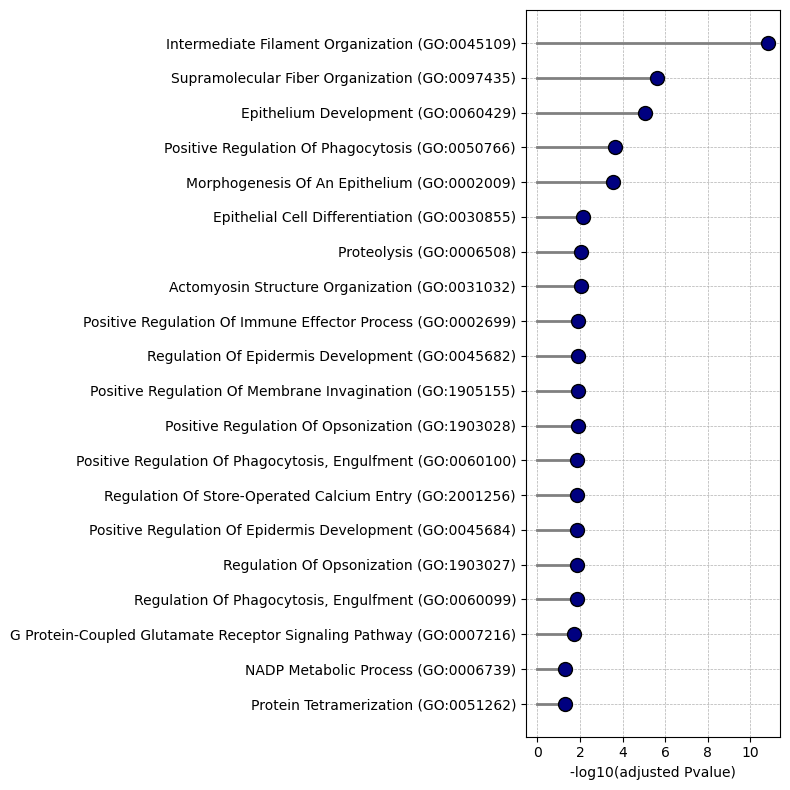

In [12]:
import gseapy as gp
import numpy as np
import matplotlib.pyplot as plt

enr = gp.enrichr(gene_list=list(DN_genes),
                 #gene_sets=['WikiPathway_2023_Human'],
                 gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023'],
                 organism='human',
                )

enr.results[enr.results['Adjusted P-value'] <= 0.05]

top10 = enr.results[enr.results['Adjusted P-value'] <= 0.05]
top10 = top10.iloc[0:20, :]
top10['-log10(P-value)'] = -np.log10(top10['Adjusted P-value'])
top10 = top10.sort_values('-log10(P-value)', ascending=True)
#top10['Term'] = top10['Term'].str.replace(r' R-HSA-\d+$', '', regex=True)
top10['Term'] = top10['Term'].apply(split_long_sentences)

# Plotting
plt.figure(figsize=(8, 8))

for i in range(len(top10)):
    plt.plot([0, top10['-log10(P-value)'].iloc[i]], [top10['Term'].iloc[i], top10['Term'].iloc[i]], color='gray', linestyle='-', linewidth=2)  # Line part of lollipop
    plt.scatter(top10['-log10(P-value)'].iloc[i], top10['Term'].iloc[i], color='navy', s=100, edgecolor='black', zorder=5)  # Dot part of lollipop

plt.xlabel('-log10(adjusted Pvalue)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig('../res/plots/DN_pathways.png', format='png', dpi=300)
plt.show()

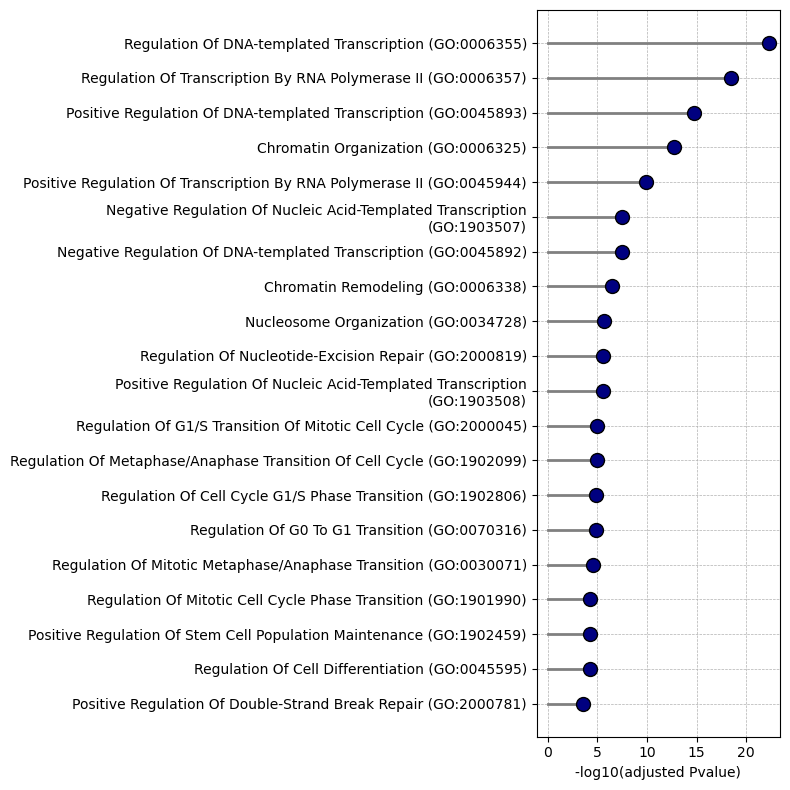

In [13]:
import gseapy as gp
import matplotlib.pyplot as plt

enr = gp.enrichr(gene_list=list(LOF_genes),
                 #gene_sets=['DisGeNET'],
                 gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023'],
                 organism='human',
                )

enr.results[enr.results['Adjusted P-value'] <= 0.05]

top10 = enr.results[enr.results['Adjusted P-value'] <= 0.05]
top10 = top10.iloc[0:20, :]
top10['-log10(P-value)'] = -np.log10(top10['Adjusted P-value'])
top10 = top10.sort_values('-log10(P-value)', ascending=True)
#top10['Term'] = top10['Term'].str.replace(r' R-HSA-\d+$', '', regex=True)
top10['Term'] = top10['Term'].apply(split_long_sentences)

# Plotting
plt.figure(figsize=(8, 8))

for i in range(len(top10)):
    plt.plot([0, top10['-log10(P-value)'].iloc[i]], [top10['Term'].iloc[i], top10['Term'].iloc[i]], color='gray', linestyle='-', linewidth=2)  # Line part of lollipop
    plt.scatter(top10['-log10(P-value)'].iloc[i], top10['Term'].iloc[i], color='navy', s=100, edgecolor='black', zorder=5)  # Dot part of lollipop

plt.xlabel('-log10(adjusted Pvalue)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig('../res/plots/LOF_pathways.png', format='png', dpi=300)
plt.show()

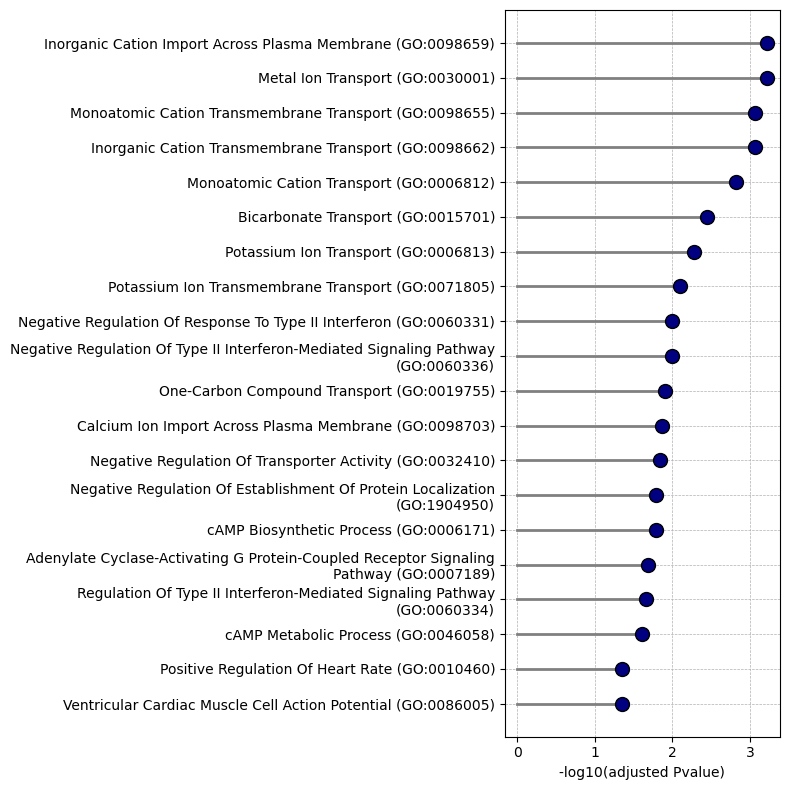

In [14]:
import gseapy as gp
import matplotlib.pyplot as plt

enr = gp.enrichr(gene_list=list(GOF_genes),
                 #gene_sets=['DisGeNET'],
                 gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023'],
                 organism='human',
                )

enr.results[enr.results['Adjusted P-value'] <= 0.05]

top10 = enr.results[enr.results['Adjusted P-value'] <= 0.05]
top10 = top10.iloc[0:20, :]
top10['-log10(P-value)'] = -np.log10(top10['Adjusted P-value'])
top10 = top10.sort_values('-log10(P-value)', ascending=True)
#top10['Term'] = top10['Term'].str.replace(r' R-HSA-\d+$', '', regex=True)
top10['Term'] = top10['Term'].apply(split_long_sentences)

# Plotting
plt.figure(figsize=(8, 8))

for i in range(len(top10)):
    plt.plot([0, top10['-log10(P-value)'].iloc[i]], [top10['Term'].iloc[i], top10['Term'].iloc[i]], color='gray', linestyle='-', linewidth=2)  # Line part of lollipop
    plt.scatter(top10['-log10(P-value)'].iloc[i], top10['Term'].iloc[i], color='navy', s=100, edgecolor='black', zorder=5)  # Dot part of lollipop

plt.xlabel('-log10(adjusted Pvalue)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig('../res/plots/GOF_pathways.png', format='png', dpi=300)
plt.show()